# Prediction of bookings based on user behavior
Data Scientist – User Profiling, Hotel Search

- Author: Kai Chen
- Date: Apr, 2018

There are 3 types of data: Bookings, User actions, Example

## Data: Bookings
- Description: List of sessions, each with: session-related contextual data, and whether at least one booking was made
- Files:
	- case_study_bookings_train.csv: Training sessions for bookings
	- case_study_bookings_target.csv: Target sessions to predict bookings
- Rows: Each row represents a session with session context and the outcome of this session
- Columns:
	- ymd: Date of the session in format 'yyMMdd'
	- user_id: Anonymized cookie id of the visitor
	- session_id: Anonymized id of the session
	- referer_code: Encoded category of the referer to the website
	- is_app: If the session was made using the trivago app
	- agent_id: Encoded type of the browser
	- traffic_type: A categorization of the type of the traffic
	- has_booking: 1 if at least one booking was made during the session (excluded from the target set)
    
## Data: User Actions
- Description: Sequence of various type of user actions generated during the usage of the website.
- Files
	- case_study_actions_train.csv: Training set of user actions
	- case_study_actions_target.csv: User actions in the target sessions
- Rows: Each row represents one action from/to the user
- Columns:
	- ymd: Date of the action in format 'yyMMdd'
	- user_id: Anonymized cookie id of the visitor
	- session_id: Anonymized id of the session
	- action_id: Type of the action
	- reference: Object of the action. - We note that action_ids with big set of reference values (e.g. action id '2116') are typically related to the content (e.g hotels, destinations or keywords); while action_ids with small reference set (e.g. action id '2351') are more related a function of the website (e.g. sorting order, room type, filters, etc.)
	- step: The number identifying the action in the session
	
## Data: Example Solution
- Description: List of predictions for bookings in the target sessions
- File: case_study_bookings_target_prediction_example.csv
- Rows: Each row represent a target session for which a prediction should be given
- Columns:
	- session_id: Anonymized id of the session
	- has_booking: Random binary predictions for bookings

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression

import numpy as np
import pandas as pd
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.externals import joblib
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn import linear_model

import xgboost as xgb
from xgboost import XGBClassifier

In [2]:
# ---
# Define file paths
TRAIN_BOOKING_FILE_PATH = 'data/case_study_bookings_train.csv'    # training sessions for bookings
TARGET_BOOKING_FILE_PATH = 'data/case_study_bookings_target.csv'  # target sessions to predict bookings

TRAIN_ACTION_FILE_PATH = 'data/case_study_actions_train.csv'       # training set of user actions
TARGET_ACTION_FILE_PATH = 'data/case_study_actions_target.csv'     # user actions in the target sessions

## Step 1: read and explore the data

In [5]:
train_booking_df = pd.read_csv(TRAIN_BOOKING_FILE_PATH, sep='\t')
train_booking_df['ymd'] = pd.to_datetime(train_booking_df['ymd'].astype('str'))

print('train booking')
print(train_booking_df.columns)
display(train_booking_df.head(5))

train booking
Index(['ymd', 'user_id', 'session_id', 'referer_code', 'is_app', 'agent_id',
       'traffic_type', 'has_booking'],
      dtype='object')


ymd           user_id           session_id  referer_code  is_app  \
0 2017-04-23   388309106223940  3052767322364990735             0       0   
1 2017-04-10   452426828488840  1022778951418899936             0       0   
2 2017-04-15   452426828488840  4191504489082712531             0       0   
3 2017-04-06   819438352219100  4560227804862289210             1       0   
4 2017-04-07  1113732603712480  4115013282086590434             0       0   

   agent_id  traffic_type  has_booking  
0         2             1            0  
1        10             2            0  
2        10             2            0  
3         1             1            0  
4         9             2            0

In [6]:
target_booking_df = pd.read_csv(TARGET_BOOKING_FILE_PATH, sep='\t')
target_booking_df['ymd'] = pd.to_datetime(target_booking_df['ymd'].astype('str'))

print('target booking')
print(target_booking_df.columns)
display(target_booking_df.head(5))

target booking
Index(['ymd', 'user_id', 'session_id', 'referer_code', 'is_app', 'agent_id',
       'traffic_type'],
      dtype='object')


ymd           user_id           session_id  referer_code  is_app  \
0 2017-04-30  1607565913119260  4175939893794521966             0       0   
1 2017-04-30  1607565913119260  9175174925268392332             0       0   
2 2017-04-30  2669945826129900  5361965966177226983             0       0   
3 2017-04-30  6247954936827660  7996347049132178025             0       0   
4 2017-04-30  6447705595982360  6061498713259551906            99       0   

   agent_id  traffic_type  
0        14             6  
1        14             1  
2         6             6  
3        13             2  
4         1             6

In [7]:
train_user_id_list = train_booking_df['user_id'].unique()
train_session_id_list = train_booking_df['session_id'].unique()

print('number of users (train booking data): {}'.format(len(train_user_id_list)))
print('number of sessions (tarin booking data): {}'.format(len(train_session_id_list)))
print('dataframe size (train booking data)')
print(train_booking_df.shape)

number of users (train booking data): 181860
number of sessions (tarin booking data): 307677
dataframe size (train booking data)
(307677, 8)


In [8]:
target_user_id_list = target_booking_df['user_id'].unique()
target_session_id_list = target_booking_df['session_id'].unique()

print('number of users (target booking data): {}'.format(len(target_user_id_list)))
print('number of sessions (target booking data): {}'.format(len(target_session_id_list)))
print('dataframe size (target booking data)')
print(target_booking_df.shape)

number of users (target booking data): 23402
number of sessions (target booking data): 30128
dataframe size (target booking data)
(30128, 7)


In [9]:
train_action_df = pd.read_csv(TRAIN_ACTION_FILE_PATH, sep='\t')
train_action_df['ymd'] = pd.to_datetime(train_action_df['ymd'].astype('str'))

print('train action')
print(train_action_df.columns)
display(train_action_df.head(5))

train action
Index(['ymd', 'user_id', 'session_id', 'action_id', 'reference', 'step'], dtype='object')


ymd          user_id           session_id  action_id  reference  step
0 2017-04-23  388309106223940  3052767322364990735       8001    1323836     1
1 2017-04-10  452426828488840  1022778951418899936       2116     929835     1
2 2017-04-10  452426828488840  1022778951418899936       6999          0     2
3 2017-04-10  452426828488840  1022778951418899936       2116     929835     3
4 2017-04-10  452426828488840  1022778951418899936       2503          1     4

In [10]:
train_user_id_action_list = train_action_df['user_id'].unique()
train_session_id_action_list = train_action_df['session_id'].unique()

print('number of users (train action data): {}'.format(len(train_user_id_action_list)))
print('number of sessions (train action data): {}'.format(len(train_session_id_action_list)))
print('dataframe size (train booking data)')
print(train_action_df.shape)

number of users (train action data): 181730
number of sessions (train action data): 306106
dataframe size (train booking data)
(5862863, 6)


In [11]:
target_action_df = pd.read_csv(TARGET_ACTION_FILE_PATH, sep='\t')
target_action_df['ymd'] = pd.to_datetime(target_action_df['ymd'].astype('str'))

print('target action')
print(target_action_df.columns)
print(target_action_df.head(5))

target action
Index(['ymd', 'user_id', 'session_id', 'action_id', 'reference', 'step'], dtype='object')
         ymd           user_id           session_id  action_id  reference  \
0 2017-04-30  1607565913119260  4175939893794521966       2113      60196   
1 2017-04-30  1607565913119260  4175939893794521966       6999          0   
2 2017-04-30  1607565913119260  4175939893794521966       2113      60196   
3 2017-04-30  1607565913119260  9175174925268392332       2100          0   
4 2017-04-30  1607565913119260  9175174925268392332       6999          0   

   step  
0     1  
1     2  
2     3  
3     1  
4     2  


In [12]:
target_user_id_action_list = target_action_df['user_id'].unique()
target_session_id_action_list = target_action_df['session_id'].unique()


print('number of users (target action data): {}'.format(len(target_user_id_action_list)))
print('number of sessions (target action data): {}'.format(len(target_session_id_action_list)))
print('dataframe size (target booking data)')
print(target_action_df.shape)

number of users (target action data): 23314
number of sessions (target action data): 29957
dataframe size (target booking data)
(575152, 6)


In [13]:
train_action_df = pd.read_csv(TRAIN_ACTION_FILE_PATH, sep='\t')
train_action_df['ymd'] = pd.to_datetime(train_action_df['ymd'].astype('str'))

print('train action')
print(train_action_df.columns)
print(train_action_df.head(5))

train action
Index(['ymd', 'user_id', 'session_id', 'action_id', 'reference', 'step'], dtype='object')
         ymd          user_id           session_id  action_id  reference  step
0 2017-04-23  388309106223940  3052767322364990735       8001    1323836     1
1 2017-04-10  452426828488840  1022778951418899936       2116     929835     1
2 2017-04-10  452426828488840  1022778951418899936       6999          0     2
3 2017-04-10  452426828488840  1022778951418899936       2116     929835     3
4 2017-04-10  452426828488840  1022778951418899936       2503          1     4


In [14]:
train_user_id_action_list = train_action_df['user_id'].unique()
train_session_id_action_list = train_action_df['session_id'].unique()


print('number of users (train action data): {}'.format(len(train_user_id_action_list)))
print('number of sessions (train action data): {}'.format(len(train_session_id_action_list)))
print('dataframe size (train booking data)')
print(train_action_df.shape)

number of users (train action data): 181730
number of sessions (train action data): 306106
dataframe size (train booking data)
(5862863, 6)


In [15]:
target_action_df = pd.read_csv(TARGET_ACTION_FILE_PATH, sep='\t')
target_action_df['ymd'] = pd.to_datetime(target_action_df['ymd'].astype('str'))

print('target action')
print(target_action_df.columns)
print(target_action_df.head(5))

target action
Index(['ymd', 'user_id', 'session_id', 'action_id', 'reference', 'step'], dtype='object')
         ymd           user_id           session_id  action_id  reference  \
0 2017-04-30  1607565913119260  4175939893794521966       2113      60196   
1 2017-04-30  1607565913119260  4175939893794521966       6999          0   
2 2017-04-30  1607565913119260  4175939893794521966       2113      60196   
3 2017-04-30  1607565913119260  9175174925268392332       2100          0   
4 2017-04-30  1607565913119260  9175174925268392332       6999          0   

   step  
0     1  
1     2  
2     3  
3     1  
4     2  


In [16]:
target_user_id_action_list = target_action_df['user_id'].unique()
target_session_id_action_list = target_action_df['session_id'].unique()


print('number of users (target action data): {}'.format(len(target_user_id_action_list)))
print('number of sessions (target action data): {}'.format(len(target_session_id_action_list)))
print('dataframe size (target booking data)')
print(target_action_df.shape)

number of users (target action data): 23314
number of sessions (target action data): 29957
dataframe size (target booking data)
(575152, 6)


In [17]:
train_user_df =  pd.merge(train_booking_df, train_action_df, on=['ymd', 'user_id', 'session_id'])
print('train user df shape')
print(train_user_df.shape)
display(train_user_df.head(5))

train user df shape
(5862863, 11)


ymd          user_id           session_id  referer_code  is_app  \
0 2017-04-23  388309106223940  3052767322364990735             0       0   
1 2017-04-10  452426828488840  1022778951418899936             0       0   
2 2017-04-10  452426828488840  1022778951418899936             0       0   
3 2017-04-10  452426828488840  1022778951418899936             0       0   
4 2017-04-10  452426828488840  1022778951418899936             0       0   

   agent_id  traffic_type  has_booking  action_id  reference  step  
0         2             1            0       8001    1323836     1  
1        10             2            0       2116     929835     1  
2        10             2            0       6999          0     2  
3        10             2            0       2116     929835     3  
4        10             2            0       2503          1     4

In [18]:
print('ymd (train)')
print(train_user_df['ymd'].unique())

ymd (train)
['2017-04-23T00:00:00.000000000' '2017-04-10T00:00:00.000000000'
 '2017-04-15T00:00:00.000000000' '2017-04-06T00:00:00.000000000'
 '2017-04-07T00:00:00.000000000' '2017-04-19T00:00:00.000000000'
 '2017-04-16T00:00:00.000000000' '2017-04-17T00:00:00.000000000'
 '2017-04-04T00:00:00.000000000' '2017-04-13T00:00:00.000000000'
 '2017-04-08T00:00:00.000000000' '2017-04-25T00:00:00.000000000'
 '2017-04-09T00:00:00.000000000' '2017-04-12T00:00:00.000000000'
 '2017-04-03T00:00:00.000000000' '2017-04-24T00:00:00.000000000'
 '2017-04-27T00:00:00.000000000' '2017-04-26T00:00:00.000000000'
 '2017-04-02T00:00:00.000000000' '2017-04-14T00:00:00.000000000'
 '2017-04-05T00:00:00.000000000' '2017-04-22T00:00:00.000000000'
 '2017-04-20T00:00:00.000000000' '2017-04-11T00:00:00.000000000'
 '2017-04-18T00:00:00.000000000' '2017-04-21T00:00:00.000000000'
 '2017-04-01T00:00:00.000000000']


In [19]:
target_user_df =  pd.merge(target_booking_df, target_action_df, on=['ymd', 'user_id', 'session_id'])
print('target user df shape')
print(target_user_df.shape)

target user df shape
(575152, 10)


In [20]:
print(target_user_df.columns)
print(target_user_df.head(5))
print('ymd (target)')
print(target_user_df['ymd'].unique())

Index(['ymd', 'user_id', 'session_id', 'referer_code', 'is_app', 'agent_id',
       'traffic_type', 'action_id', 'reference', 'step'],
      dtype='object')
         ymd           user_id           session_id  referer_code  is_app  \
0 2017-04-30  1607565913119260  4175939893794521966             0       0   
1 2017-04-30  1607565913119260  4175939893794521966             0       0   
2 2017-04-30  1607565913119260  4175939893794521966             0       0   
3 2017-04-30  1607565913119260  9175174925268392332             0       0   
4 2017-04-30  1607565913119260  9175174925268392332             0       0   

   agent_id  traffic_type  action_id  reference  step  
0        14             6       2113      60196     1  
1        14             6       6999          0     2  
2        14             6       2113      60196     3  
3        14             1       2100          0     1  
4        14             1       6999          0     2  
ymd (target)
['2017-04-30T00:00:00.000000000

In [22]:
train_user_id_list = train_user_df['user_id'].unique()

print('number of users (train) {}'.format(len(train_user_id_list)))

number of users (train) 181730


In [23]:
target_user_id_list = target_user_df['user_id'].unique()

print('number of users (target) {}'.format(len(target_user_id_list)))

number of users (target) 23314


In [27]:
print('\nnumber of different user between train user id and target user id')
print(len(set(train_user_id_list) - set(target_user_id_list)))

# this shows that we can not use user_id as a feature


number of different user between train user id and target user id
173755


In [29]:
print('correlation')
corr_score = train_user_df['referer_code'].corr(train_user_df['has_booking'])
print('corr score of referer_code and has_booking {}'.format(corr_score))

corr_score = train_user_df['is_app'].corr(train_user_df['has_booking'])
print('corr score of is_app and has_booking {}'.format(corr_score))

corr_score = train_user_df['agent_id'].corr(train_user_df['has_booking'])
print('corr score of agent_id and has_booking {}'.format(corr_score))

corr_score = train_user_df['traffic_type'].corr(train_user_df['has_booking'])
print('corr score of traffic_type and has_booking {}'.format(corr_score))

corr_score = train_user_df['action_id'].corr(train_user_df['has_booking'])
print('corr score of action_id and has_booking {}'.format(corr_score))

corr_score = train_user_df['reference'].corr(train_user_df['has_booking'])
print('corr score of reference and has_booking {}'.format(corr_score))

corr_score = train_user_df['step'].corr(train_user_df['has_booking'])
print('corr score of step and has_booking {}'.format(corr_score))

correlation
corr score of referer_code and has_booking -0.04996365727616134
corr score of is_app and has_booking -0.05034281311524376
corr score of agent_id and has_booking -0.1027644482553173
corr score of traffic_type and has_booking -0.08003718320445342
corr score of action_id and has_booking 0.008564912707614244
corr score of reference and has_booking 0.005837510233315804
corr score of step and has_booking 0.08539763680890129


In [32]:
def get_nb_bookings_dict(df, column_name, has_booking_name='has_booking'):
    # key: column value  value: number of bookings
    dict_nb_bookings = dict()
    col_list = df[column_name].unique()
    # print(column_name)
    # print(col_list)
    for value in col_list:
        values = df[train_user_df[column_name] == value][has_booking_name].values
        dict_nb_bookings[value] = sum(values)

    return dict_nb_bookings, col_list

In [41]:
feature_columns = ['referer_code', 'is_app', 'agent_id', 'traffic_type', 'action_id', 'reference', 'step']

dict_feature_nb_bookings = dict()
dict_feature_list = dict()

for feature_column in feature_columns:
    dict_feature_column, feature_column_list = get_nb_bookings_dict(train_user_df, feature_column)
    
    dict_feature_nb_bookings[feature_column] = dict_feature_column
    dict_feature_list[feature_column] = feature_column_list
    
    print('\n --------------------')
    print(feature_column)
    print(feature_column_list)
    print('{}, {}'.format(feature_column, 'nb bookings'))
    for key, value in dict_feature_column.items():
        print('{}, {}'.format(key, value))
    print('\n --------------------\n')
    


 --------------------
referer_code
[ 0  1 99 15 11 10 24 21 23 17 19]
referer_code, nb bookings
0, 308655
1, 366608
99, 43789
15, 1297
11, 29141
10, 10611
24, 0
21, 1785
23, 402
17, 21
19, 0

 --------------------


 --------------------
is_app
[0 1]
is_app, nb bookings
0, 700019
1, 62290

 --------------------


 --------------------
agent_id
[ 2 10  1  9 14  7  8  6 13  0 12 11  3  4  5]
agent_id, nb bookings
2, 33809
10, 78428
1, 224860
9, 128684
14, 41493
7, 69655
8, 100821
6, 57062
13, 22576
0, 2848
12, 711
11, 1354
3, 8
4, 0
5, 0

 --------------------


 --------------------
traffic_type
[ 1  2  6  4  3  7 10]
traffic_type, nb bookings
1, 507089
2, 172942
6, 35121
4, 4504
3, 42193
7, 56
10, 404

 --------------------


 --------------------
action_id
[8001 2116 6999 2503 2113 2100 2362 2306 2358 2350 2146 2331 2145 2122
 2502 2166 2260 2296 8010 2119 2115 2351 2175 2142 2314 2111 2357 2123
 2367 2262 2501 2133 2136 2135 2216 2121 2257 2188 2155 2114 2700 2788
 2784 2884 2710 27

22003, 2
34773, 3
3148718, 10
22043, 0
34759, 2
22001, 5
23649, 1
21348, 0
34755, 3
21275, 0
29633, 0
34779, 40
4627206, 0
21246, 0
34767, 67
1388896, 22
3446046, 0
2628191, 147
34746, 0
34740, 40
3768998, 222
22040, 1
1380030, 10
3586584, 4
2524436, 1
2196770, 11
2719114, 0
34768, 0
909485, 6
163359, 11
21623, 0
1208406, 0
3976966, 5
530338, 38
6802238, 1
530208, 1
1334852, 1
757396, 2
3924454, 6
945337, 5
44232, 327
4942, 4
35543, 2
39362, 152
19768, 76
1216780, 47
89468, 5
1487915, 65
4636720, 12
19411, 13
19401, 27
48053, 14
719411, 3
558040, 2
46274, 1
1147875, 0
18718, 64
47174, 43
1362578, 1
558042, 1
15980, 121
4022328, 0
47929, 0
1361276, 0
18883, 22
47900, 8
43225, 0
31901, 12
16144, 0
240, 0
234, 0
233, 1
241, 0
88978, 0
469094, 0
18018, 2
46851, 10
46847, 35
881863, 7
46915, 9
2785540, 0
42647, 27
42328, 0
242951, 0
42320, 4
153062, 0
42326, 8
1306536, 0
48527, 0
28318, 0
11495, 3
11570, 11
2438799, 0
81520, 0
11558, 2
32973, 40
4101, 10
158923, 2
1478491, 0
41997, 32
75255

7343, 0
71863, 0
33611, 0
33613, 0
733613, 0
33656, 0
733656, 0
1836059, 62
80434, 9
1352119, 15
15075, 1
634786, 9
634476, 0
894933, 7
1075122, 0
47205, 3
1950681, 55
1205998, 3
18182, 1
2396162, 10
2398873, 0
2824918, 0
1704377, 0
1934215, 0
139579, 0
1223232, 9
8251, 0
1059330, 0
947323, 0
958757, 0
39602, 12
47635, 0
490269, 17
1750811, 0
84866, 100
2081670, 0
533836, 2
162864, 0
149698, 1
15656, 1
67379, 0
3994898, 0
46501, 11
951495, 0
557566, 2
2044975, 8
6849182, 0
47933, 9
553166, 7
48166, 74
47373, 9
47799, 13
18426, 6
148510, 0
55354, 0
342896, 0
40587, 174
12595, 82
533871, 30
44675, 25
2671048, 0
38322, 0
38458, 0
2142562, 0
38567, 14
529881, 0
630141, 0
89089, 37
7103882, 0
3079114, 0
158721, 6
347086, 0
135683, 0
347081, 0
103562, 0
48566, 1
14523, 1
131965, 1
2282778, 0
5434506, 0
1319782, 3
1258693, 24
40407, 33
1755455, 0
6832, 1
1711339, 30
110635, 1
405576, 40
343531, 1
3490736, 0
42201, 2
42255, 4
623636, 0
95748, 0
1106276, 8
3149106, 0
47674, 80
12606, 91
89192, 

8482, 0
12021, 1
46981, 86
604741, 0
3184197, 8
41017, 11
18869, 161
39758, 70
39613, 15
41548, 3
1642963, 0
10156, 3
9003, 0
11839, 0
777153, 1
47187, 7
33823, 34
119371, 0
35402, 24
48919, 1
50271, 4
5043032, 0
85715, 4
2416466, 26
31929, 0
6978, 4
175647, 0
83531, 5
46239, 3
342316, 3
46451, 153
4497988, 6
149136, 75
1038018, 2
3768494, 8
1167758, 13
1169960, 37
967771, 1
46243, 2
1074950, 1
1007887, 0
71007887, 0
47065, 96
1358401, 9
137696, 12
235754, 0
11528, 1
14186, 1
17769, 3
15111, 1
17423, 0
2627705, 0
2159030, 10
149075, 3
1574603, 1
46303, 4
1840085, 7
18420, 6
4455144, 20
18447, 8
9221, 3
13849, 1
1973873, 75
1119279, 21
1289594, 6
1839425, 5
178382, 0
1352604, 9
928447, 0
16698, 26
529846, 0
3230376, 0
86948, 0
83078, 4
1075654, 38
37156, 28
44291, 21
1826025, 0
44264, 6
1320377, 0
873211, 0
41963, 11
99234, 1
96424, 1
14024, 1
2628242, 8
51893, 4
1006931, 1
2094536, 7
2048651, 5
37324, 3
38372, 18
581461, 0
2729628, 0
966097, 0
1810141, 18
1169335, 0
102080, 27
46817, 3

5702, 6
75702, 0
881599, 3
94217, 1
73742, 4
127739, 3
102848, 3
81306, 1
14049, 1
2518522, 0
100501, 0
102850, 0
47320, 26
7390, 8
46651, 19
12540, 288
2394162, 18
3050240, 3
16942, 3
18238, 0
22414, 0
926735, 0
712521, 1
137853, 9
629256, 1
951099, 20
2870086, 20
6477920, 7
107733, 15
1439509, 4
2174680, 1
119578, 11
5027294, 2
2786334, 1
1074760, 3
364766, 40
947157, 1
634806, 11
945451, 33
47817, 34
12762, 74
1858183, 3
1215004, 0
39415, 4
1991685, 64
151579, 0
218041, 0
412706, 0
95949, 1
126815, 0
117361, 2
1478587, 10
89096, 0
124532, 0
1158832, 0
48185, 0
2709274, 1
4060116, 0
1105940, 0
43253, 6
106038, 6
236471, 4
44335, 1
46519, 39
127928, 59
1079824, 2
1309834, 7
1242231, 33
1178918, 0
1286034, 4
1664683, 0
1839649, 6
19353, 67
1292270, 1
1711181, 2
635426, 56
1286116, 1
6908904, 1
6275922, 0
1111902, 0
4727610, 1
93439, 3
147471, 0
80675, 19
111040, 0
47090, 15
46820, 30
936497, 0
48098, 25
2006425, 0
975635, 0
6322262, 0
6300100, 0
6655038, 0
2742228, 11
12631, 1
12625, 4

40221, 1
150438, 1
780913, 0
82256, 0
40299, 0
107390, 1
80884, 8
4573114, 1
1083560, 6
40337, 7
1332402, 2
3175452, 1
40851, 7
1359902, 1
186836, 5
7051, 122
2580862, 2
150449, 3
110907, 0
1329122, 1
7467, 4
7451, 1
40732, 0
1996643, 1
1411963, 0
7454, 0
40832, 30
3101324, 0
5742820, 0
150441, 0
7469, 1
148320, 59
2045293, 3
128598, 0
3981202, 0
91407, 0
48040, 40
2670680, 0
133089, 6
1322526, 0
39024, 12
4763864, 13
632796, 4
5607064, 0
164220, 26
6695866, 11
3133853, 7
1259691, 2
913329, 0
31660, 17
37936, 21
34717, 3
322751, 2
31817925, 0
19313, 49
42275, 10
84767, 0
436511, 0
684276, 0
73272, 10
246186, 1
312351, 1
312651, 2
313531, 1
31625, 3
40596, 4
892049, 1
31615, 33
4090066, 1
40741, 1
46689, 15
34483, 0
73406, 0
109988, 26
46153, 0
540611, 2
47945, 50
8888, 17
103318, 14
81502, 7
3111152, 0
6768, 62
47018, 2
40426, 2
2467046, 13
1433876, 40
41824, 2
110921, 0
39759, 1
39971, 0
107323, 0
109845, 16
18995, 16
718995, 1
38958, 11
11732, 1
18467, 12
11692, 1
1501485, 26
1837149

2739042, 0
320691, 0
2198956, 0
2302062, 0
3846, 0
5418, 0
5811, 1
1487271, 0
2157384, 11
127952, 4
19832, 3
46202, 50
344811, 5
32730, 15
437561, 0
2399790, 0
17403, 0
1239366, 5
3836976, 0
3996194, 0
17166, 0
2016225, 97
4580422, 0
40670, 17
41633, 17
1074792, 0
41803, 0
48070, 2
3957368, 3
1112545, 6
1487727, 0
156581, 26
2276268, 0
4483316, 1
940296, 0
4078962, 0
633696, 4
366851, 0
1142629, 17
1892661, 0
1815727, 0
3900396, 0
4130904, 0
2143858, 0
4569674, 0
5779292, 0
5067054, 0
4982934, 0
40836, 2
6693478, 0
2898788, 0
36708, 33
4754580, 0
188141, 1
4639790, 0
49421, 4
4597906, 0
114338, 0
150653, 16
3976962, 0
130320, 0
126927, 0
1049092, 0
40327, 0
3058320, 0
41932, 4
5727376, 15
406021, 1
41176, 23
1107236, 23
39597, 7
150825, 4
12563, 105
425246, 0
6419304, 0
139307, 6
1107272, 5
13759, 2
4904906, 3
55080, 0
40082, 0
1121919, 0
1533101, 6
1708535, 5
1351542, 7
42238, 0
15617, 0
2892126, 0
4342732, 0
2672616, 0
78506, 0
327246, 0
1974057, 0
437251, 2
20132, 0
35486, 0
38456, 

95905, 1
39576, 2
3979560, 0
80958, 3
4040852, 0
31764, 40
14658, 5
40779, 0
40534, 1
37385, 0
3133970, 1
19892, 23
3367048, 0
46409, 59
8636, 3
31883, 0
2339754, 0
112695, 3
1818315, 0
15357, 0
32942, 3
4643, 0
31164, 0
6223792, 0
1167571, 0
1887939, 0
3801578, 0
1309013, 0
685111, 0
7685111, 0
2655526, 0
72655526, 0
1166431, 0
2333144, 0
12813, 0
1825377, 0
31478, 12
3086743, 0
41874, 0
41854, 0
85432, 0
775863, 0
42000, 0
3175572, 0
100556, 0
100574, 0
919253, 0
384721, 0
518936, 0
505706, 0
48000, 32
52606, 0
1638935, 0
3385358, 0
6312378, 0
4545600, 0
5163500, 0
5796634, 0
4055884, 0
17631, 1
12155, 6
9541, 1
715816, 1
16594, 0
15746, 0
13200, 0
14170, 0
10049, 0
9766, 0
16161, 0
2924851, 0
1907581, 0
156267, 0
37834, 6
372491, 14
1822539, 0
638241, 1
930981, 0
4465396, 0
10514, 0
930975, 0
946323, 0
18613, 0
6469670, 1
21100840, 0
6918628, 1
1154289, 1
2733626, 9
7631386, 0
8829, 0
1998641, 10
2523, 6
7110, 0
82424, 0
4688778, 0
4554742, 0
2733, 4
1705757, 0
5449368, 0
5465280, 0

2870168, 0
1285953, 0
631376, 1
342476, 10
86918, 1
1239902, 49
38290, 35
19705, 4
1571087, 0
71853, 33
6111548, 0
1220044, 0
1946849, 0
4073378, 0
2196296, 3
1823451, 1
2339712, 3
922527, 1
1839567, 0
2061568, 0
2149442, 0
7574, 0
82400, 0
1998221, 6
1602591, 0
636561, 1
94292, 0
94245, 0
41210, 14
41108, 13
2419834, 2
19590, 25
3194756, 0
3811728, 71
2417612, 1
904557, 0
1502715, 2
746451, 0
31314104, 0
1258576, 20
748008, 0
746833, 1
1693441, 24
5220788, 2
162276, 61
16021, 0
14209, 1
19005, 20
1933237, 0
1976027, 0
4824, 0
1356374, 10
112355, 0
85358, 2
40385, 6
946511, 11
3884910, 0
47971, 8
342446, 13
1747351, 0
3219812, 0
530676, 0
629008, 0
757971, 18
50763, 0
2302078, 0
3074210, 0
2952880, 0
50718, 2
2971006, 0
14824, 1
3231794, 0
897865, 0
1891167, 3
3231706, 1
1503045, 2
107771, 0
84935, 1
45631, 1
1503215, 4
153567, 0
17012, 0
16975, 4
16880, 0
17283, 0
1904297, 30
150176, 2
17027, 0
1255945, 10
1926765, 0
3753966, 0
921489, 0
41360, 0
6688872, 0
1148968, 2
404741, 0
266240

11828, 3
1775735, 23
2144514, 0
2632560, 0
4126103, 0
1775791, 0
10491, 1
18748, 51
343191, 34
1309832, 2
1341276, 1
57385203, 0
4148103, 1
3904103, 0
3903903, 1
847361, 1
12426, 21
1075760, 0
48894103, 0
3781403, 0
60306, 0
66822, 0
748059, 0
8499, 1
1318599, 0
46030, 0
404771, 4
1354282, 0
2617934, 0
773408, 0
1895771, 0
163866, 6
134406, 0
1404771, 0
1721949, 0
773413, 0
773403, 0
194137, 0
2003361, 7
152025, 10
2846071, 1
636621, 4
12517, 53
1362593, 3
1932671, 2
908987, 2
4038712, 6
342471, 11
47355, 21
194181, 6
39528, 0
348, 13
2087456, 17
539766, 3
46428, 4
7106131, 1
3400, 12
901955, 0
1084564, 0
4624306, 0
3194082, 3
322501, 24
132216, 61
4487252, 13
436351, 1
939220, 14
46627, 2
531496, 15
1325780, 2
2036555, 1
598961, 0
20476, 0
21967, 0
22104, 0
24338, 0
26025, 0
27297, 0
28826, 0
242, 23
5111734, 0
2393796, 0
591672, 0
521706, 0
1360304, 0
1621963, 0
29264, 0
29330, 1
29333, 0
29293, 0
29348, 1
14260, 1
4386540, 1
29338, 0
18236, 0
41074, 0
29329, 0
29347, 0
103447, 0
637

31496, 0
530431, 7
71906, 0
53704, 0
2340414, 3
894985, 7
631351, 0
2325630, 1
1079140, 0
4269294, 2
48142, 8
13708, 15
86986, 3
51194, 0
39981, 0
40020, 3
161020, 0
40017, 0
2302578, 0
37262, 0
2826070, 0
1513199, 1
2497774, 0
37277, 0
57075, 0
47687, 2
151445, 1
2053598, 0
1992293, 0
80383, 25
7174, 3
7176, 19
42404, 1
117555, 0
1078788, 9
1419606, 2
5756460, 0
3829150, 0
1006239, 3
4830142, 0
1989633, 0
5488774, 0
3828460, 0
1893577, 0
5199852, 0
6300140, 0
4105642, 0
2336304, 0
3135632, 0
3179740, 2
4775910, 0
443319, 0
1544851, 1
5959082, 0
2712506, 0
5757660, 0
1042, 0
3893, 0
4011, 0
6724036, 0
12356, 26
1029180, 0
1626, 0
1839773, 0
7695, 1
10377, 0
33682, 13
4188754, 0
33585, 2
171860, 0
132257, 0
18189, 0
12942, 1
14691, 3
11893, 25
71858, 0
1319726, 3
1699245, 0
2420786, 0
982127, 2
33601, 1
31319726, 0
1056752, 0
171858, 0
71847, 0
5865620, 0
95967, 0
3059, 0
3939, 0
33590, 0
2670284, 0
3220, 0
4040, 1
791561, 0
33848, 0
33505, 0
4714228, 0
121928, 0
19472, 1
10260, 0
22154

2727856, 1
1250849, 1
2588646, 7
3808352, 1
148040, 2
84968, 2
12374, 15
1816239, 13
18574, 10
140592, 4
18525, 22
12003, 1
125845, 5
107335, 4
6868, 19
85029, 2
4560382, 2
4164758, 11
7201, 176
6002, 0
4182478, 19
6908038, 3
4386498, 0
1103672, 8
1714681, 1
47365, 42
1275968, 0
87423, 16
447653, 0
2893533, 0
2674484, 0
1837937, 0
483721, 0
19895, 0
448035, 6
341906, 0
1145031, 0
1359200, 0
480821, 5
4552228, 9
652528, 12
788199, 13
1991571, 1
46060, 3
116642, 1
1640, 8
7962257, 1
15993, 1
48048, 1
100910, 1
6953024, 3
35204, 0
48725, 0
27681, 0
1098186, 0
13994, 4
157099, 1
1368247, 2
1368287, 0
2244058, 5
243361, 0
47413, 23
893035, 7
6449066, 1
62969, 0
139973, 13
6008334, 2
94517, 0
28991, 0
92917, 5
119435, 1
18062, 1
531336, 1
703331, 1
1118211, 0
1118671, 0
3449376, 0
4879, 2
97089, 0
151963, 0
3976700, 0
4131788, 0
2633500, 3
39853, 0
1403574, 2
342856, 0
1840557, 1
3952792, 0
46493, 32
888517, 0
1107394, 3
2074926, 35
101095, 6
1943845, 0
2396702, 10
3530310, 1
1081340, 1
3196

34459, 5
171827, 1
33895, 0
37651, 0
40092, 0
35961, 0
4217208, 0
104122, 0
2716962, 0
1529526, 0
1330980, 0
2096132, 0
4966360, 0
3387500, 0
979185, 0
5923472, 0
45923472, 0
4166328, 0
5135258, 0
1284906, 0
95762, 0
3971122, 0
192229, 0
192299, 0
1828, 0
3951216, 0
2833900, 0
4604464, 0
5485, 0
6125, 0
3111606, 3
6725, 0
7573, 1
2559, 0
1737, 0
5106832, 0
9609, 0
1097, 0
4753, 0
2194, 0
4986176, 0
5447170, 0
6305506, 0
17754, 1
1887755, 0
2599498, 0
1481749, 0
192228, 0
4703364, 0
104189, 0
104207, 0
4983902, 0
773923, 0
2550786, 0
192227, 0
18599, 1
2127520, 0
493461, 0
2048887, 0
192308, 0
104130, 0
104190, 0
2331246, 0
2261726, 0
2901262, 0
1838607, 0
2294182, 0
104134, 0
1544142, 0
444736, 0
129968, 0
4888416, 0
6445620, 0
2854638, 0
1477557, 0
1922225, 0
693131, 0
172482, 0
2557996, 0
1951339, 0
672701, 0
94885, 0
192261, 0
15393, 0
1556709, 2
510861, 0
1986671, 0
2665328, 0
1984061, 0
827, 0
1653, 1
22002, 4
2736896, 0
6001208, 0
5763076, 0
5671146, 0
39259, 0
2537, 0
1920, 0
36

111936, 0
971, 2
2540, 1
2551, 1
2756431, 0
629051, 0
7629051, 0
5087972, 0
1121331, 0
132605, 18
2800228, 0
3802012, 0
3133950, 7
2178818, 0
857651, 0
742198, 0
10997, 0
9727, 0
2313, 8
7397951, 0
2048659, 2
133758, 0
3124458, 0
67169, 0
60094, 1
67064, 4
7950, 2
38723, 0
94136, 0
12289, 1
32793, 42
15582, 0
50432, 0
1721989, 15
50433, 0
110702, 0
1518929, 0
1183000, 0
84803, 0
1786197, 0
4833822, 1
7880907, 0
19303, 0
2051795, 0
4498772, 0
19294, 7
82334, 0
6395332, 0
1563133, 0
1975963, 0
2726864, 0
753236, 1
15084, 1
35060, 0
41976, 0
17558, 0
1289102, 0
148125, 5
147705, 1
231001, 0
8272, 4
9834, 0
12501, 6
40405303, 1
42297566, 0
5454728, 0
2402891, 49
782951, 0
402876, 0
61754, 3
767077, 0
1944829, 0
844046, 12
45717, 0
2223582, 0
3770780, 0
96585, 0
11540, 1
946015, 0
47043, 0
456895, 0
109831, 0
1840107, 1
343206, 1
1707187, 0
149265, 17
2094948, 1
20513, 7
343226, 6
3176962, 0
1453849, 1
2508820, 4
11935, 1
3762282, 1
3314, 1
2105220, 7
1003689, 7
3135975, 8
2030309, 6
320531

68988, 0
4333580, 0
5210742, 0
576271, 0
63806, 1
2724718, 0
71249, 0
134387, 1
4371904, 0
4118916, 0
1771727, 0
134378, 0
152444, 1
119078, 5
4119078, 0
67374, 0
3183656, 0
467361, 0
2833647, 1
401791, 0
15581, 0
73483, 0
4341420, 0
360761, 7
111344, 0
2218984, 1
62316, 0
6043680, 0
368716, 0
2709770, 0
63874, 0
8104, 1
41355688, 0
1355688, 0
149397, 0
132134, 2
2786904, 10
2301090, 0
1455501, 0
8109, 1
77593, 0
65602, 1
610931, 1
2319408, 1
60865, 0
893879, 3
832021, 0
48283, 0
940414, 0
355751, 0
70431, 0
5684800, 0
151462, 0
97872, 0
7375, 0
33593, 0
1950523, 0
5528816, 0
82775, 2
81701, 0
5772, 0
7304, 1
5301, 7
6008, 0
8835, 1
6479, 0
16269, 1
16387, 0
9486, 0
1050662, 0
67193, 5
74715, 0
2617144, 1
64548, 1
56017, 0
8145, 0
70397, 0
353266, 0
130474, 0
2221120, 0
53917, 1
10731, 1
7358, 0
93616, 0
15195, 0
12318, 0
11524, 0
13538, 0
8870, 2
198998, 0
8592, 0
8128, 0
7850, 0
17215, 0
10348, 0
7729, 0
152010, 0
5482, 0
10980, 0
7272, 0
61887, 0
8263, 0
343236, 2
3183938, 0
1138009

2599339, 0
103260, 0
443447, 0
88308, 0
593671, 0
101198, 0
345371, 0
137924, 0
19487, 0
2632186, 0
6728, 0
2051801, 17
1387734, 0
3853040, 0
897487, 0
45010, 0
771, 1
35907, 0
35995, 0
35885, 0
34925, 0
14373, 0
2859972, 0
4431103, 0
55039, 5
109275, 2
55149, 1
54970, 1
14162, 1
54953, 1
55069, 1
1942849, 1
55033, 19
2219018, 1
1197178, 1
109268, 1
95652, 8
109287, 4
888419, 1
14677, 2
54812, 1
1123362, 3
3165772, 2
46505, 2
2835858, 0
989607, 14
2310162, 0
1750627, 7
909103, 36
106129, 0
740156, 0
877401, 0
755516, 0
88148, 0
61878, 0
65161, 0
88127, 0
755332, 1
4040834, 82
158958, 0
4555738, 0
37218, 14
1439769, 0
1107296, 0
555184, 0
2884330, 0
4015758, 0
2797346, 2
6007460, 2
4251070, 0
5230, 5
8703, 0
1171332, 0
7775, 0
6498, 0
2515, 0
3193720, 3
44251070, 0
91743, 12
4832, 0
4658816, 0
1835383, 2
2252934, 0
87260, 0
187936, 0
4301, 0
1627729, 0
6733412, 6
531126, 0
97384, 2
425186, 1
2765940, 0
1764275, 0
103240, 0
2097532, 0
1272930, 35
1084556, 0
74965, 0
3812784, 0
573182, 0


2754166, 7
2512060, 15
1325910, 0
913701, 0
1534787, 15
762426, 0
84085, 3
1854911, 0
2319240, 1
136348, 35
3222698, 0
3501494, 0
908401, 1
1169748, 0
1648521, 0
2358314, 0
31117428, 0
43374414, 0
1360292, 0
4732106, 0
4660216, 0
2432702, 0
5186312, 0
3366062, 6
443761, 0
5585828, 0
41797, 10
2325416, 0
6729, 0
107715, 0
205991, 0
5101512, 0
916167, 0
103136, 0
11577, 2
2791086, 1
1655445, 1
7390651, 1
2634552, 0
11850, 0
8542, 0
533621, 2
632901, 1
34465, 0
2339268, 0
2718970, 1
1233628, 1
1145541, 0
2547862, 0
3060032, 1
104916, 14
78070, 4
1329450, 2
7807003, 1
104730, 2
3140860, 0
3091992, 0
2298422, 0
61564, 0
44558, 0
614761, 0
957041, 0
44758, 0
2630690, 0
1161077, 0
392616, 14
4453806, 0
4523508, 0
2300452, 0
1105438, 0
2875722, 0
2873991, 0
347311, 0
312943, 0
12943, 0
4052822, 0
546076, 8
88955, 1
1778243, 1
4285, 1
3401312, 42
1320984, 5
1383766, 20
928577, 7
936367, 7
5088260, 26
2123056, 4
70146, 0
1332206, 0
2144122, 0
2640736, 0
2820350, 0
1461419, 0
1981169, 0
1263, 0
2

52910, 0
3963164, 2
1653797, 2
5996330, 10
6671584, 1
53435, 12
1256901, 7
1056086, 12
2189860, 0
15494, 4
52314, 1
107558, 0
1490419, 8
51011, 0
4112552, 0
1269768, 0
4728908, 0
1773045, 0
4963274, 0
1102124, 0
4711482, 0
3875324, 0
121191, 0
4662948, 0
520221, 12
4819328, 0
3491716, 20
2328362, 0
927161, 0
1079142, 0
1130063, 4
1365654, 0
4689498, 2
92511, 0
405981, 0
530771, 5
41801, 0
16340, 0
41638, 0
776668, 0
3253106, 0
1933989, 0
1570447, 0
3110952, 0
46446, 0
1899389, 0
519932, 0
5674922, 0
157118, 0
3484848, 25
102473, 0
158384, 0
450706, 0
967185, 0
148990, 0
1678267, 0
45403, 0
1317176, 0
18047, 0
4705750, 0
635476, 20
4536120, 0
1193028, 0
489825, 0
2853036, 0
996995, 0
2372862, 0
1387738, 0
54535, 32
54612, 53
61378, 0
1000485, 0
82282, 0
947613, 20
119299, 0
14072, 0
1362166, 0
83024, 9
447923, 0
13043, 0
20357, 7
106920, 165
20139, 2
62454, 0
915729, 0
94050, 1
4004040, 3
38368, 0
2767250, 0
1478759, 1
1411498, 1
2742358, 2
121720, 12
399881, 0
4415320, 1
108044, 1
9259

1221342, 6
5910630, 124
52585, 5
153205, 2
13113, 2
2173618, 0
13326, 0
911697, 0
2002751, 0
2242356, 0
1538147, 0
1775561, 0
1388992, 0
2311022, 0
4511444, 0
2221362, 22
2439942, 4
3468968, 1
637521, 0
6311, 0
2612590, 0
2232736, 0
4584840, 0
4543906, 0
5890, 1
98920, 0
3953660, 0
106189, 0
2218028, 1
103272, 0
1472303, 0
3241, 0
1016103, 0
1250015, 0
2818272, 0
3834, 1
4662814, 0
4573454, 0
101372, 0
6065978, 0
75576, 0
110226, 7
23723, 0
11685, 0
117337, 48
3147220, 25
1483963, 2
603616, 14
140100, 0
101901, 0
323666, 0
534536, 0
2831026, 8
1840639, 0
1411496, 0
946013, 17
529771, 0
84386, 7
136151, 0
4521126, 0
4470460, 0
3761136, 0
1574291, 0
6359730, 0
5751710, 0
3217122, 0
7565, 0
15162, 0
12201, 2
11428, 2
16321, 0
20319, 2
822511, 2
738016, 0
3419758, 0
1243270, 0
655341, 0
1972661, 0
1732619, 4
2636054, 5
1326310, 0
1140766, 1
1241952, 1
1370682, 13
2718886, 0
1950709, 0
631841, 11
1286146, 1
1100234, 11
2013859, 1
1075842, 1
1391739, 9
4084228, 0
1721985, 0
1243507, 19
59119

122314, 0
81587, 2
49178, 0
2847610, 13
2084852, 3
194574, 0
2581155, 0
2716964, 0
5140092, 0
1101504, 1
1319650, 6
33554, 0
477761, 0
36641, 0
896199, 0
47783, 18
1401367, 0
845636, 0
80432, 1
80416, 1
2834808, 0
3930908, 3
1242692, 1
134634, 4
127205, 0
97911, 0
1259540, 0
1816203, 0
2519942, 0
979983, 27
83524, 16
923029, 9
6774382, 35
2851765, 1
1059172, 0
45148, 8
147237, 0
1308934, 7
1891501, 2
3914752, 2
722536, 1
2866724, 2
4073450, 1
35537, 1
5126502, 1
1278695, 0
1033096, 0
1207870, 0
1000915, 0
650516, 0
4834882, 0
2776686, 0
3939654, 0
3578596, 0
107582, 2
976043, 0
1043824, 0
4633738, 0
1123226, 0
3139646, 6
805651, 15
151101, 0
1950227, 0
5166844, 0
1275778, 0
4967, 1
6901, 0
9738, 0
105616, 1
1712295, 0
11886, 1
2756673, 0
1075450, 1
895227, 0
1233502, 0
203861, 0
320786, 0
3979503, 0
1250978, 0
531506, 7
42469, 1
18973, 11
5627598, 0
24596602, 0
4342726, 0
926493, 0
3880726, 0
3535078, 0
17744, 2
55241, 0
55280, 1
17791, 0
16432, 0
1155661, 0
1506483, 0
394986, 0
313464

8769, 1
20633, 0
2257252, 0
2825228, 0
1330972, 0
851701, 0
1658455, 0
1312992, 0
3136270, 0
3136448, 0
1987213, 0
937925, 0
2578504, 0
2514041, 0
2755398, 0
1394026, 0
2507548, 0
2472054, 0
3890986, 0
4659996, 0
3217252, 0
2582958, 0
2020693, 0
2597660, 0
3136432, 0
1493325, 0
31400, 0
1615357, 0
7801, 0
139303, 2
1134097, 0
987467, 0
4987467, 0
4980196, 0
468, 0
58951, 0
508, 0
6422662, 0
2109212, 0
2061770, 0
4857456, 0
4059716, 33
688436, 0
5519366, 0
1246506, 0
2338104, 0
2077324, 0
46361, 4
4532402, 0
482923, 0
632426, 0
152103, 15
3161018, 0
3158706, 0
19513, 1
1840057, 0
32691, 0
2460916, 0
94459, 0
442102, 0
7335, 0
656211, 0
25939, 0
575746, 0
76758, 59
67474, 0
66785, 0
71820, 0
1167098, 1
634491, 0
844966, 0
417553, 0
85750, 7
1155753, 0
71410342, 0
150319, 0
3375328, 0
2897994, 0
85649, 0
720150, 0
45668, 0
3148386, 0
1950907, 1
947603, 0
4597406, 0
71715765, 0
495866, 0
947145, 7
6703092, 0
2149254, 0
41218, 16
1822873, 0
1416730, 26
4719240, 0
153320, 2
2087460, 0
42265,

54656, 7
1944389, 0
6654412, 4
2707, 0
471076, 0
39322, 5
49317, 0
12078, 0
640086, 0
1403734, 0
2835968, 1
930643, 1
82581, 1
90990, 2
1244402, 0
856661, 0
2589228, 0
68855, 0
1082296, 1
88319, 0
1639669, 0
6603926, 13
3937360, 2
4115716, 1
97154, 4
890135, 8
4886748, 5
3491366, 2
685116, 0
107520, 0
4512296, 0
2508314, 1
147947, 4
867126, 21
897691, 89
1306355, 10
101970, 29
47076, 45
34171, 0
1840191, 0
71770455, 2
81431, 15
73507, 0
42698, 0
53923, 41
53939, 0
53846, 0
116726, 0
1306936, 0
1758033, 0
1027314, 0
1147599, 2
355351, 9
6508254, 0
61731, 6
1407942, 0
128116, 0
461731, 0
2042745, 0
4776000, 2
46688, 0
2013301, 0
3959946, 0
874976, 1
1665807, 0
21465, 0
13265, 0
2612498, 0
106138, 0
96727, 0
1385184, 0
1115661, 0
5115174, 0
47810, 19
2632848, 0
55155, 0
1721979, 0
1949213, 0
7183681, 5
713986, 1
20156, 2
20277, 79
40471, 0
54845, 0
55060, 0
667071, 0
1399871, 0
55077, 0
483811, 0
2300330, 2
736261, 3
4964546, 5
40445, 0
15186, 0
946947, 2
5069020, 0
490536, 0
8094, 1
8205

486049, 0
3854274, 0
21358401, 0
36450, 18
1773777, 1
5847606, 1
1258671, 8
1511181, 3
3818880, 1
4705652, 1
2853883, 1
391486, 1
43501540, 0
132205, 0
80170, 0
147277, 2
2160736, 2
2282300, 0
36460, 0
469421, 0
36451, 0
4385794, 0
511621, 0
2800270, 11
2084506, 1
2198764, 0
3871754, 0
623776, 0
1770251, 0
1626037, 0
5640, 0
2803070, 0
110246, 0
75192, 3
5122062, 0
3184456, 0
621, 3
7289, 0
2542, 0
2182, 0
2288, 0
94603, 0
2715079, 0
14218, 1
11252, 0
10828, 0
3766692, 0
4876622, 0
3824360, 0
4541464, 0
2606498, 0
32606, 0
81007, 0
54690, 0
1701983, 0
3167001, 0
20099, 0
6204308, 0
629331, 0
5165, 0
3379, 0
2081924, 6
1040760, 0
1885457, 0
636329002, 0
475241, 0
4751018, 0
4057154, 0
2629271, 0
9879, 0
312057, 0
148460, 0
32627613, 0
20566, 0
20435, 1
20291, 0
13413, 0
11931, 2
212264, 0
49619, 0
3065901, 3
12234, 1
17258, 0
4977428, 0
1331674, 13
2339846, 0
4932560, 0
273091, 0
7071112, 0
1823825, 0
132028, 0
110893, 5
1106178, 1
40271, 2
148029, 1
54153, 1
1207149, 3
2327972, 1
53887

5792250, 4
4045128, 7
74520, 1
379026, 9
359381, 1
4173156, 3
1858207, 0
41991267, 0
451026, 1
1258560, 2
639211, 0
153518, 0
1482253, 2
342926, 0
46341, 0
15800, 0
9703, 0
1713723, 0
1095058, 0
8092, 0
1082600, 0
71491049, 0
2223684, 0
2076, 0
381851, 0
817061, 10
718937, 2
7147197, 4
5913218, 2
3503652, 0
148887, 0
6246044, 0
14528, 0
2272086, 0
72399391, 0
81474, 0
951285, 0
2726878, 1
715964, 0
87052, 3
40713, 29
40695, 2
40289, 26
2722094, 0
2002265, 0
17808, 0
7290, 0
6266292, 0
4470192, 0
118856, 0
653721, 0
6514398, 0
1883321, 0
89183, 0
639151, 2
62224, 0
77197, 0
71285, 0
99909, 0
45652, 1
509376, 0
1851645, 0
3484706, 2
71231152, 0
23828, 1
534261, 0
6934222, 0
7481, 0
132272, 0
475896, 0
2547968, 0
6457626, 3
122414, 1
2729006, 0
1838677, 0
12854, 3
1153162, 0
81598, 1
48866, 0
50418, 0
99950, 0
49115, 0
937233, 0
90671, 6
2447080, 0
715192, 0
7693186, 0
5920370, 0
5479048, 0
163569, 1
725936, 0
736776, 0
1483591, 1
2217918, 4
519930, 0
2283648, 0
94043, 0
4870248, 4
93793,

4335368, 0
5801070, 0
1048566, 0
6988750, 0
3805170, 0
5049608, 0
1503627, 2
1857327, 0
102624, 0
340161, 1
1434796, 0
5034332, 0
148921, 0
7088, 0
75549, 0
4377, 0
4302, 1
4976, 0
3478, 0
1043846, 0
102804, 0
2722522, 0
140542, 2
3183887, 0
1839969, 28
2627744, 0
2851382, 0
87493, 0
1390953, 11
951091, 0
1391715, 1
46417, 13
112614, 5
1489127, 0
1960817, 0
105904, 1
2580828, 0
117651, 21
787256, 0
7173342, 0
6673106, 0
20248, 2
456697, 0
11905, 2
1721521, 8
2897656, 0
1320296, 0
203846, 1
320826, 0
3200720, 0
1019689, 0
1567715, 0
3479936, 0
2547342, 1
2589586, 4
62196, 0
4958, 4
1161853, 4
5490798, 1
4629462, 0
2196324, 1
49535, 0
29422, 0
30775, 1
35943, 1
2588920, 0
2836261, 3
33171, 2
85470, 1
1156199, 0
449301, 1
2220788, 0
23513, 0
4144284, 0
4080766, 1
16263, 1
14934, 1
2546928, 0
1414256, 0
2045701, 2
35978, 0
104804, 0
2800260, 2
127317, 0
67120, 0
83483, 13
81337, 0
2269508, 0
111631, 0
1675305, 0
17479, 5
2873246, 5
1324122, 0
25837, 0
1553363, 0
2317716, 0
1197012, 0
23978

629816, 0
2763078, 0
4683700, 0
118407, 1
82267, 0
152718, 0
2587566, 0
4101762, 0
32495440, 0
2636778, 0
42289816, 0
31975391, 0
86681, 3
1723827, 0
211366, 0
2380883, 0
162083, 0
626551, 0
887591, 0
32368, 0
17399, 0
17725, 0
9426, 0
45597, 0
887815, 2
16135, 1
81143, 0
99227, 0
2206898, 0
1115193, 0
1857931, 0
3231698, 0
3348, 0
15851, 0
2777, 0
3160, 0
3159846, 0
5833914, 0
39807, 4
633061, 25
2866598, 0
2719160, 1
3162733, 0
4766, 0
5577, 0
8413, 1
7333, 0
149137, 0
1078834, 0
1719535, 1
1430026, 1
538580, 20
2269248, 0
6933436, 0
1775653, 0
39649, 2
920213, 3
46667, 1
951757, 0
404986, 0
1417342, 0
3211402, 0
418871, 0
951271, 0
39989, 4
148296, 9
4576602, 0
6860908, 0
847181, 9
437876, 0
4502702, 0
37917, 0
3390508, 0
2077564, 0
993341, 0
931837, 10
1767961, 3
1770411, 2
1138671, 4
991043, 4
3998402, 0
109119, 0
103636, 0
9603, 0
13277, 1
632391, 2
2627209, 8
55319, 0
3754368, 0
242531, 0
411451, 0
904965, 0
67620, 0
6604678, 0
46725, 0
2849409, 0
3169384, 0
1038634, 0
11865, 0


3135820, 0
155354, 0
1141389, 0
4250, 9
2098016, 2
444846, 0
6319924, 0
15982, 2
444316, 0
1444316, 0
1206152, 0
521026, 0
2617091, 0
6757, 38
76353, 1
3058908, 0
113047, 0
1839803, 0
46935, 0
5445, 0
6577, 0
3154960, 0
925105, 0
1293700, 0
921419, 0
99217, 18
899637, 1
182071, 0
7560, 1
636866, 5
774208, 3
568590, 0
1906695, 0
57759, 0
1473973, 0
3133874, 1
4032120, 0
1829541, 0
2847802, 0
6392, 0
153225, 11
6246366, 4
4963824, 0
4506848, 5
73912, 0
36824, 0
36471, 0
37412, 0
21412, 0
18471, 1
55530, 0
22353, 0
20706, 0
21318, 0
85892, 0
40002, 4
2316184, 0
3478750, 0
4624572, 0
4268842, 0
4842400, 0
96723, 0
574456, 0
880373, 0
132050, 0
4707854, 0
1528445, 0
3370304, 0
438616, 0
4510224, 0
3504736, 0
128238, 0
61366, 0
152623, 0
69129, 0
122471, 0
1773583, 0
162849, 0
6447748, 0
3896760, 0
1357311, 0
1250021, 0
4836438, 0
6107576, 0
3754390, 0
3768878, 0
5478318, 0
1531892, 0
1249333, 0
1531848, 2
5020516, 0
1249193, 0
1715947, 0
5504322, 0
103118, 0
1034042, 0
3748422, 0
3586946, 0

3145506, 0
931461, 15
182111, 0
2097632, 0
940660, 0
2527002, 0
2242444, 0
72242444, 0
1566923, 0
14226, 1
11810, 2
12962, 1
1991663, 0
27413, 0
31862, 0
9798, 0
2231, 0
161361, 0
1590985, 0
148355, 5
3410262, 0
41911, 3
12789, 1
741996, 0
12483, 1
9379, 0
935551, 6
11756, 1
1367566, 2
12685, 1
11842, 1
4620784, 0
4319, 0
8215, 1
3487476, 0
2708487, 2
5828346, 0
2282440, 0
631361, 2
3451166, 1
534441, 12
951077, 9
938586, 2
2195672, 2
1327440, 4
12134, 0
42143896, 0
1488475, 0
890111, 0
51040, 0
93135, 3
5668710, 0
2048831, 0
45601, 44
83372, 10
48381, 1
1953207, 9
958449, 2
2045265, 0
1432631, 0
396591, 0
1383583, 0
1214462, 0
1385028, 0
188811, 0
947151, 0
1927861, 0
192786102, 0
1075658, 0
82673, 0
3216046, 0
791511, 0
164447, 0
37187, 0
785751, 0
711320, 0
1194654, 5
6720, 0
128468, 0
4350372, 0
2380620, 0
82097, 0
49149, 0
2718662, 8
1725905, 0
4415954, 0
27049, 0
37352, 0
30010, 0
2533762, 0
50754, 0
41024, 0
46524, 0
55470, 0
3159498, 0
38722, 0
31840, 0
2885656, 0
1354384, 0
86

129993, 0
82212, 0
87494, 0
81823, 0
964157, 0
923675, 9
1364051, 0
1306583, 0
4843588, 0
3899306, 0
942833, 0
6628670, 0
4455288, 0
990985, 0
6267834, 0
4642428, 0
3234826, 1
24862, 0
98555, 0
6680590, 1
1294044, 0
88201, 0
2008637, 0
949085, 0
1279384, 0
35036, 2
4474588, 0
4081642, 0
50268, 0
630966, 0
1362324, 0
2819174, 0
5654224, 0
2978146, 0
2464506, 4
5102948, 0
247378, 0
82688, 0
720256, 0
285796, 0
37179, 0
1711523, 0
5210592, 0
5479494, 0
4479442, 4
3582994, 0
6559498, 0
1787469, 0
3148680, 0
4570334, 0
4772040, 0
1207568, 0
5763948, 3
75480, 0
5421452, 0
5427004, 0
6806804, 0
1116995, 0
137958, 1
633276, 0
1075376, 0
1974899, 8
16054, 0
946447, 0
7162276, 0
4037850, 0
3134284, 0
104179, 0
2710444, 0
4508730, 0
137353, 0
1315714, 0
4754, 0
774158, 0
194146, 0
1627553, 0
2045287, 0
1270220, 0
136819, 0
9584, 0
291377, 0
1691391, 0
1828485, 15
1389254, 0
3149284, 0
629886, 0
2842344, 0
101759, 2
95855, 0
1998507, 11
4083910, 0
38469, 0
1521, 0
2259, 0
6806560, 0
343036, 0
1498

1157004, 0
5366, 0
109525, 0
107334, 0
640051, 0
11539, 1
11496, 0
1100870, 0
8497, 0
130933, 0
948493, 0
608711, 0
2851523, 0
3217208, 0
3857146, 0
5167832, 0
30958, 1
915081, 15
10312, 1
936589, 24
916889, 9
1165540, 0
520951, 0
83918, 3
4627498, 0
3839172, 0
928493, 4
25657, 0
75295, 0
4598224, 0
153305, 0
67413, 0
6953506, 0
2013581, 0
1263175, 5
61649, 0
23446, 0
448031, 0
750026, 6
20806, 0
5716892, 0
5014494, 0
104245, 0
1637385, 0
58720, 0
35401, 7
5138812, 0
35380, 1
1824945, 3
35390, 0
16532, 0
1626691, 0
1357670, 0
29893, 0
2116736, 0
4361004, 0
152911, 1
2291418, 1
14704, 0
4014348, 0
15295, 1
137040, 2
6371834, 1
672141, 0
156044, 0
1955693, 1
2319280, 0
104252, 42
2148952, 0
1894229, 2
38970, 1
1541083, 0
30184, 0
3870156, 0
624811, 0
5896590, 0
4822736, 0
31924, 0
6750302, 0
31925, 0
4419998, 1
94202, 52
624731, 2
45407, 17
19795, 0
13664, 0
2851, 0
1643, 0
13386, 0
1969, 0
1507, 0
2117, 0
1587, 0
2870010, 0
883577, 6
892217, 0
1322144, 0
212605, 0
80902, 0
780902, 0
771

685926, 0
125307, 0
110929, 0
228386, 0
4394812, 2
35141, 0
93908, 0
1204586, 0
22507, 1
151367, 1
82475, 2
11952, 6
3181064, 0
1825459, 0
19495, 0
15378, 0
2157164, 5
759206, 0
41799, 0
1816119, 0
2325658, 0
1405124, 7
3979436, 1
2395534, 4
1366254, 0
2285284, 0
3473282, 0
140305, 0
23311, 0
28492, 0
36262, 0
1030262, 0
4070412, 0
140587, 0
3216396, 0
2326800, 0
1281049, 0
2672016, 0
8689, 0
46831, 0
71451759, 0
9386, 1
41854659, 1
28214, 1
24326, 1
13420, 1
631696, 14
173577, 0
1971685, 0
966881, 2
13452, 0
153562, 0
84282, 0
94656, 0
124409, 0
314701, 0
313146, 0
1321692, 0
4025112, 0
11057, 1
1590879, 20
576596, 0
85090, 1
46402, 2
567850, 0
98378, 0
2653804, 0
2524044, 0
597986, 0
1027030, 0
6019050, 0
2467240, 1
2416383, 1
1892305, 11
1426756, 2
74475, 0
1299794, 0
3817988, 0
1258188, 0
75981, 0
69066, 0
70689, 0
941246, 0
3471146, 0
93104, 0
6231978, 0
8202, 0
1711867, 0
1825761, 0
2380578, 1
106454, 0
1064698, 0
7135324, 0
2040901, 0
1064678, 0
1008697, 0
9783, 0
91430, 0
7136,

373986, 0
3140388, 0
46227, 0
1363597, 0
1650183, 17
630126, 1
16025, 0
1262783, 6
85800, 0
134181, 0
20591, 0
2363142, 0
4454588, 0
323826, 0
1473129, 0
4776548, 0
2827524, 0
4474920, 0
990133, 0
13061112, 0
10299, 0
1771063, 10
2196760, 0
134971, 0
737419, 0
19128, 6
40919, 6
4109738, 0
1454147, 0
4515528, 0
106730, 0
2255108, 2
3156126, 1
14494, 0
3799892, 0
4723762, 0
4977378, 0
2546754, 0
2576372, 0
5513, 0
7070218, 0
181011, 2
6918158, 0
10826, 0
6662656, 0
966921, 0
47314, 0
1998787, 0
49973, 0
25563, 0
2843507, 0
11923, 9
47461, 0
1741409, 0
34827, 0
4482206, 0
3189970, 0
150761, 0
2634314, 0
1944239, 8
1041206, 0
4349944, 0
2243424, 0
2299666, 0
4794964, 0
2836024, 1
112521, 3
93532, 0
1390632, 0
2905434, 0
2591523, 0
16567, 1
18775, 0
20769, 0
22122, 0
23572, 0
82528, 0
870696, 0
2172756, 0
94592, 0
1135632, 0
4963820, 0
100542, 0
40184, 0
351761, 25
713991, 0
5157624, 0
609031, 0
3162086, 0
4602990, 0
4040622, 0
4512520, 0
1359696, 25
3159592, 0
595146, 0
138286, 3
3184594, 

3982132, 0
1355902, 0
974617, 0
101592, 0
2494242, 0
951497, 0
1430951, 0
108957, 38
129257, 5
597761, 3
99180, 4
123689, 1
3894604, 8
340176, 1
140856, 2
2899905, 18
140896, 2
140854, 4
93300, 3
4907984, 49
5158756, 19
4987644, 1
2343344, 74
102814, 24
111418, 4
2334924, 1
111419, 3
4451204, 0
536671, 0
11537, 1
4141934, 0
112643, 0
11715765, 0
138879, 51
100950, 5
2393856, 0
13679402, 0
52323, 0
2097392, 6
4858374, 1
4091158, 0
52114, 3
41389, 1
41396, 1
2583398, 1
41110, 6
41133, 8
41272, 1
2850818, 4
7430, 1
897531, 0
76759, 1
220956, 0
1304862, 0
19091, 0
67853, 0
25637, 1
5818832, 0
25879, 0
821151, 0
11055, 0
12988, 0
532792, 0
128460, 0
103213, 0
100230, 0
152154, 0
1001763, 0
1412926, 0
85698, 0
85710, 0
134182, 0
4088866, 0
39599, 0
3158545, 0
1972307, 0
2865504, 5
4022766, 6
5218722, 0
1406992, 0
14884, 0
13194, 1
47238, 1
5431908, 0
69843, 0
16544, 0
89110, 0
1242700, 2
2157240, 0
5616206, 0
1727509, 3
4774406, 0
21421, 2
2149104, 1
103637, 0
2656150, 0
1309174, 0
1367676, 

34565, 9
60757, 0
64861, 0
34236, 1
1021417, 0
839761, 1
55526, 10
317561, 0
59697, 0
549916, 0
34238, 0
245486, 0
3915008, 2
1917, 0
1043148, 0
2398668, 0
1236436, 0
6475414, 0
47249, 0
146583, 0
13710, 0
1435436, 0
73995, 3
1591903, 0
1282130, 1
4130156, 3
40470, 0
1310640, 0
1373326, 0
10821, 0
6302042, 4
100142, 0
50618, 0
4340866, 33
4456088, 0
49381, 0
1137877, 23
1973489, 4
11434, 1
11959, 2
186281, 1
1246660, 1
993469, 0
111892, 0
1501761, 0
28183, 0
815291, 0
130401, 0
363101, 0
35217082, 0
5040482, 0
45040482, 0
1592265, 0
4957098, 0
2785446, 0
5645106, 0
45861, 0
4056676, 0
53619, 0
85814, 0
101836, 0
1003863, 0
3352, 0
608831, 0
1113152, 0
4102022, 0
34639, 0
94159, 0
4562334, 0
38209, 0
131679, 0
118887, 0
2904882, 0
38154, 0
1553397, 1
5748524, 1
11852, 2
89480, 0
13178, 0
9895, 0
102554, 39
5016, 0
1964577, 0
3549408, 0
7712, 0
1403188, 0
578891, 0
557651, 0
2572612, 0
2663304, 0
1019455, 0
1954221, 0
5760894, 0
718752, 0
7126363, 0
71153462, 0
718747, 0
1886791, 0
18281

1779341, 1
4289344, 0
120868, 0
101573, 0
1320904, 0
2446502, 0
1785031, 0
1964759, 0
4065576, 0
4332796, 0
149528, 0
149522, 0
683541, 0
1500265, 0
1500017, 0
183841, 0
1833655, 0
1269258, 0
2059144, 0
2454034, 0
111837, 0
939724, 0
106080, 0
3367865, 0
14427, 0
812171, 0
3979130, 0
149193, 0
74264, 0
651301, 1
97462, 0
313845, 1
154080, 0
9841902, 0
3989703, 0
3122410, 0
708441, 4
91623, 0
20604, 0
22349, 0
967127, 0
1770363, 2
47858, 0
93974, 0
54898, 0
741601, 6
24149, 59
24134, 62
3820292, 28
24165, 35
13998, 3
5517114, 3
1863239, 2
1889449, 0
917125, 0
13770, 2
11487, 1
21814, 0
651196, 0
5997586, 0
26781, 0
33334, 0
27904, 0
141202, 0
27617, 1
19865, 0
1554049, 0
6293940, 0
74173, 2
938878, 2
2196916, 1
106279, 11
1449771, 11
1320314, 0
23575, 1
23574, 2
23580, 17
3181120, 0
3067110, 0
23576, 24
29266, 0
105085, 0
31435, 0
4509044, 0
6276258, 0
94490, 0
3137638, 0
2881260, 0
3978650, 0
58488, 0
2157130, 0
6448434, 0
42407, 12
14489, 0
1109972, 0
9293, 0
2804512, 0
2598546, 0
219

117876, 0
1030480, 18
47073, 2
3552614, 0
110120, 0
1072578, 0
1711419, 1
1101582, 0
1390678, 13
147630, 0
4463, 0
5505, 0
3478164, 0
33701, 0
1342989, 0
60403, 0
375986, 1
56173, 1
88753, 0
1083736, 0
4062820, 0
727186, 0
1362508, 0
1390048, 0
2148814, 2
7131, 1
5019548, 0
37757, 15
520301, 1
7925325, 1
3833, 0
2900, 0
3651, 1
4402, 0
5249, 1
4667, 0
23043, 1
11751223, 1
2124540, 0
2940449, 0
2378712, 0
50322, 0
341656, 0
1711259, 0
970997, 0
400461, 0
39156, 0
632531, 2
93142, 0
133632, 0
3192592, 0
1290838, 11
15340, 0
18462, 0
460, 0
13495902, 0
2002357, 0
38549, 0
4001600, 0
44244, 0
6491, 0
2583, 0
139832, 0
1175240, 0
113500, 0
5840130, 0
126200, 0
45464, 0
1075716, 0
5741550, 3
405931, 1
4784800, 1
108464, 0
9332, 1
7008, 3
32752, 1
50153, 4
671251, 0
937661, 0
1302020, 0
49157, 0
41466, 0
6818892, 0
69593, 1
2720280, 34
7627441, 0
139693, 0
882827, 0
606056, 6
5133676, 0
45674, 1
1359570, 0
1771375, 0
484841, 0
222451, 0
598381, 0
1555099, 0
101289, 0
45763, 0
2648282, 0
41842

5212864, 0
1719319, 0
2014723, 0
5056158, 0
3843456, 0
2798605, 0
1977211, 0
490556, 0
468346, 1
18385, 0
1055976, 0
1219996, 0
952037, 11
2227480, 0
81677, 0
893437, 1
31974351, 0
11233, 0
152909, 0
1417107, 0
98754, 0
2750808, 0
2339372, 3
3909732, 0
2273118, 0
132696, 2
3763570, 0
5926602, 0
67401, 2
207221, 11
93024, 0
4641508, 0
5746902, 1
111982, 0
45561, 0
24162, 0
69118, 0
18880, 0
17824, 0
21053, 0
17207, 0
16221, 0
13157, 0
15920, 0
894093, 1
630831, 0
57604, 0
17653, 1
91760, 0
6469342, 0
80678, 0
5875306, 0
40339, 0
24993, 1
21543, 1
5753748, 0
73556456, 0
181633102, 0
39560, 1
5662576, 0
84746, 0
4775132, 0
6254190, 0
44775132, 0
4572324, 0
2197, 1
4395, 0
716, 0
2503, 0
5111960, 0
4449966, 0
7015108, 0
1535681, 0
3066688, 0
5169892, 0
2841582, 0
6353912, 0
7014714, 0
2788330, 0
14760, 0
12333, 0
16984, 0
6994646, 0
20423, 1
10412, 0
13546, 0
17490, 0
31345912, 0
908527, 0
22930, 0
57679, 0
1990479, 0
1825859, 0
604636, 0
5201186, 0
1929409, 0
41240, 5
1468805, 0
6452218, 

5407, 1
18218, 1
3986840, 1
3942114, 5
75578430, 3
1184414, 0
2023433, 0
1846265, 0
7768, 0
3971594, 0
1394684, 0
4793438, 3
1560425, 0
162250, 16
1161852, 11
4813060, 0
1143300, 0
5140996, 0
750596, 0
3373316, 0
3242500, 0
3373828, 0
2718980, 1
3964164, 0
4489220, 0
2327044, 0
2654980, 0
3901956, 0
2814980, 0
3864324, 0
4519940, 0
4389124, 0
4521476, 0
4587268, 0
1774341, 0
1120773, 0
1318149, 0
1519365, 0
997125, 0
997637, 0
1457157, 0
1786373, 0
1133829, 0
1592581, 0
1003781, 0
3167749, 0
1661957, 0
1532421, 0
2845957, 0
29701, 0
1012485, 0
1275653, 0
2654469, 0
231941, 0
626181, 0
1871365, 0
1739269, 0
1874181, 0
891909, 0
2596101, 0
1679877, 0
632581, 0
1812997, 0
1686277, 0
1555461, 0
1949445, 0
903685, 0
1559301, 0
1822725, 0
1954053, 0
775173, 0
2023685, 0
2418693, 0
3075845, 0
61701, 0
1503493, 0
1963525, 0
4128774, 0
3342598, 0
2229254, 0
2360326, 0
4392198, 0
2426374, 0
2950662, 0
2885638, 0
5048326, 0
2099462, 0
3148806, 0
3542022, 0
3542278, 0
89735, 0
2229636, 0
3542454, 

6728038, 0
32890, 0
3196732, 0
6538218, 5
934709, 1
11873, 0
13190, 1
13293, 2
12183, 1
4136290, 0
16777, 0
8311, 0
9808, 0
12777, 0
749991, 0
92309, 0
34756, 1
1724053, 0
74415118, 0
95734, 0
1636607, 0
662886, 0
1731701, 2
1830327, 0
4080326, 0
2282738, 1
1300657, 0
43373, 0
2591848, 0
9130403, 0
1482833, 0
1649585, 24
2093626, 10
645611, 13
4987740, 4
6156, 0
2012947, 1
9745, 0
535248, 4
154594, 25
2098246, 0
1221892, 2
637291, 2
44714, 0
2218328, 0
2157112, 0
6198, 0
3978, 0
7763, 0
183356, 0
448785, 0
4465690, 0
5868834, 0
6044846, 0
6498610, 0
6499260, 0
44977, 0
11891, 1
747815, 0
7107518, 0
71151317, 0
58568, 0
349536, 0
36035, 0
1418653, 0
979365, 0
27306, 1
3787938, 1
17049, 1
2434125, 31
1639733, 1
1704219, 0
31152116, 3
5521870, 0
7853456, 0
1962199, 0
2512394, 0
1493455, 0
211241, 1
15541, 0
124049, 0
220441, 0
13795, 0
1370670, 0
4165232, 0
1315350, 0
140724, 0
139894, 0
1502779, 0
139818, 0
88759, 0
3916516, 0
1615769, 0
86990, 0
4246826, 0
3999548, 0
132055, 0
40313, 0


2632480, 0
63000, 0
1992639, 0
2243874, 0
21680, 0
21723, 0
90099, 0
113846, 0
137885, 0
37423, 0
13501, 0
131176, 0
2547603, 1
71551169, 0
1319128, 0
5516410, 1
2282080, 1
2196606, 17
1236952, 0
47910, 0
2092004, 0
637431, 0
2798724, 0
2718904, 0
1394376, 0
631831, 0
2416804, 0
1421106, 0
19619, 3
5850426, 0
2045807, 0
1298174, 0
2219686, 0
3637661, 0
11353491, 0
530266, 0
7508, 0
932735, 0
6317778, 0
623706, 5
3365596, 0
1305050, 0
39614, 8
94018, 0
5157158, 0
1952149, 0
185201, 0
72523592, 0
10064, 0
9384, 1
79384, 0
4358826, 0
4325178, 0
86815, 0
3132466, 0
2855058, 1
45014, 28
6818650, 10
45389, 0
82664, 0
23159, 0
119626, 0
1839981, 0
964283, 0
2032949, 0
956019, 0
1586389, 0
344551, 0
44701, 0
2579015, 0
941294, 0
3388460, 0
2028623, 0
44609, 0
1949661, 0
1290050, 0
32751, 0
5681824, 0
1424191, 1
4709348, 0
10972, 0
629186, 0
11423, 1
873341, 0
1014739, 0
1238943, 0
12868, 0
11625, 0
1357272, 0
1589713, 0
78351, 0
905743, 0
69491, 0
3770394, 0
417028, 0
1272040, 0
4855620, 0
423

6384672, 0
842116, 0
5508892, 0
105662, 0
439046, 0
85331, 0
6409162, 0
2056944, 0
4141506, 0
1625441, 0
2164520, 0
1278117, 0
5612740, 0
5491540, 0
2087588, 0
7285, 0
2519828, 0
6381206, 0
6217488, 0
4452060, 0
6599548, 0
6611932, 0
5533360, 0
2989870, 0
2955364, 0
968917, 0
5409100, 0
229536, 0
5690674, 0
70753, 0
33567, 9
3548220, 0
4859852, 0
8632, 0
5861338, 0
4259358, 0
2918628, 0
3136100, 0
5890036, 0
1645983, 0
5351784, 0
6717064, 0
357936, 0
2043843, 0
2054338, 0
2960354, 0
3878818, 0
2034717, 0
2905508, 0
6608236, 0
1040714, 0
1138136, 0
6692384, 0
1725027, 0
5985218, 0
5911516, 0
1987159, 0
1285615, 0
4552402, 0
6233638, 0
2109888, 0
2167972, 0
563191, 0
71651, 0
2969326, 0
1640151, 0
3555978, 0
2575889, 0
6227474, 0
5943946, 0
5070976, 0
4743598, 0
6268752, 0
2601459, 0
2108538, 0
1051446, 0
2072966, 0
6920698, 0
1896655, 0
95298, 0
164586, 0
1947683, 0
6935130, 0
54999, 0
53274, 0
66268, 0
1426716, 0
5154390, 0
2848856, 0
904733, 0
1408582, 0
2780576, 0
4173222, 0
4591126,

67091, 0
4932106, 0
32766, 6
1299644, 0
5050260, 0
2706864, 0
1022223, 0
1501417, 0
2271936, 0
1165123, 0
7098978, 4
2157530, 0
6096798, 0
2355784, 0
735206, 2
34326, 0
420273, 0
145568, 0
145566, 0
4054584, 0
154067, 0
4547008, 0
6693918, 0
897265, 0
833351, 0
6867366, 0
6780090, 0
2852522, 0
1401134, 0
6664458, 0
352991, 0
72098, 0
6806948, 0
105681, 0
3166280, 0
1087326, 0
1054896, 0
2793662, 0
44605, 0
5512890, 0
6088798, 0
2974210, 0
2168970, 0
75964, 0
72074, 0
1159224, 0
1825145, 0
6818396, 0
818311, 0
112702, 0
6774272, 0
6815306, 0
4546794, 0
4911698, 0
6251964, 0
62984, 0
68933, 0
235931, 0
69646, 0
1016493, 0
5441488, 0
5184974, 0
6210396, 0
109050, 0
116814, 0
1169323, 0
2157804, 0
1951569, 0
4963384, 0
5794722, 0
5959506, 0
395976, 0
61914, 0
79519, 0
2889664, 0
1321151, 0
4655386, 0
5679890, 0
1776999, 0
4771780, 0
4099376, 0
355736, 0
5872466, 0
1211200, 0
65627, 0
953301, 0
6329284, 0
70514, 0
6295608, 0
1330996, 0
2974558, 0
1370900, 0
1003325, 0
2702756, 0
682541, 0
6

101973, 0
6199940, 1
95055, 0
521182, 0
504886, 0
4338562, 0
16341, 1
13287, 2
14415, 1
38553, 0
86572, 0
6930408, 0
3148200, 0
17129, 0
441426, 0
135323, 0
2353934, 0
3090220, 0
615221, 0
1512, 0
17974, 0
24912, 0
73477578, 1
2267498, 0
3167338, 0
1835981, 0
1357761, 0
2196966, 0
2339884, 3
7361946, 0
6928458, 0
1975013, 0
1826373, 0
1586353, 0
3979748, 0
5156480, 0
73213232, 0
2862108, 0
2254434, 0
1373446, 0
2254568, 0
2142194, 0
92845, 0
4098558, 0
4588670, 0
446850, 22
3147516, 0
4979914, 0
50372, 0
26853, 0
482989, 0
6328078, 0
15482, 0
43835, 0
43451, 6
6356408, 0
1383746, 0
8371, 0
16285, 0
6142936, 0
752861, 0
3152788, 0
38033, 0
3852134, 0
1556643, 6
47306, 0
4173, 0
102931, 0
1253727, 0
394836, 0
7507886, 0
5434502, 0
1726957, 0
71726957, 0
4914016, 0
1103262, 0
1003545, 0
15597, 1
4748480, 1
490311, 0
4131886, 0
50166, 0
1214126, 23
89073, 0
447511, 0
6648, 0
7835, 0
8992, 0
6374, 0
6192, 0
7044, 0
2083058, 7
2041855, 0
2342120, 0
2269858, 0
603211, 0
583126, 0
21838, 0
170

3155441, 10
33155441, 2
89902, 5
103534, 4
1063754, 7
1343986, 3
917341, 2
1023159, 4
40559603, 0
4141703, 0
19027, 0
21364710, 0
2032863, 0
14191, 0
34120, 1
71305019, 0
1947311, 0
1789979, 0
967037, 0
6237022, 0
57163, 0
1711255, 0
149294, 0
519871, 0
1588251, 0
2759602, 0
2491964, 0
1227738, 0
380226, 0
2254600, 0
2631081, 2
712524, 0
98277, 0
58356, 0
1028942, 0
1207652, 0
37461, 0
25994, 0
8005, 0
132312, 0
69352, 0
22954, 1
15553, 3
20675, 32
20722, 1
20710, 1
335931, 0
2283242, 1
2283092, 0
45898, 0
397796, 0
1862281, 0
1553175, 0
15011, 0
73765, 0
1140984, 0
2004153, 0
4244, 0
16675, 0
4883394, 0
10524, 0
13508, 0
3224436, 0
18108, 0
2837226, 0
3133522, 0
65652, 2
58170, 3
1011599, 1
774133, 0
344161, 0
2502232, 0
2877362, 0
21474, 1
21272, 27
21879, 1
28076, 1
1311590, 0
1417304, 0
2342004, 2
932163, 0
37409, 0
4725324, 0
17796, 0
49202, 1
77387, 12
3998760, 0
1071654, 0
3821018, 0
2388412, 0
2294650, 0
45078, 0
110132, 0
1945823, 0
3371702, 0
4128566, 0
4820000, 0
3380390, 0


7054108, 0
4036348, 0
2587634, 0
5432934, 0
1443475, 0
4598126, 0
15628, 0
7967, 0
2622, 0
6578, 0
6761050, 0
4133572, 0
136382, 1
11386, 1
84973, 1
449201, 0
45313, 0
16227, 1
3227, 1
4899, 1
3234, 1
14437, 0
1568, 0
1282822, 0
61817, 0
129363, 0
6270, 0
4608, 0
741906, 0
1918503, 25
4976260, 0
7730, 0
9408, 2
1005323, 1
1374236, 0
4802066, 0
3931420, 0
1553545, 0
1207552, 0
4652820, 0
4572462, 0
3380106, 0
1945257, 0
2805384, 0
1170672, 0
6963, 0
6608512, 0
4744848, 0
2439816, 0
1717085, 0
6627608, 0
4955408, 0
3214521, 0
2326672, 0
1027584, 0
2184108, 0
4467278, 0
5953, 0
2450106, 26
4067778, 0
2951206, 0
2380186, 0
3167550, 0
2547395, 0
8359, 0
2177982, 0
1500555, 0
2758744, 0
4297856, 2
2297578, 0
100548, 0
1051314, 0
208771, 4
91991, 1
91554, 1
880041, 1
875971, 3
1280609, 3
101535, 1
3376140, 2
1224534, 35
90781, 1
19904, 0
1591231, 0
16826, 0
2630336, 0
2742258, 0
11136, 0
2619833, 0
5137418, 1
2419082, 0
914341, 1
2889744, 0
1282780, 0
114560, 0
3073146, 0
3661774, 0
4869694, 

7314916, 1
1953145, 1
6038906, 1
7039920, 0
1960689, 0
5003098, 0
140284, 0
639156, 0
79912, 0
1170203, 0
37806, 2
17194, 1
6207, 0
25297, 0
23181, 0
22547, 0
23396, 0
24899, 0
24536, 0
4629602, 0
10522, 0
5432312, 0
1477, 0
929753, 1
3185531, 0
919003, 0
431926, 1
87390, 0
3974980, 0
18265, 1
5017670, 18
1391420, 0
3949532, 0
5175404, 0
1357380, 0
96130, 0
1588173, 0
44615, 0
2633666, 0
5946416, 0
4990032, 0
1929623, 0
827156, 0
1133537, 0
518641, 0
4952, 0
4376396, 0
408286, 0
381221, 0
2127120, 0
3739742, 0
6421284, 0
5764044, 0
5170098, 0
2661812, 0
1516978, 0
16563, 0
2714600, 0
2596617, 0
1963909, 0
1980547, 0
2763011, 0
3227720, 0
2226972, 0
3378352, 0
2378412, 0
3532694, 0
5195236, 0
1833719, 0
1217180, 0
1980601, 0
3804896, 0
1035560, 0
1043342, 0
1951739, 0
1388862, 0
320771, 0
1720093, 0
1217140, 0
2581269, 0
3857890, 0
3909972, 0
521556, 0
1844789, 0
146571, 0
2227018, 0
3790338, 0
1714147, 0
3533162, 0
971181, 0
3814828, 0
2402097, 0
146541, 1
6439926, 0
2775934, 0
5139000

115829, 0
103130, 0
674096, 0
98916, 0
933375, 0
98931, 0
2222464, 0
151050, 0
639241, 0
613881, 0
6148, 0
2924618, 0
46393, 0
5750108, 0
2800242, 0
1912317, 0
1209578, 0
1317205, 0
61235, 0
1155771, 0
215901, 0
3155942, 0
22605, 0
4166, 0
2343890, 0
785585, 0
914589, 0
4989536, 0
4051912, 0
7185303, 0
6108184, 0
6788442, 0
6781480, 0
6745268, 0
94244, 0
6781594, 0
5907476, 0
4562094, 0
2063842, 0
2779463, 0
448246, 0
3795732, 1
327456, 0
14320, 0
1291797, 0
2662902, 0
2644530, 0
1357160, 0
4926926, 0
3174703, 0
3172103, 0
3952514, 1
446874, 1
1138132, 1
106404, 54
104944, 16
655661, 47
105387, 1
515086, 0
7509991, 0
3491454, 0
48567, 0
49070, 0
150433, 0
112264, 0
44600, 0
73793, 0
1625341, 0
1356829, 0
12791, 0
1123302, 0
484376, 0
2198312, 0
5957964, 1
1415896, 0
47363, 0
2794984, 0
1962491, 0
2799328, 0
14606, 0
1517593, 0
106260, 0
793995, 0
927115, 3
2689450, 0
2616808, 0
197156, 1
49086, 10
163516, 0
1905257, 0
4342768, 0
99936, 1
345491, 7
988995, 0
2091938, 13
1652073, 0
41207

7277, 0
6019, 1
6617, 0
5548, 0
122318, 0
14250, 0
48293, 0
48189, 0
14073, 0
84034, 0
3148542, 0
19302, 0
637151, 1
2633018, 0
2178886, 0
5670, 1
9208, 0
1310262, 0
548931, 0
593438, 0
324051, 0
49642, 0
103404, 0
162369, 0
6227, 0
2708943, 0
2860566, 0
1743817, 0
1131861, 0
108101, 0
148565, 0
248581, 0
40215, 0
4976158, 0
896779, 0
1832923, 0
436496, 0
1073876, 0
71073876, 0
28245, 0
7334, 1
1139007, 0
16980, 0
1085088, 0
7698, 0
2275638, 0
1620021, 0
1712653, 0
1985235, 0
5820918, 0
6729262, 0
4343426, 0
351316, 0
1184332, 0
4269942, 0
196456, 0
6213832, 0
6132892, 0
2972144, 0
4310444, 0
5411710, 0
5164828, 0
7001850, 0
6075364, 0
1003827, 0
5061524, 0
6288808, 0
6396408, 0
6000142, 0
6046330, 0
6399594, 0
2077952, 0
1885651, 0
3763280, 0
5072426, 0
6299338, 0
6707296, 0
5582248, 0
4563346, 0
6688234, 0
6556732, 0
43432, 0
6110988, 0
2767702, 0
6954430, 0
6434962, 0
4066106, 0
5960356, 0
6208402, 0
6388244, 0
4294020, 0
5078214, 0
6431984, 0
4954058, 0
6478536, 0
5648862, 0
702852

24341, 0
1165475, 0
16436, 0
15833, 0
42395594, 0
99411, 0
1741021, 0
131964, 0
899603, 0
920385, 0
113248, 0
2781416, 0
1844453, 0
828801, 0
1209066, 0
4519800, 0
5816904, 0
1567165, 0
131523, 2
6130920, 0
328196, 1
137995, 2
1998647, 0
42556, 0
5098552, 0
15625603, 0
829476, 0
962655, 0
1788, 0
3199483, 0
2002, 1
3177994, 2
4729270, 1
2200874, 7
2757069, 13
5708390, 21
16138, 2
93314, 0
99230, 0
84104, 11
2430152, 0
926681, 0
4895768, 0
4636002, 0
2833148, 0
1890285, 0
1290169, 0
1270323, 0
7106038, 0
71472767, 0
7152962, 0
7106455, 0
70729, 0
45557, 0
1192802, 0
3067898, 0
196556, 1
1412858, 0
1920705, 0
1728807, 0
4106412, 0
2875, 0
3086229, 0
1391220, 0
71362542, 0
21871, 0
22505, 0
28171, 0
23204, 0
19580, 0
313967, 0
1282680, 0
2091342, 0
20290, 1
21636, 0
1389074, 3
472351, 0
51422, 0
42859, 0
42710, 0
1844305, 0
4429478, 0
2176564, 0
1117379, 0
504356, 0
6677152, 0
719576, 1
3901596, 4
4566030, 1
4217376, 1
3133, 1
4802910, 2
4579703, 1
113579, 3
4583803, 0
10325, 0
2837060, 0

940322, 0
2630662, 0
2297336, 0
2455, 1
2377316, 0
2155204, 0
2561090, 0
6555804, 0
5879352, 0
1825223, 0
2179642, 0
10119, 1
15096182, 0
13136690, 0
927019, 0
6062514, 0
12046245, 0
1914307, 0
6070, 1
6929120, 0
1727411, 0
4876740, 0
18067, 0
5613644, 0
1400414, 0
1678495, 0
4334, 0
4196, 0
4472, 0
1034732, 0
1403678, 1
575241, 0
5707804, 0
11149, 0
148936, 0
3706626, 3
1349792, 0
1845209, 10
1197010, 3
109830, 13
1251334, 2
1826105, 2
1310806, 2
61307, 0
65671, 0
71611, 0
35135, 0
34574, 0
1689733, 0
34552, 0
948889, 0
4089470, 0
3870238, 0
17327, 0
25823, 0
750921, 0
568688, 1
6315804, 1
67525, 0
24508, 0
29286, 0
32418, 0
2028511, 0
15177, 0
2147020, 0
42493, 0
6604232, 4
13110, 1
1062, 1
1477251, 0
339356, 0
1532223, 0
31118, 0
164192, 0
432996, 0
34669, 0
42754, 0
42770, 0
11305, 0
15775, 0
73399, 0
73404, 0
89449, 0
2507868, 0
100258, 0
2879902, 0
2644910, 0
73402, 4
3201456, 0
73401, 2
1375070, 0
99713, 0
1044378, 0
2179290, 0
99440, 0
246016, 0
2756098, 0
9944003, 0
3209103, 0

10292, 0
8487903, 0
651436, 0
5787596, 0
79401, 0
12546, 0
1708777, 0
15636, 0
71346772, 2
5185, 0
89, 0
712529, 0
7511, 0
6469, 1
2835944, 0
2101394, 0
44080326, 0
5498984, 0
889709, 0
2928673, 0
1497177, 0
147474, 0
582898, 0
6707946, 0
37386, 0
1344264, 0
44407, 0
50082, 5
153376, 5
50449, 7
50484, 2
49639, 2
136055, 0
48490, 0
1361111, 0
913739, 0
38352, 1
1646489, 0
1021951, 0
38357, 0
2649674, 0
135773, 7
73532, 0
2217522, 0
67849, 0
3385046, 0
49042, 0
1825363, 0
481476, 0
157023, 0
23724, 4
5582748, 0
1487731, 0
1245264, 0
3154241, 0
480911, 0
71177936, 1
386216, 3
19658, 0
5027, 0
46275, 0
7342, 1
6575310, 0
64634, 0
61420, 0
75443, 0
5083310, 0
75449, 0
64416, 1
69060, 2
71238, 1
857696, 3
1515547, 1
55961, 1
64026, 3
972347, 1
8366, 1
366176, 1
4938608, 0
4439478, 0
1253139, 0
162351, 0
182681, 0
5522722, 0
5155690, 0
5114498, 0
45799, 3
62869, 0
382401, 0
366456, 0
315136, 0
67973, 0
2000291, 0
3108203, 0
2138104, 1
281306, 0
1441037, 0
13021, 0
748035, 0
2802912, 0
28274, 

4962178, 0
3153603, 0
5660132, 0
10323, 0
1374978, 0
2165536, 0
3324, 0
1959, 0
71909491, 0
4640802, 0
72180552, 0
7125683, 0
991491, 0
3909224, 0
4484998, 0
13647, 0
13519, 0
4954556, 0
2449, 0
5522156, 0
5432688, 0
1235720, 0
3790102, 0
3194828, 0
1802661, 0
13142, 0
9309, 0
3289, 1
2549176, 0
2332808, 0
5055254, 0
20527, 0
17909, 0
2881868, 0
2173516, 0
4005014, 0
4896650, 0
5084550, 0
8727, 0
13344, 0
2314746, 0
3854360, 0
12949, 0
11199, 0
13957, 0
4065630, 0
4745298, 0
4647240, 0
11551, 0
13275, 0
13402, 0
12404, 0
1823299, 0
1945557, 0
2095402, 0
10084, 0
1692711, 0
162105, 0
2422114, 0
5210896, 0
6062682, 0
4772612, 0
4101120, 0
4024118, 0
2469842, 0
3535372, 0
73535372, 0
1944627, 0
4021750, 0
2329052, 0
44065436, 0
412421, 1
5995948, 1
21666, 0
123663, 5
1490675, 1
136411, 0
123662, 0
19724, 0
21606, 0
24457, 0
238508, 0
24622, 0
25769, 0
28087, 0
33914, 0
29040, 0
443257, 6
23664, 0
956697, 1
1734617, 1
3959303, 1
712921, 0
4450006, 40
74450006, 1
239626002, 1
1827129, 0
401

8207, 0
28106, 0
24297, 0
32966, 0
32558, 0
22937, 0
71390192, 0
20961, 0
22244, 1
25793, 0
28716, 0
7435981, 11
34451, 1
24253, 1
20516, 0
15510, 1
18639, 0
20069, 0
22795, 0
20692, 1
20569, 0
19582, 0
21433, 0
109956, 0
1761179, 2
4089903, 0
5860256, 0
31966661, 0
470616, 0
1515427, 0
3770474, 0
3166600, 0
2600034, 0
2266880, 0
19271, 0
1950853, 2
6528882, 1
47985, 2
1481105, 0
50870, 0
32620, 0
47795, 0
1841473, 0
71935065, 0
6204250, 0
15235, 0
685126, 0
1892801, 0
3197703, 0
110668, 0
99362, 0
1342788, 0
6624864, 4
14207, 0
2261062, 0
1593204, 0
54734, 1
27993, 0
105823, 0
146851, 0
54603, 0
1559472, 0
1292706, 0
4280836, 0
4019368, 0
72366776, 0
109821, 0
3933614, 0
1384769, 0
5163340, 0
3852938, 0
148571, 0
3882812, 0
628736, 0
4092006, 0
3181370, 0
910231, 0
96036, 0
54721, 0
4921384, 0
6787288, 0
48339, 0
2070208, 0
80976, 0
148128, 0
110658, 0
107760, 0
2903648, 0
930165, 0
159757, 0
60986, 0
953135, 1
85326, 0
91843, 0
7644, 0
204241, 0
85542, 5
85539, 3
1143832, 1
69099, 3


7126686, 0
9332902, 0
7111933, 0
11193302, 0
46371, 0
876286, 0
412381, 0
4647203, 0
6729722, 0
2790426, 0
4580692, 0
688786, 0
110212, 0
3220716, 0
6283, 0
3066570, 0
3208062, 0
71511, 0
164256, 0
490343, 1
1352946, 0
87443, 1
43022, 1
1473229, 32
15391, 0
1562929, 1
635241, 0
25534, 1
93856, 0
2992710, 0
2974160, 0
4828444, 0
7116087, 0
83672, 0
75422, 0
1674777, 0
149151, 0
461929, 0
775328, 0
406761, 0
102751, 5
2046871, 4
2856108, 0
245616, 0
3148742, 0
1979613, 0
5755624, 0
4763216, 0
1498515, 0
4174260, 0
156183, 10
3904846, 1
3874604, 0
1950717, 0
61498, 4
7104273, 0
38767, 0
20467, 1
538578, 0
36701, 0
218021, 0
247056, 0
247106, 0
3579, 3
2519870, 15
128713, 3
1911227, 1
3186871, 0
1289702, 0
556042, 0
5175948, 0
7134442, 0
6439060, 0
1965, 0
1555, 0
2180, 0
1490, 0
1048, 0
16939, 0
891, 0
3042, 0
3804, 0
1475251, 0
1098300, 0
216306, 0
2025727, 0
1534379, 0
117174, 1
2793188, 2
107432, 0
3211662, 0
19363, 0
306480, 0
8397, 0
148036, 0
43702, 0
4907754, 0
737261, 0
2301142, 0

1977047, 0
718669, 0
3868418, 0
3824258, 0
260136, 0
2154452, 0
1116459, 0
5790736, 0
2332680, 0
2224622, 0
1974453, 0
720021, 0
489725, 0
51437, 0
53401, 0
71445, 0
107970, 0
639996, 0
31556, 1
29297, 1
1698415, 0
1846961, 0
5167108, 0
2182380, 0
84755, 0
2124096, 0
14212, 0
79088, 0
73411, 0
1257888, 0
488111, 0
910211, 0
5401, 0
8340, 0
1152184, 0
909841, 0
2843610, 0
27253, 0
26053, 0
26561, 0
27111, 0
3872618, 0
6128788, 0
4725974, 0
898749, 0
1772267, 0
1386192, 0
4025058, 0
3409308, 0
2048821, 0
2265208, 0
2660496, 0
1075708, 0
470066, 0
1207234, 0
97750, 0
3209651, 0
1831163, 2
2347316, 0
3789286, 0
127914, 15
2876668, 0
3390936, 0
718428, 0
38330, 0
35247, 0
1198910, 0
125754, 0
714526, 0
81636, 0
3072210, 0
5668844, 0
5153412, 0
2575838, 0
53442, 0
2098176, 0
1320244, 0
1310728, 0
406451, 0
6693194, 0
2324, 1
29219, 0
66566, 0
243986, 0
537561, 0
22345, 0
37449, 0
3109866, 0
2733733, 0
2558222, 0
8288, 0
21386, 0
24979, 0
12405, 0
6193, 0
13007, 0
4370738, 0
23422, 0
1041116,

39386, 0
655586, 0
3514968, 0
4435528, 0
50395, 0
356806, 0
12324, 0
5817012, 0
13958, 0
55240, 0
429531, 0
6137680, 0
857986, 0
3485288, 0
4373934, 0
1652035, 0
13616, 0
3979220, 0
1256833, 0
1046642, 0
6800804, 0
46800804, 0
1836275, 0
2096310, 0
246288, 1
29250, 0
126234, 0
685426, 0
111596, 0
6784860, 0
6603874, 0
1386294, 0
2839420, 0
45364, 0
3174764, 0
1932219, 1
99981, 0
5518436, 0
5773878, 0
3990732, 0
149586, 0
1494393, 0
586136, 0
39044, 0
26148, 0
1697379, 0
71697379, 0
5498216, 0
104275, 0
2088838, 0
2627730, 0
71823397, 0
138976, 0
5118662, 0
3876730, 0
2870786, 0
1379121, 0
1274859, 0
52436, 0
429456, 0
146462, 0
2694642, 0
785304, 0
2882656, 0
303877, 0
36145, 0
1657669, 0
303857, 0
300877, 0
567386, 0
1404876, 0
1120113, 0
24640, 0
5477760, 0
989355, 0
110981, 57
85295, 146
82035, 47
2485754, 0
2573794, 0
1833949, 0
1324420, 0
1853749, 1
4389296, 1
190636, 1
17541, 1
17159, 2
4696564, 1
37987, 0
1368853, 0
1214106, 0
4083986, 0
6282458, 0
3155654, 0
2500727, 0
20017, 0

1789183, 0
1268386, 0
4040830, 0
41482693, 0
1969811, 4
135757, 1
96120, 0
23492, 0
19269, 0
20869, 0
4775472, 0
2387380, 0
2797410, 0
2045131, 0
6624498, 0
21947, 0
25116, 0
6406770, 0
15022, 0
46624498, 0
4780406, 0
4526310, 0
62976, 0
1231564, 0
62525, 0
55873, 4
77478, 0
1040680, 0
1337021, 0
64414, 0
61120, 0
3848, 0
939624, 0
10250, 0
25738, 0
13166, 5
12359, 2
152001, 2
149958, 0
1488745, 0
93853, 0
1059688, 0
1167163, 0
1495109, 0
1623535, 0
2717094, 0
5163174, 1
76773, 0
56927, 0
1259446, 0
1774823, 0
214721, 0
5135672, 0
100973, 0
29265, 0
148454, 0
728916, 0
148464, 0
53009, 0
464826, 0
152452, 0
218811, 0
1267313, 0
1929727, 1
447216, 0
1746, 0
1105930, 0
4064900, 0
2126822, 0
4940372, 0
100523, 0
22504, 0
28100, 0
194894, 0
70251, 0
79822, 0
893901, 0
46029, 1
4670526, 1
3963916, 2
1972609, 4
7351701, 1
2129006, 1
80852, 1
6653464, 1
148337, 1
3875426, 1
6722080, 0
1532391, 0
4615042, 0
4509520, 0
5861070, 0
1375052, 0
4895220, 0
2842399, 0
31434, 0
87256, 0
76961, 0
21732

2556032, 0
1732369, 0
4529394, 0
674566, 0
2078780, 0
1557428, 0
694201, 0
2304208, 0
3120837, 0
6363560, 0
1035306, 0
2874720, 0
1710323, 0
1568624, 0
1532010, 0
72719116, 0
417881, 0
99570, 0
45648, 0
1561471, 1
2086494, 0
139611, 0
96815, 0
22033, 0
28333, 0
2049189, 0
3864200, 0
2212564, 0
3873382, 0
972433, 0
101657, 0
942045, 0
39846, 0
5157424, 0
3820042, 0
1033078, 1
16792, 0
5593770, 0
1635399, 0
55187, 32
3974360, 0
3964403, 0
3959203, 0
3790510, 0
65819, 0
2769872, 0
2813692, 0
95272, 0
70087, 0
89149, 0
4428170, 0
1424893, 0
21699, 0
11214, 0
84466, 0
18026, 0
25874, 0
9850, 0
1504481, 0
20403, 0
1773319, 0
1934021, 0
1389600, 0
3223432, 0
735851, 0
87251, 0
4867462, 0
523081, 0
72431, 0
94723, 0
43898, 0
4997464, 0
907485, 0
12973, 1
10633, 1
35099, 0
11108563, 1
2555817, 1
2020117, 0
35331, 0
35922, 0
38943, 0
2673, 0
4114468, 0
2306872, 0
5491476, 0
4711564, 0
1412080, 3
4541096, 0
75024016, 0
9847, 0
2260158, 0
888225, 0
73488550, 0
6704634, 0
2341258, 0
4066182, 0
4130

746838, 0
22323, 0
29169, 0
3384110, 0
71375926, 0
71885059, 0
3184330, 0
434810, 0
6688882, 0
4297012, 0
2084724, 0
467096, 0
4174338, 0
437156, 0
4101164, 0
3177764, 0
628646, 0
1574281, 0
5457038, 0
714738, 0
71223232, 0
1490179, 0
7100353, 0
2675050, 0
43320, 0
2834111, 0
988785, 0
1322515, 0
2328312, 3
1654739, 3
13432, 0
25737, 0
32151, 0
349456, 1
997221, 1
98805, 3
1454729, 0
6612736, 0
28538, 0
20948, 2
5723662, 0
2585710, 0
2216586, 0
2311912, 0
40601, 0
2502707, 0
454137, 0
2322124, 0
91095, 1
1075748, 0
34543, 0
119308, 0
719340, 0
746983, 0
47474, 0
150820, 0
4492786, 0
17354, 1
967061, 0
4896296, 0
4072532, 0
162956, 0
58893, 0
859776, 0
942621, 0
148197, 0
914249, 0
1005253, 0
2311812, 0
4390654, 0
57118, 0
375771, 0
63374, 0
831986, 0
7068512, 0
959567, 0
6061426, 0
46061426, 0
6246350, 0
23301, 0
4924476, 0
30990, 0
34845, 0
30171, 0
149148, 0
6723510, 4
100763, 0
48195, 0
100056, 0
657216, 0
937199, 0
114574, 0
7114574, 0
7342856, 0
914661, 0
134235, 0
1660881, 0
1337

2351, 1
4946120, 0
6251, 0
2826648, 0
1717, 0
717056, 0
448891, 0
1547623, 0
1546687, 0
3406222, 0
2639260, 0
4652410, 0
642466, 0
45205, 0
6635268, 0
4056130, 0
1858175, 0
5517862, 0
967695, 0
14416, 0
20336, 0
6456986, 0
511881, 0
15160, 0
52153, 0
13413202, 0
33121, 0
197580102, 0
1424810, 0
1143226, 0
4382178, 1
2085004, 2
60027, 3
5853790, 0
127862, 0
6667040, 0
3143304, 0
940396, 0
4416016, 0
2144062, 0
3552250, 0
321946, 0
3249930, 0
1236146, 0
1205026, 0
5212682, 0
3469, 0
1388764, 0
1180308, 0
7131046, 0
4541968, 0
7060658, 0
1497559, 0
345213, 0
19893, 0
4483498, 0
44644, 0
43725, 0
112357, 0
717246, 0
97481, 0
71171993, 0
76964, 0
4928658, 0
3769058, 0
2553170, 0
348081, 0
8325, 0
2737156, 0
2296212, 0
5721910, 0
180611, 0
1713817, 0
885409, 0
161137, 0
78809, 0
123446, 0
890213, 0
61756, 0
2306492, 0
394266, 0
49595, 4
2396880, 5
1309110, 14
14329, 1
5751888, 1
61922, 0
20185, 0
5833768, 0
19096, 0
33101, 1
25046, 1
29834, 1
25032, 1
15790, 5
51188, 3
4753803, 1
3546503, 0


1941529, 0
3248228, 0
2059610, 0
2711862, 32
2654978, 28
2235746, 50
4362284, 22
2643270, 6
2076884, 13
2641258, 4
1261867, 15
2232316, 17
3188362, 23
340076, 1
3372314, 0
3143995, 0
33372314, 0
2101910, 3
2102896, 0
996411, 0
13515876, 0
1909563, 0
1101523, 0
2879554, 0
104222, 0
1083186, 0
737935, 0
719167, 0
4418260, 0
5135764, 0
29746, 0
83839, 0
89295, 0
86221, 2
2727710, 0
2147680, 0
7117552, 0
3164424, 0
152679, 3
737550, 0
17960, 1
20646, 1
483821, 0
4378000, 0
1720209, 0
344016, 0
1863455, 0
5742106, 0
6695528, 0
1702095, 0
528981, 3
421966, 4
4342374, 4
4477914, 1
566886, 3
108291, 2
1993973, 0
1875475, 0
31583, 6
31597, 14
71160306, 0
4405106, 0
8862, 0
1441721, 0
3884168, 0
3967206, 0
133374, 0
13337402, 0
5477792, 0
1151633, 0
16013, 0
51287, 0
729, 0
1093, 0
867, 0
2255, 0
2804528, 0
1532171, 0
6811666, 0
1706177, 0
6012950, 0
3200916, 0
6654470, 0
272767, 0
21965, 0
641290, 0
139383, 0
2294746, 0
139269, 2
23293, 0
23528, 0
25318, 0
4087794, 0
59812, 0
3136806, 0
1544953


 --------------------
step
[   1    2    3 ... 3131 3132 3133]
step, nb bookings
1, 18936
2, 18767
3, 18734
4, 18593
5, 18373
6, 17992
7, 17681
8, 17245
9, 16792
10, 16300
11, 15693
12, 15035
13, 14283
14, 13544
15, 12927
16, 12290
17, 11716
18, 11201
19, 10720
20, 10261
21, 9843
22, 9410
23, 9059
24, 8694
25, 8374
26, 8033
27, 7731
28, 7469
29, 7190
30, 6929
31, 6695
32, 6459
33, 6251
34, 6074
35, 5876
36, 5697
37, 5511
38, 5356
39, 5209
40, 5017
41, 4881
42, 4749
43, 4585
44, 4469
45, 4380
46, 4247
47, 4130
48, 4050
49, 3938
50, 3824
51, 3755
52, 3661
53, 3562
54, 3489
55, 3421
56, 3339
57, 3270
58, 3203
59, 3135
60, 3067
61, 2989
62, 2925
63, 2861
64, 2802
65, 2729
66, 2684
67, 2616
68, 2572
69, 2522
70, 2463
71, 2410
72, 2350
73, 2283
74, 2251
75, 2202
76, 2154
77, 2111
78, 2081
79, 2042
80, 2005
81, 1957
82, 1927
83, 1885
84, 1845
85, 1824
86, 1806
87, 1771
88, 1737
89, 1710
90, 1680
91, 1654
92, 1616
93, 1576
94, 1561
95, 1530
96, 1505
97, 1472
98, 1458
99, 1427
100, 1393
101, 1

2330, 1
2331, 1
2332, 1
2333, 1
2334, 1
2335, 1
2336, 1
2337, 1
2338, 1
2339, 1
2340, 1
2341, 1
2342, 1
2343, 1
2344, 1
2345, 1
2346, 1
2347, 1
2348, 1
2349, 1
2350, 1
2351, 1
2352, 1
2353, 1
2354, 1
2355, 1
2356, 1
2357, 1
2358, 1
2359, 1
2360, 1
2361, 1
2362, 1
2363, 1
2364, 1
2365, 1
2366, 1
2367, 1
2368, 1
2369, 1
2370, 1
2371, 1
2372, 1
2373, 1
2374, 1
2375, 1
2376, 1
2377, 1
2378, 1
2379, 1
2380, 1
2381, 1
2382, 1
2383, 1
2384, 1
2385, 1
2386, 1
2387, 1
2388, 1
2389, 1
2390, 1
2391, 1
2392, 1
2393, 1
2394, 1
2395, 1
2396, 1
2397, 1
2398, 1
2399, 1
2400, 1
2401, 1
2402, 1
2403, 1
2404, 1
2405, 1
2406, 1
2407, 1
2408, 1
2409, 1
2410, 1
2411, 1
2412, 1
2413, 1
2414, 1
2415, 1
2416, 1
2417, 1
2418, 1
2419, 1
2420, 1
2421, 1
2422, 1
2423, 1
2424, 1
2425, 1
2426, 1
2427, 1
2428, 1
2429, 1
2430, 1
2431, 1
2432, 1
2433, 1
2434, 1
2435, 1
2436, 1
2437, 1
2438, 1
2439, 1
2440, 1
2441, 1
2442, 1
2443, 1
2444, 1
2445, 1
2446, 1
2447, 1
2448, 1
2449, 1
2450, 1
2451, 1
2452, 1
2453, 1
2454, 1


In [39]:
def plot_dict(data_dict, title, xlabel, ylabel):
    """
    plot dictionary
    """
    plt.bar(range(len(data_dict)), list(data_dict.values()), align='center')
    plt.xticks(range(len(data_dict)), list(data_dict.keys()))
    plt.xticks(rotation=90)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    # # for python 2.x:
    # plt.bar(range(len(data_dict)), data_dict.values(), align='center')  # python 2.x
    # plt.xticks(range(len(data_dict)), data_dict.keys())  # in python 2.x
    plt.show()

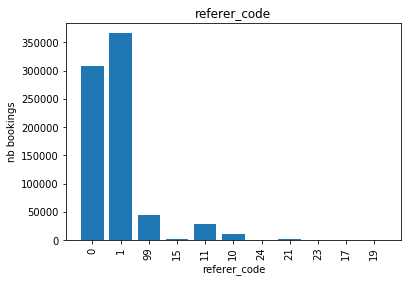

In [42]:
# referer_code
# dict_referer_code, referer_code_list = get_nb_bookings_dict(train_user_df, 'referer_code')

plot_dict(dict_feature_nb_bookings['referer_code'], 'referer_code', 'referer_code', 'nb bookings')

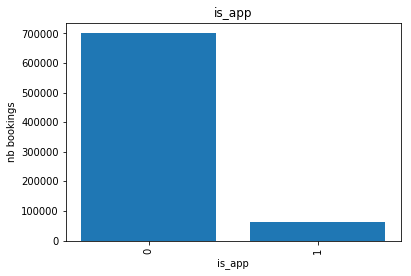

In [43]:
plot_dict(dict_feature_nb_bookings['is_app'], 'is_app', 'is_app', 'nb bookings')

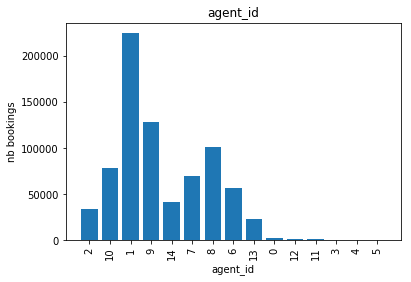

In [44]:
plot_dict(dict_feature_nb_bookings['agent_id'], 'agent_id', 'agent_id', 'nb bookings')

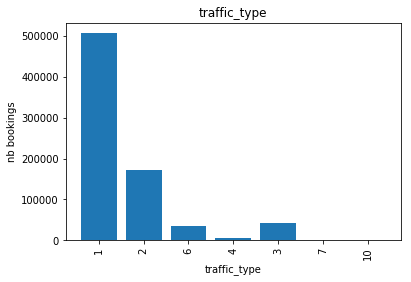

In [45]:
plot_dict(dict_feature_nb_bookings['traffic_type'], 'traffic_type', 'traffic_type', 'nb bookings')

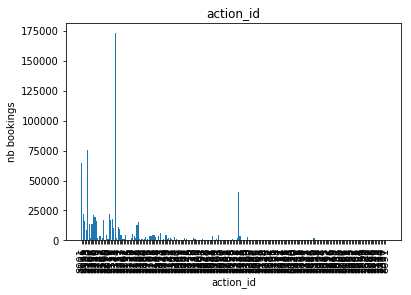

In [46]:
plot_dict(dict_feature_nb_bookings['action_id'], 'action_id', 'action_id', 'nb bookings')

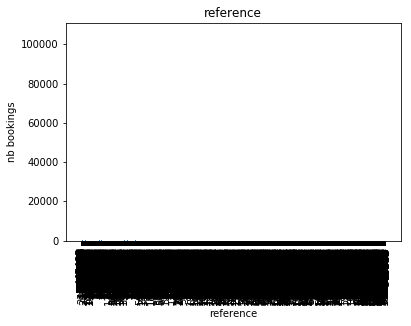

1323836 0
929835 0
0 105519
1 63900
447485 93
41492 1206
19003 24
19011 4
18987 47
7 1797
3 9113
262144 5192
219033 0
40 2075
19006 31
19033 51
50 1452
404053 641
60 10623
412 1948
212 6476
1276668 0
133783 0
6 10946
65536 7178
359221 0
944775 0
41 1560
34390 52
32092 1
38715 8190
488957 82
2 17671
569251 2
7569251 0
31 1471
51 622
271 1
1601 113
101 262
741 20
61 141
1483495 0
443275 0
81273 274
106333 0
7006 0
327680 887
10 5685
23 606
46574 84
48021 3
47784 246
75369 0
126698 0
31464 1303
1700399 161
435861 290
81855 2
2851434 0
12 890
97661 11
9409 2
47500 11
38648 293
4 10243
5 2165
40650 5
1292571 13
1733159 2
42695 293
41579 2053
1892793 40
40815 183
639556 0
2013903 1
5049732 11
343266 6
19408 27
1061406 3
1730671 0
2519228 0
6670696 7
-1 2099
1206484 9
1300299 457
3175518 1
552751 132
41018 2532
152032 188
19155 1
1048576 3480
31490 113
37942 0
1505481 0
1199098 1
343256 2
1132188 1
1721703 2
943093 0
2128842 3
939142 0
2707716 0
12459 24
95418 0
42060 139
46814 978
921913 7
9

2795374 3
125763 2
2762564 0
3070736 68
12481 11
53504 0
35248 0
4341186 0
34381 0
117138 0
46102 43
16674 32
46092 2
1345912 59
381821 9
1984271 0
1368188 15
5068144 0
382496 25
849071 0
12474 15
6676238 2
895195 68
46208 62
31111 0
1189096 1
47196 5
747196 0
38564 101
2401600 128
38147 41
1194564 5
1498811 8
1993535 8
38079 26
941218 27
47520 10
747520 0
18456 16
47104 131
46833 139
46314 43
8916 1
37803 15
1829849 0
1138062 1
6441936 0
1030368 0
1773321 0
86950 2
4788778 31
127413 16
4719990 0
1120727 2
1840605 0
1954849 2
5629938 0
945135 10
608921 4
1955737 2
7094 1
2048555 76
540311 6
6685348 1
909581 2
133377 69
46108 4
1771057 4
1034064 0
2844358 5
42185 8
1953951 0
12695 275
533666 0
42172 20
42161 12
2334980 12
3894412 0
2740526 0
1953645 6
1259411 17
2140894 0
82011 1
1499841 0
429 96
103268 26
447921 8
44331 19
443171 14
31898 3
1998865 0
15898 0
7209 4
15967 0
883513 0
7215 0
95819 0
36539 0
86490 312
1235728 0
163247 0
48034 8
880913 53
1974957 19
46284 8
1975977 1
13986 

436011 13
81011 15
8907 0
7144 0
535182 8
31148 21
1373793 0
31142 20
925179 10
3096462 1
79875 0
8086 0
34311 33
885757 0
55968 0
115628 0
71867 0
76724 0
58677 0
666161 0
9318 0
2700896 3
82548 2
33067 0
101231 0
45253 60
42309 5
94544 55
46615 29
530631 4
37225 0
1322948 5
1478153 0
2803 11
127351 41
971713 6
1075204 0
93080 15
42412 69
4064602 3
895221 6
1329542 0
13978 2
55303 3
965345 0
2556900 0
672441 0
2146252 2
40776 9
40319 92
1944267 0
44254 0
19102 0
31790 9
403963 3
1362376 0
5738592 1
1273719 0
3044462 1
915235 4
11547 6
147536 0
1263432 0
1534257 1
38158 120
343326 0
2381262 0
19558 24
719558 0
1742255 1
2797376 0
5096158 26
6771956 0
1194550 14
1189328 47
3897534 145
47051 50
25036 7
41067 2
14666 24
147493 0
2636467 0
26866 0
25022 2
313444 0
12100 1
6555 5
2297304 0
2627613 41
12200 0
1846357 1
14000 0
13900 0
11900 4
18700 0
15200 0
12300 3
1012269 0
41099 22
161971 9
16011 0
29396 0
27485 1
25911 0
2271110 4
31657 22
4503732 0
28629 33
1701645 0
28688 0
29267 0
145

520241 1
127290 0
101935 0
1417116 0
6888 1
10007 1
12978 0
13176 0
169988 0
1411809 0
38792 35
43251 0
2085174 0
2207410 0
1502627 0
4186046 0
84766 1
100608 4
139960 0
486769 47
34300 64
70545 20
74698 18
60382 22
378226 0
13845 23
13051 0
17485 0
15962 32
10520 1
31824 0
3068896 0
3503666 0
3374756 0
635296 1
2616804 18
83924 5
37581 4
119516 0
32876 6
5039114 1
33992 2
50916 0
46604 71
47678 21
342711 1
149632 53
7149632 0
1084 1
9672 0
189593 0
5184892 7
47605 127
46276 37
1780303 0
1208782 21
12449 4
1111229 3
1064938 10
3880122 0
100931 0
97162 0
373726 43
5434992 0
2155900 0
46980 2
499916 0
1387716 0
6814 0
1185296 0
971853 24
11317 7
46213 21
3053880 23
4721562 1
5490444 4
12450 1
914667 0
46077 26
12453 9
109972 21
41755 120
5624966 0
41759 0
4105914 0
449156 17
41941 57
46758 8
3147960 0
38421 5
2547776 47
11322 36
1246418 0
1548457 3
93655 0
96327 0
94581 2
2181048 8
94013 0
4721516 0
1236118 23
94008 0
3385362 0
13290 0
11202 0
97537 0
11236 1
10688 0
9036 0
8718 1
6857 2

344806 13
40845 12
47865 1
11432 0
137020 0
12598 84
1172787 0
37828 0
2048509 0
43354 23
39200 11
2067070 0
136668 29
100758 10
94219 0
94397 14
1950953 0
2700799 0
72700799 0
137732 3
3812986 0
73812986 0
46720 0
647376 0
2240238 1
2734855 0
93983 0
101760 0
96432 172
1823645 15
81351 0
2655934 0
3224445 0
2551614 0
75619 60
2804764 0
17105 1
4776560 0
896695 0
3851006 0
82797 1
95445 0
2625314 0
322781 17
46586 40
533531 0
42139 11
608956 35
635891 0
44036 1
44409 2
89394 4
73271 0
46864 5
12395 136
734361 12
1500 0
4800 0
48017 54
4158603 0
1975553 83
42321 2
819841 10
20067 2
19447 1
81984102 0
2632354 42
17674 0
47223 19
46264 9
131046 42
109879 23
2089486 0
40143 22
42473 10
46087 1
15674 1
1834703 0
7080 1
31700 4
117306 0
109134 9
101920 0
1332014 0
3801708 74
41611 7
5925528 0
11325 36
1046406 1
86549 4
57483 0
32692 0
84788 19
126957 0
817841 2
99539 2
99533 10
99537 0
99534 0
93979 18
208801 5
104241 0
506246 1
1951263 0
1698191 0
102547 3
1046602 0
1283371 2
2200986 0
9441

2003377 0
2671678 14
147353 0
1960797 1
1344966 0
38778 7
1075372 2
40825 41
777058 14
6246374 23
1974233 17
79447 8
104958 2
104743 0
925325 172
2005531 0
631276 0
5514486 0
951139 1
338551 1
2442803 0
7377 0
39652 0
111521 0
2817606 0
15431 7
7993 13
626421 0
1148378 0
14095 0
12009 2
11033030 0
626481 0
2286686 1
893339 0
1159624 0
179966 0
1478855 11
52768 1
41159 58
100939 3
41177 3
5134828 8
1275344 0
6636416 4
2636440 2
41296 4
107785 5
13851 17
1594203 4
88704 0
85336 53
88701 0
88778 0
82946 0
85544 0
117036 0
2105104 0
4627200 0
35082460 2
46370 12
12491 39
12454 1
5610026 1
12504 19
1314179 15
12499 4
446077 0
891083 1
12489 14
928489 0
647046 0
16196 0
1151807 10
85810 18
129451 0
4718558 0
557501 1
112645 3
85731 1
46324 36
3445690 1
2288548 0
1975531 0
1431934 0
138306 8
972621 0
587324 0
6066118 0
488949 30
1075630 0
19741 0
35088 0
36921 6
1969933 75
2048805 68
109894 101
6661 2
3996 13
1822 10
47146 37
212646 0
46285 10
46769 73
32034 1
1242863 1
1114112 17
19457 18
13

11947 0
10202 3
11142 0
12753 0
45562 0
188314 0
11276 0
10538 0
1708479 0
1395371 0
366726 0
4520902 0
46878 1
12417 35
11612 1
10605 2
148580 0
10873 0
4807190 0
13760 0
29118 0
5034044 0
2606410 0
2097426 0
4600616 0
4980142 0
3813044 0
4503378 0
1429918 0
2815282 0
2189180 0
16954 16
4055384 0
16858 0
2094310 0
6108 0
4765 0
11209 0
9531 0
46869 0
13223 0
1307520 0
8054 0
7786 2
5158274 0
1107072 0
2237544 0
5157796 0
5724442 0
1255632 0
1165507 2
1504001 0
1585753 12
3093 0
4073 1
5005 1
5941 1
11626 3
4847876 0
2025 0
3858 1
16142 0
7987 0
8591 85
10135 1
8793 1
212976 0
2809724 0
151972 1
16943 86
1766199 7
11638 2
13685 26
17507 5
633306 0
1954075 0
4057936 0
13941 0
39458 7
2800236 0
2066830 5
6251912 0
47130 6
929347 0
70352 0
3365342 0
87371 33
13832 151
5075824 43
14295 2
494366 0
1713781 0
1994519 0
46893 31
636656 34
2042475 65
3488846 6
660731 24
6626868 10
37998 21
47859 4
18913 56
5886214 0
38058 16
1940585 60
16717 1
9356 11
2899128 1
8923 0
46352 4
38777 20
41230 1
1

147690 0
3851044 13
18200 4
14313 20
1431302 0
928537 2
1141445 11
47952 3
533206 1
2302790 0
47898 2
719607 0
38283 36
11998 0
9292 0
8822 0
2548028 10
19667 15
3478150 0
538541 15
112221 0
86977 0
4055164 0
2168968 0
1476545 0
18271 1
15256 0
1649581 3
3137738 0
39008 0
946839 2
34823 1
561926 0
42380 0
46460 4
1098188 0
47634 1
48097 5
2719100 0
944737 0
86971 17
110639 38
99034 7
86920 14
110641 1
86965 0
86982 0
86914 0
1689863 0
1410702 0
40332 1
344411 0
86929 3
126855 0
19642 8
11628 0
99041 1
799041 0
4386490 35
635606 5
4577752 0
4072403 0
19164 9
370636 141
1622991 4
951133 0
2554298 0
1839291 0
1101740 4
1904737 1
127814 1
2546964 0
637331 0
47029 0
46433 6
1010603 7
604046 0
47857503 1
7328803 0
1862973 0
19763 5
47829503 0
968573 2
46511 0
19698 0
1074524 0
3920003 0
47820103 0
47819 26
42091 2
638456 0
151993 0
47204 9
19812 9
2157274 19
48044 10
651226 0
2547522 0
4105512 1
94208 34
995663 15
1539663 0
94231 21
131697 0
1046802 0
132031 27
904631 4
2129348 106
127347 1


28147 0
32445 0
38217 1
1941249 1
1863025 0
530301 0
530306 0
2606492 0
2683040 0
8751 11
85551 4
1658335 0
2168990 0
767596 6
12423 113
99096 2
48074 34
1725957 44
212428 0
112421 2
1847181 1
1835419 0
2285638 1
312445 0
112441 1
312357 0
18611 84
3066 0
200216 1
23714 2
11572 2
8825 1
125622 1
138883 9
1954777 9
219701 8
4592904 17
2231024 0
2281522 3
70707 0
48071 41
46884 0
321221 0
10663 0
6520 1
48061 5
2082232 5
4525052 0
18618 2
80575 0
597321 6
1975831 5
46419 11
3472582 0
11812 2
14178 0
16499 0
6552802 0
46565 6
94137 4
2196068 3
2753236 1
1794871 4
1775771 1
31483 0
56961 0
470246 2
1633267 0
1052976 0
1974495 0
4178092 0
29786 0
7055 1
5221268 0
1324179 0
41656 1
1180360 0
6250544 0
12561 11
2013845 0
2092426 0
60355 0
2417790 0
63849 0
1436523 0
71436523 0
122328 0
16052 0
11594 0
11201 1
11888 0
11790 0
405506 39
12769 2
13214 0
13125 1
14105 0
2339834 0
534036 0
15170 0
14009 0
20979 3
47241 0
1727585 1
147248 0
2547430 0
3825486 3
6477 5
6449 2
786 19
5017 3
1774591 2


4138520 6
127768 0
55434 0
3197216 0
5146892 0
102067 0
8023 0
1710159 0
102301 0
35083 0
2381174 34
69680 0
947191 1
37180 0
56272 0
41792 25
78846 9
131814 0
31977873 0
9720 1
4207922 0
1936221 0
2243572 1
1871301 0
915183 7
720181 2
639746 2
1335700 1
47889 14
1402005 0
47631 1
1094288 0
6954042 0
2053023 0
75081 4
3181018 0
175013 0
39881 55
565516 17
4608850 0
17701 1
17608 1
15452 1
12959 1
5790938 17
4380406 3
448626 0
46442 1
746442 0
147210 0
69095 2
1265445 0
2262960 1
4598020 0
1892715 33
37944 1
23380 1
4101803 3
23530 1
112931 0
11988 1
112846 0
94731 0
112891 0
73397 0
428146 0
9473103 0
11967 25
23430 0
11776 2
11899 1
100693 1
138568 0
1463931 3
1849811 4
1187412 0
13039 10
1345728 12
489047 4
47938 1
2800250 1
2635578 4
6452330 0
2190 0
85733 10
98082 1
182374 0
4905 0
3258 1
2465 0
3812468 2
147266 1
42285 0
84273 4
44323 0
3409236 0
95941 0
45765 0
1161379 5
442656 0
554236 0
533616 1
1164969 1
1279207 10
4525800 10
14483 0
11926 5
4492646 0
1109210 0
5007568 0
14940

520152 2
111788 0
34914 0
2077876 1
46266 9
108028 0
152785 0
1586099 3
1306156 0
1306444 0
71306444 0
80561 3
780561 1
8244 1
5508050 0
15712 1
756166 0
606896 1
2751514 0
4514058 0
104310 0
100805 3
1012389 0
39550 28
4589050 2
22375 0
166031 0
342096 0
37577 0
127010 0
1367462 9
19071 18
7539 0
100757 0
1840095 0
1365144 0
198331 0
39979 0
1840127 1
85328 5
73263 4
86479 2
88874 2
85225 3
13961 1
9256 1
456336 8
110620 9
1215736 1
762431 2
2581894 2
4266880 6
3519660 3
71909 25
58303 1
55214 3
1156121 1
126552 1
94403 0
8764 31
1985059 0
557404 0
1357046 0
3764232 0
105656 0
126839 0
1534573 1
19657 7
132259 1
151893 27
7496 54
136986 6
11091 1
34837 6
11802 0
13669 0
3995508 0
11596 0
17948 1
3353 0
11016 0
32455040 0
7420 0
13099 0
50802 0
51067 0
12239 0
152407 0
6298 2
12076 0
219 0
5192010 0
1990741 10
46715 21
1736665 0
19762 3
2631860 0
8078 0
78078 0
77932 0
719157 0
2552638 5
46858 26
128297 1
1376079 0
747121 0
46806 43
2669252 2
86475 1
342436 5
488241 9
1255063 0
3110260

104569 0
73512 0
25170 1
8048 0
4102552 0
41494 4
2709968 0
1847159 74
344766 4
1272638 2
2594617 1
2468596 0
2327050 0
4797452 0
40666 43
40739 0
7129 1
40620 0
149234 0
149220 13
40251 0
3376848 0
2075900 0
1830611 0
85545 0
894647 0
7894539 0
343066 0
138878 0
1410460 0
97519 6
94408 0
5751696 0
1216614 17
19368 198
153082 35
1334404 0
76977 0
59782 0
96554 0
1939525 0
3182764 0
85148 0
8164 13
14008 0
43302 0
8695 3
67431 0
3430003 1
34310 11
12191 26
70317 8
164360 6
3431003 1
16298 1
58155 20
57804 3
61965 14
665571 4
19057 1
40081 16
2006485 0
742166 0
16118 6
42074 1
42232 13
3812500 0
805951 17
1249391 1
106257 1
2439240 0
42228 5
100613 2
112539 0
112523 0
35564 0
35582 21
1816207 1
138638 0
920845 1
13148 2
78621 0
8663 0
15021 1
924723 19
343136 0
5717156 0
1816229 22
149302 2
7149301 0
6453668 7
1556707 2
5475120 0
422341 0
1858317 0
947023 0
2142402 1
9688 1
2071852 97
45755 0
96190 0
991633 0
547162 4
1980949 0
4775884 0
4159914 0
47821 10
510940 4
1178722 2
1736301 2
42

6376 3
46780 17
2583740 1
2091960 2
47293 0
385807 0
20989 2
11388 0
13389 0
134272 4
14430 0
15626 0
80507 4
9350 0
19126 2
322736 0
1944977 8
40067 1
138029 25
3150692 43
1713407 0
99928 0
1418553 0
1273765 13
1123606 6
10469 1
4333 0
1540815 1
4084600 2
893479 0
2552674 6
1061722 10
604331 0
4064518 0
1411204 1
3208258 3
2719012 1
97302 0
533166 8
1376342 15
24708 4
907927 11
24731 2
1944681 0
1486789 0
5207720 0
129124 8
3339676 0
4344898 0
4251952 0
3001224 0
404213 5
1998283 0
15436 0
529831 0
128878 0
149279 6
15485 1
3789916 0
847061 0
166432 0
38808 12
1403680 1
796010 0
630741 0
13416702 0
7502 1
107277 4
130964 0
137440 18
4241803 0
197507302 2
24179102 1
1670473 14
3369500 0
640951 0
1863283 0
1361350 4
1553537 0
5875400 0
15735 1
1243587 0
5495466 0
1077590 0
4531 1
1120211 5
60369 4
66177 1
8690 0
63974 0
66175 0
57180 7
2628431 0
49990 0
147278 0
34266 0
76891 0
68147 0
3903606 0
76237 0
57541 0
34256 4
75778 0
64288 0
5154988 0
4489640 0
86585 0
6769 0
1493795 0
99063 0

85768 37
1061446 1
1100826 1
520156 0
568440 0
6499 0
110000 0
2817 1
5781052 0
48585 0
49790 0
40699 11
1663531 6
14387 0
2741 3
4202503 0
1356914 11
118818 1
46590 0
5171082 0
947021 0
1782 0
12675 0
1362506 0
2016409 0
5057522 0
608586 10
635471 0
392226 13
107809 1
39982 0
1942727 0
1499149 4
82179 0
2239572 0
8398 1
1385769 0
49110 4
7318 0
11501 2
7436 0
7690 0
84220 0
150905 0
89417 28
16146 0
31855 0
7529 0
2001507 0
11724 1
11809 1
11798 0
4456094 0
4114562 0
31846 2
1954875 0
38765 0
1519919 0
1711457 1
12252 2
99846 53
12063 22
48883 1
50087 1
199846 0
712063 0
1095754 0
534306 2
1267436 0
55237 7
2262318 0
15272 0
3881926 0
4594016 0
4115050 0
96909 6
6981 1
2179876 0
45352 0
21253 0
542001 0
112011 0
2121444 8
60318 4
12239640 2
664506 20
2501720 17
946997 0
1373957 0
47531 29
1858347 30
421256 13
12559 5
1197428 1
3992903 2
6029070 0
952079 5
19235 0
1462873 0
603766 0
21011 0
24042 0
47671 17
392111 0
16359 0
1843909 35
496211 12
840476 2
1101140 0
929419 2
98113 0
23371

3834370 0
1327808 0
1180302 0
46962 7
3221 1
14083 0
147252 3
45475 10
13410902 0
17410 0
845436 0
130734 36
531344 0
151034 0
1047274 0
43220 0
2549298 0
7365 0
11610 2
3069220 15
134177 1
138458 0
4343582 0
140630 0
31144 0
1839871 17
1334318 0
1181062 2
3184313 0
6658194 0
1769855 0
3160420 0
2683010 0
1207734 0
18545 0
19707 0
4543786 18
18034 0
1269576 0
1032896 0
86497 10
767361 0
148788 0
152730 0
689051 0
121719 1
932179 0
3455 1
1279 0
21899 0
448576 1
47501 6
357 3
186942 1
86942 16
796 0
204811 0
3637816 0
3173294 0
158710 14
1362612 0
137802 0
5797110 2
5398 12
14670 1
15463 0
55083 0
1830929 0
1032682 0
608951 0
2020375 8
400326 0
33619 0
82012 0
2350334 0
38422 0
6471390 0
108416 0
1101536 0
1179090 10
916199 14
6270192 0
5218700 5
12376 0
16023 3
5134 0
3530088 0
639881 8
529741 1
2157224 8
5973614 0
40727 18
224796 0
688541 5
81264 0
967965 2
5808622 63
129891 0
4101818 0
2394602 7
117719 0
1553901 0
3143010 0
148058 0
6825710 0
5884602 0
6719508 0
128248 1
97576 2
3727

711 0
3816838 0
4066312 0
2808602 0
20984 0
934977 1
798506 1
20969 1
20889 17
2575916 0
20763 0
20842 0
45327 0
84269 0
915075 0
45624 1
4344298 0
20870 2
1345274 0
848431 0
3252518 0
20960 25
20884 0
1708775 2
20785 0
21034 2
1964067 0
3850642 0
20784 0
1342010 0
2489186 2
20726 2
13095 0
24098 31
20883 2
21000 0
21039 6
81981 0
134692 10
1635895 0
20819 1
2304784 0
1006947 0
20903 0
20863 0
141253 3
154039 0
210481 0
321911 0
1975069 25
86943 0
174562 0
128105 0
347926 0
1286227 0
1426466 0
654 13
346451 13
6234924 0
71625 0
2269716 3
16870 1
6032 1
6548 1
7139 2
17449 1
34489 9
59577 2
34716 3
74275 1
34894 3
56782 1
34893 3
78529 2
34794 74
69331 4
34269 4
408281 9
1179006 1
1367986 17
3895044 18
57650 2
68906 2
77336 2
5062386 1
833996 27
75387 3
1135361 0
1630259 0
1934001 0
6170538 0
6299680 0
5213624 0
1138982 0
2226736 0
1774493 0
147238 0
33070 1
40634 0
73476 0
1771315 0
11699 0
161960 0
161285 1
161421 0
65065 0
230161 0
492536 3
710871 0
122630 0
732091 0
109684 16
49216 

4962488 0
1720897 0
436286 18
19213 11
1201982 0
4616980 0
132133 0
4607706 0
50925 0
34983 3
946677 0
1335708 10
629791 1
1908537 0
951173 0
1241355 7
33522 0
46740 19
2398028 1
1829103 0
152470 3
1251000 0
1278058 0
5844 0
3892890 0
1329277 0
3977394 0
6926202 0
1238405 0
15593 2
2729124 4
635531 0
149280 0
40688 4
152998 4
600 1
15563 0
37192 0
38328 9
40457 0
2224294 0
94187 0
2898774 5
38376 0
136034 0
127246 0
1816103 0
3478314 0
39660 0
2325686 0
3385042 0
54067403 0
13019 0
15149 0
238976 2
112260 0
1347284 3
4447192 0
34645103 1
15564 0
91466 0
1218564 0
2670316 0
1560358 0
87063 0
91640 0
916427 0
828316 3
147633 0
157385 0
91523 0
165320 0
2318396 0
2301572 0
173967 0
81608 0
94269 0
441141 4
152149 22
3999950 0
534081 0
769238 0
927729 0
20327 0
17890 0
674856 0
2254338 1
124568 0
344836 7
39139 0
111035 10
3769748 52
987329 59
117864 0
232146 0
16361 0
101721 0
5517904 0
1014551 0
6819284 0
1050296 5
110860 0
148490 0
120946 0
717706 0
739402 0
739401 0
485931 0
4558236 0


1757773 4
102951 17
470296 2
628986 0
1569787 2
141271 0
1487351 0
1935849 5
1562987 0
2900668 1
3979002 0
1095858 0
776698 5
895023 1
1307123 0
3194722 0
530136 0
914665 0
6452248 0
2087272 1
1309724 10
1818905 25
967073 0
1182896 0
4606474 1
5967862 1
636836 0
1718805 0
41119 3
1700047 0
533816 6
1075408 0
534006 0
5216908 0
5127708 1
2901326 14
1769073 0
552956 0
4062720 0
3367376 1
3410220 0
1835991 0
6538100 0
1164790 0
1309712 0
2043637 0
3061966 0
2142714 2
929391 2
99653 8
54726 1
99046 0
587362 0
4825 0
1273854 1
1152088 7
638686 5
967761 0
3395090 0
46249 5
1891027 0
785810 0
18590 5
3069951 0
1361426 0
2098806 0
402536 0
35429 27
2851792 0
46776 3
1144154 0
88069 0
116046 0
42615 0
3390980 0
2256704 0
15711 0
39578 0
2748877 0
3133762 3
967983 0
2861096 0
1567935 0
1886389 0
2225310 0
2772376 0
38415 0
683126 0
4749348 0
3493164 12
1608743 0
3113710 0
5595062 0
39173 0
2548708 0
1388963 0
3147832 1
1954239 0
81133 0
35859 0
1386245 14
49338 51
4219360 25
101424 0
99186 8
148

2786328 4
1314234 0
530736 0
4493756 0
82708 0
7121 1
3151590 9
14378 8
85529 1
102766 0
63812 0
102750 0
15580 0
13663402 0
8291 1
13404502 0
8317 0
64693 0
69651 0
79255 3
56469 1
15871 1
78335 0
767381 0
60866 0
79130 0
15826 0
3864590 0
61212 0
63878 0
102768 0
67421 0
49786 0
2963286 14
2968972 0
2954094 1
5610596 3
2859308 34
2013737 0
1237872 0
1847067 0
530806 1
5163226 0
5436784 0
74004 4
7400403 1
22594 0
2043897 1
795061 9
1856877 0
385431 0
165389 40
2700854 1
533766 1
2851762 3
1105612 0
2208946 0
747984 0
737121 0
77202 0
116961 0
76865146 0
77473 0
2291626 109
30983 28
754711 3
30956 70
30977 6
30960 33
30955 39
31008 1
30995 18
786236 1
125696 0
551211 0
38377 0
95708 0
138119 0
115437 0
1457845 0
94180 0
16713 7
99502 0
499501 0
344096 0
928703 0
5736976 0
2848956 0
991243 17
1161804 0
499507 0
6053184 0
932727 0
99503 0
688346 0
960639 0
2730498 0
43932016 0
2650478 0
1278278 0
2215490 0
3788212 0
3763326 0
1288464 0
5866928 0
3552232 0
2218462 0
1024472 0
2152918 0
1

32628 42
3849966 0
150188 0
2326546 0
1553957 0
2176470 0
1429092 0
6036662 0
5082 0
15654 1
26439 1
14862 3
85098 7
11394139 0
1164965 0
1494597 0
12853 1
11467 0
13379 13
1251752 5
16661 0
1335407 2
633336 6
11593 1
23631 0
23074 0
48003 0
3962203 2
36481603 0
9485 0
9481 0
93848 0
5838682 0
8883 29
3532 0
3059742 3
128100 0
51126 0
1251820 10
127837 0
48373 0
3532528 0
4018188 0
248761 0
5997402 0
1475903 0
104094 0
36601 0
966705 0
855041 1
881271 0
39798 0
436026 0
3389519 0
6813038 0
958645 0
94243 0
1652457 0
1558477 0
94120 0
2956944 0
4573072 0
7074 1
1094248 0
1669927 0
3369859 22
25773 0
982929 0
60320 11
61518 0
60996 0
354706 0
56238 0
8055 0
3818482 0
1975113 0
1735485 0
101465 0
7983 0
101463 0
160908 0
66838 0
64406 0
150336 16
101467 0
163166 0
86640 0
23641 1
32542 0
30402 0
48859 2
36083 0
2653027 1
2701832 7
691871 4
1105898 0
4044040 0
2348598 1
49979 0
48957 0
3133614 0
3510 0
3998 0
3876 0
2254840 0
49018 0
4653128 0
2954744 0
3121852 0
2966836 0
3093046 0
101283

20674 0
152418 3
20752 71
20677 1
5738460 0
20721 0
20664 1
20686 0
148466 1
129412 1
100295 0
3152296 6
32569 0
432569 0
37767 0
898801 0
2021149 0
700046 0
96242 0
4269244 0
96361 0
5008542 0
37766 0
124314 0
752946 0
3485636 0
963311 0
7037150 0
4790 0
5929 1
4142186 0
45432 4
1825395 3
1513939 0
4435 2
5796 0
2348476 0
51853 0
6867 1
3203368 2
4569256 1
8150 3
5227 3
1892149 1
7891 1
1868603 0
947257 11
893459 0
47286 0
1100938 0
631226 0
631436 21
4415222 2
555 12
361011 0
559 0
96638 0
6598734 0
101087 0
21256 1
326451 0
46305 77
2049879 3
3048926 0
4174222 6
10754 0
2216990 0
38470 8
2595507 0
2654346 0
121929 0
2399 1
5813612 0
20260 0
17801 1
3132924 0
1053528 0
2470346 0
38475 1
1652929 0
10669 1
1165624 0
94910 30
38185 6
50486 0
16274 0
18731 0
137558 6
5837014 0
6606 0
5662 0
4955 0
8140 0
6684528 0
7371 1
5889114 0
6962174 0
4359498 4
11821 0
927799 16
7927799 0
71455651 0
945057 0
780884 0
938894 0
1329225 0
4864932 0
523191 0
100371 2
5122538 0
4480350 0
43218556 0
1471

6317338 0
343721 0
182856 0
7599756 0
1100804 2
7718 1
242731 1
1359904 2
1750567 2
2772571 0
2342000 0
808626 0
84633 0
7495 1
3225882 0
1992419 0
96357 0
4524270 0
3167422 0
443511 0
35421 12
1822881 0
49384 0
12137 3
85874 3
15583 1
42393 0
383 0
4066703 0
830826 4
1827551 17
2417642 0
7142 2
45100 1
10928 0
17373 1
1707093 0
536936 0
138501 1
2862831 0
9391 15
46534 0
80384 0
32051 0
6030658 0
53761 0
988347 0
7149105 0
146531 4
1113623 1
147396 0
923861 0
12505 28
349651 0
69529 0
3183529 0
22268 0
3431874 0
21687 0
715830 0
4709426 1
72669824 0
35139 0
1284802 0
1120725 0
66923 2
74008 0
13990 0
77672 0
118488 0
96917 0
1074958 2
47750 36
2851678 0
1950721 8
2835986 13
4228446 0
3802052 0
40003 4
3084346 0
2845 0
3132970 0
3132299 0
4067270 1
712603 0
2148772 0
4199703 0
3124582 0
2430366 0
2335026 4
404786 0
4532338 0
9735 0
1828875 0
2308456 0
1081338 1
6692704 3
6466506 0
103158 1
3044424 0
34437 1
1702143 0
2110036 0
3477874 0
101457 0
151724 0
4920270 0
96910 0
2784493 0
926

1987847 3
1398780 3
126963 8
771233 3
55095 0
105449 0
105168 0
1535777 0
54966 0
16363 0
85313 0
85315 0
122615 0
1486853 0
48441 6
94995 59
101790 6
105588 26
105596 0
101765 2
10222 1
2738250 0
1723937 0
84613 0
3383774 0
1815379 0
20395 0
2054128 0
17224 0
405846 0
9098 0
532878 0
113207 0
31041 0
1169180 0
4122860 0
2100388 0
20253 0
1019993 0
1289508 0
1018593 0
2235850 5
841571 42
45080 0
1209338 0
4100794 0
928471 0
3449360 0
45918 0
149172 0
1238078 0
1270622 0
2181900 0
14515 0
3592 0
1310922 0
1453 0
1816115 1
2546992 0
3507634 0
635331 11
712513 1
533761 0
4169352 0
3103003 0
2122560 0
2066828 0
1366452 1
19547 1
2547529 1
1074352 15
3583002 3
1935805 4
38306 0
74187 0
2723894 0
4013712 0
1502913 0
448136 0
7448136 0
4807862 0
18614 0
41042 5
38363 0
38051 0
6348292 0
2121808 0
2782498 0
96090 31
911107 0
32664 4
1668939 0
85196 25
119798 0
933177 0
1087968 0
1348948 0
459983 0
896251 0
834361 0
553326 0
1647905 3
1113934 69
128684 0
1523339 0
1849931 0
1349314 0
1265329 0


520671 1
7395 1
3244 2
16739 3
9116 1
34531 0
71899 0
1937033 0
4200752 0
4139488 0
83964 0
6230782 0
94164 26
6609864 0
6663006 0
826176 0
47651 0
1627579 0
967467 0
35736 2
33076 0
2151050 0
1129191 0
15973 1
2170982 0
1164891 0
135558 0
322031 1
1966483 0
886881 9
415933 0
1078670 0
4092722 0
2128984 0
5708132 0
15751 1
365376 0
8921 4
2825692 0
127220 0
33894 2
3523616 0
150799 0
449061 0
102490 0
558726 0
1941383 0
350511 0
39701 0
44884 0
2124350 0
72124350 0
9339 1
2348818 37
110079 23
11355271 1
20011 44
20453 68
45625 4
3183112 32
20301 3
45104 1
3134528 7
17252 2
1775935 2
150970 27
85575 49
1468793 0
1950691 0
74811 0
75274 0
1788951 0
4647736 0
21442 1
344866 24
3143198 4
151322 1
2299260 1
489079 0
4827762 0
3444148 0
1557833 0
124738 0
3393446 0
1143822 1
29119 0
5015390 0
40133 0
52636 0
16907 0
17348 18
12169 1
15695 0
540076 2
6953 0
1695621 0
3136644 0
396596 0
5589372 0
6745 1
1097072 23
1309734 0
785725 0
7931753 0
785808 1
439036 0
1140553 0
111832 3
907833 0
11336

57155 0
73576 0
73577 0
395151 0
75456 0
66427 0
1337264 0
75462 0
67126 0
942587 0
5101268 0
9437503 0
19244 0
4072303 0
2546960 0
54706 3
931957 2
7063980 2
936875 3
2829394 4
12829394 0
1189062 0
77115 0
2809726 0
532426 0
122613 0
530386 0
41007 0
41152 0
5721184 3
4062880 1
5166096 0
1840187 0
25566 0
4876860 0
157604 1
23650 28
41834 12
16029 0
14627 1
16330 0
2019639 0
6383768 0
629396 0
4059372 0
522296 0
85523 0
5913 2
4515072 0
17946 0
325216 0
89031 0
54563 4
54720 2
54731 1
456427 0
38257 3
128466 0
1257751 0
4605858 0
1482717 0
2063372 0
42063372 0
2558732 0
6177190 0
4043 0
973675 0
12707 2
3107804 0
5832330 0
52013803 0
48890 4
4791854 0
117383 0
2196752 0
1315142 0
3169652 0
113401 0
39572 5
5052836 0
4589172 0
178357 0
45005 0
1362755 0
1104934 0
7633541 0
5970482 22
1373254 6
137325402 1
1309888 2
1342878 1
1135648 2
1839423 1
38508 0
7161450 0
3556814 0
80454 1
80429 0
100668 0
3158204 1
1263472 1
6435 0
2416842 0
3467440 0
1283702 0
6448820 0
2295624 0
490206 0
1150

6381 30
1991009 18
51137 1
6402 44
4188710 90
74188710 2
2634042 50
245856 7
6377 1
6408 5
51114 22
4901992 1
52532 1
71283181 0
71847869 0
7360981 0
74387116 0
55328 0
1559091 54
152327 0
7152327 0
75196118 0
78893 0
3523812 0
37576 1
1488061 0
71488061 0
73523812 0
4127294 0
2045899 0
2826896 0
14473 1
17895 0
3250603 0
17209 0
1710139 0
43273 0
12370 0
16778 0
11836 1
19182 0
102985 4
17333 1
726956 0
108562 0
991737 0
88225 0
4361946 0
4754014 0
522056 0
3212630 0
10568 1
2176966 0
4103266 0
4606 0
13520 0
15890 0
894505 0
1414900 33
1474037 0
934773 0
72586 0
3396848 0
1074 0
835 0
2396140 2
42270 0
45578 0
11217494 1
2706618 0
1425027 0
2258342 0
4969758 0
904151 0
150712 1
3230432 0
928957 12
3980588 0
3486978 9
1472225 1
1851659 0
1537351 0
1837613 0
97881 0
7148247 0
3850452 0
36484 0
509618 13
9153 3
18042 1
4981518 0
4555282 4
2632632 1
3502736 5
18149 0
5428974 0
12698 7
2219718 0
6461 0
2307054 0
2395542 1
2013303 2
2063748 4
713111 0
1560163 0
780887 0
1977253 0
1286694 0

1986689 2
3766156 0
3895350 0
4009042 0
3198299 0
1483579 0
3049308 0
6065082 0
5974120 0
3910198 0
1351828 0
2761520 0
4528818 0
2110730 0
4174254 0
3974974 0
1369754 0
2033083 0
2650642 0
4909790 0
2379295 0
496041 0
2033799 0
1012327 0
217506 0
1988391 0
2925630 0
6806264 0
4476182 0
3376588 0
2847852 0
2600412 0
2227312 0
2509287 0
2026377 0
1576651 0
1837927 0
508856 0
1980859 0
1552745 0
2834278 0
2106648 0
3135186 0
4641754 0
4864664 0
1499865 0
3758982 0
5120064 0
6162178 0
3135192 0
5206750 0
2049081 0
3898922 0
3386513 0
2293936 0
906231 0
3833970 0
2596352 0
3842450 0
1428752 11
2600422 0
2380180 0
607051 0
2642936 0
2804808 0
3184674 0
6278718 0
3365500 5
5760572 0
2884035 0
21792 0
1329303 0
3143985 0
8762 0
1291960 0
1351143 2
33778 0
96147 0
7744 0
1104564 1
1328473 0
1973555 1
2476984 0
2570280 0
1421653 6
4522310 2
85495 0
90285 4
1412892 1
948541 1
634981 0
1435322 0
322716 6
2282026 0
1862931 0
1535943 2
152908 0
108092 0
4118928 0
105720 22
6024454 1
94710 0
1165085

149046 1
4716820 23
218815 1
947785 4
6177978 1
4720 0
3847271 0
106276 1
887807 0
5952 0
3487230 2
4584060 0
2841146 0
556130 0
1556130 0
4892026 0
6603808 0
6798762 0
510944 7
193506 5
3136538 8
628864 0
9032 1
3599 0
960623 0
1628864 0
3971620 0
1415192 0
101155 0
101148 6
277569402 0
714236 0
3182672 0
350136 0
1646483 0
3391580 1
1131579 0
1094284 0
11227 4
12627 1
1484179 1
2418578 1
1328912 0
16861 0
34996 0
50836 0
3212570 0
71314104 1
2772 0
116037 0
27831 0
6552 0
18320 0
18577 0
18892 1
16477 1
19312 0
2049931 3
631611 0
1335721 22
103013 1
5750396 0
103014 0
5819202 0
102324 0
4431503 0
3549198 0
4556756 1
146156 0
971691 0
527292 0
2426364 0
1162881 0
147258 0
18107 1
7777258 0
9229 1
7196 0
8823 0
2031511 0
1359638 0
38281 0
6515292 0
3191403 0
5206630 0
1570279 0
1834505 0
93088 0
556144 0
4112394 0
2782822 0
1480393 17
13908 2
10248 2
3768754 17
10085 1
10329 2
36836 1
31185696 1
763006 10
754271 14
3114182 11
4050476 0
1988039 0
3840234 0
3385230 0
38070 0
241303 1
141

2441640 0
6371768 0
4764096 0
5164442 0
4428940 0
4889954 0
6730356 0
345526 0
4461892 0
3087732 0
2021715 0
6570774 0
302696 0
776783 0
1381106 0
1218858 1
1176819 0
10509 1
7673 1
148878 0
930529 0
148857 0
1650097 0
1103670 0
4078584 0
1829285 0
2038345 0
89508 0
4631220 0
3215072 0
557221 0
38557 0
40066 2
556711 2
413526 5
1206849 0
2755814 0
1543189 0
1354998 0
18377 2
2006551 0
14440 0
73894886 0
1346982 0
840726 0
67140 0
2391591 0
520148 0
1160348 0
148369 0
481126 0
98672 0
128354 0
4347962 0
866986 0
1946855 0
81675 1
4793702 0
165133 0
4319040 0
65580 0
1356302 0
5701374 0
16770 1
111228 0
4809626 0
100690 0
241726 7
12632 2
1723673 19
884259 0
1769501 0
637606 0
64834 1
66495 0
4242404 0
74242404 0
1315332 0
1211588 0
2849772 0
1111932 0
39219 0
1362574 0
91661 0
351816 0
808666 0
127423 0
153945 5
149410 0
2799241 0
2634046 0
1606721 0
95458 0
6685758 0
81944 0
4599006 0
119269 0
1324382 0
636076 0
90809 1
184801 1
4044146 1
167042 0
5434024 0
2707140 0
38230 0
6459334 0


85620 0
2560893 0
5137396 0
5647486 0
154505 0
4959752 0
2974452 0
46199 0
88731 1
10493 1
7598471 0
10335 0
9634 1
2672130 0
9062 0
3831020 1
10916 0
10701 0
71168976 1
3365719 0
5095256 0
80355 1
629026 0
608616 0
126897 0
1133447 0
11116 0
16530 0
12141 0
4624538 0
2825822 1
1668305 0
20731 0
45095 0
1587859 0
195526 0
950321 0
75618 0
2020793 0
63908 0
45046 0
6273696 25
212601 14
632996 18
1349162 0
133552 0
3190 0
383501 0
2925632 0
1771769 0
438341 0
511210 4
46984 0
6800458 2
66786 6
17851 0
16680 0
62759 0
1350872 0
932619 0
2602325 0
6712722 0
12737 0
1117765 35
12733 1
248146 0
941661 0
5037414 0
2045619 8
31863 0
12883 0
1109206 1
20879 0
1478553 0
432106 0
6183582 0
447793 0
1084894 0
94676 1
1749471 0
1138069 0
97018 0
6800796 0
242206 0
1854659 2
150325 1
30954 3
921653 1
31854659 1
47228 5
7921653 0
6693514 0
11588 0
1106318 2
5736620 8
75736620 2
5932 1
1249417 1
15215 0
18423 2
20096 0
3180876 0
1464249 0
1307684 1
81681 15
733921 7
487076 2
2020891 2
5473 0
2810 1
96

7147708 0
2003537 7
2515780 0
41411 2
1690659 0
939446 0
162791 0
1101474 0
746986 2
73367950 0
75070840 0
1974843 0
3836986 1
102499 0
38891 11
75801 0
1840419 0
41743 6
1939961 1
2568499 1
1840165 3
196111 0
55777 0
1334010 2
1100834 0
1764943 0
74330 0
1352756 0
325881 0
3165786 0
668686 0
668676 0
1479417 0
105414 0
1420876 0
2877536 0
5889170 0
1479773 0
3989164 1
2052165 4
2288154 0
2179074 0
1517625 0
930129 0
7921879 0
3756846 2
635796 1
47323 4
2051619 1
1400418 1
4702594 2
4113824 0
1362306 0
50615 0
8640 0
660986 0
2677706 0
1373242 0
5758090 0
5746552 0
5125 0
5069 0
1319540 0
127373 2
3150188 0
39275 0
39642 0
1029072 0
2672336 0
3174426 0
11004 0
70789 0
259329202 0
1951317 0
1016731 0
880965 6
2617738 0
1489305 0
1768777 63
667516 10
105480 24
326036 19
667616 54
7388703 2
455937 9
976617 217
105471 111
45593703 3
2499384 61
2124456 25
10108803 2
109166 65
101964 16
7387503 1
531170 16
429681 65
109299 328
191946 2
7399103 1
668516 7
74014 5
1981113 51
105399 59
7401403 

3184194 0
3105494 0
89121 0
21257 0
3106654 0
83115 0
5772804 0
5870292 0
89036 0
89057 0
3971478 0
89120 0
2557457 0
6144 0
10040 0
10922 1
897607 0
1651415 0
207076 0
18056 1
21590 1
31514 0
1668547 0
1943471 0
2493768 0
1773479 0
1776045 0
1140742 0
1668553 0
3534848 0
2702768 0
42702768 0
6867234 0
4341606 0
1943035 0
39927 0
5180746 0
171412 0
92332 0
2051977 0
1075476 0
102851 1
2688188 0
548951 0
79356 0
178637 27
18986 0
22140 0
167913 0
128080 7
110871 0
37384 0
122959 0
127594 0
1132391 0
1189408 0
37453 0
827326 0
6961 0
5139522 0
2566464 0
6865 0
5140314 0
37390 0
2128484 0
3717 0
5846 1
930363 0
4043784 0
3639276 0
1205362 0
4663000 0
1717421 0
12466 1
94291 0
30837 0
765641 0
87541 0
443726 0
1487683 0
20238 1
6174 0
3459 0
10245 0
11630 0
1704365 4
2442460 0
404876 0
747396 0
5483650 0
6865892 0
6468984 0
2900590 0
80584 0
14914 0
16191 0
16233 0
15127 0
1724301 0
2184194 0
3570974 0
2559474 0
2160884 6
1042252 4
6394250 0
2269616 5
634471 0
1078770 7
6473408 4
3146030 2

489626 1
94856 0
104425 0
982973 0
4615190 22
4051444 0
888895 0
3065763 0
127976 0
754846 0
134610 0
1362778 0
4558 0
1202384 0
3133773 0
147941 0
18382 6
2097214 0
2692596 0
50757 0
53866 0
53932 0
939504 0
1319941 0
12372 0
980283 0
45404 0
3508400 0
20265 0
2901338 0
5996 0
6121 0
31728 0
94984 0
447527 0
5810 0
447513 0
8338 0
6397 0
5062 1
1237065 0
1079452 0
111710 0
64517 0
23463 0
1588367 0
628661 0
90 0
9168 1
71852167 0
1858247 0
1916527 0
1100888 0
1013321 0
68346 0
1282376 0
80368 0
80410 2
135126 0
3176080 0
35313 0
439376 0
3980370 0
3161272 0
200841 0
3200841 0
476091 0
4455092 0
80354 0
14467 0
1258069 0
16658 0
178542 0
3048274 0
4568550 0
4125752 0
48332 0
48363 5
150668 0
3859346 0
3064 1
484613 0
65112 0
35096 0
317331 0
468261 0
77267 0
2399896 0
1833415 0
1439759 0
1942971 0
4731112 0
3819554 0
5628160 0
5137118 0
4115972 1
4649392 0
2688370 0
1356828 1
38042 0
94418 0
101109 0
406 0
13579 0
2040971 28
604671 2
49378 3
107671 0
22705 0
1167785 0
4397951 0
4135637

1487839 0
26174 0
26573 2
98770 0
139398 1
6694068 4
6414 0
433571 0
920187 0
6421 0
1288612 0
1942169 0
6419 0
69100 4
354541 0
32463931 0
72560 0
134570 0
2463931 0
62651 0
69090 0
781498 0
2892204 0
18305 0
1167459 0
104137 0
989745 0
880943 0
1975089 0
1282708 1
85280 0
23607 1
27211 1
22257 1
13642 1
756581 0
5519212 0
342621 2
6595754 0
6317150 0
6319222 0
4527210 0
60561 4
1487553 1
364846 9
3973503 0
6572 0
147964 0
1492665 1
155066 2
2870 1
4216 2
902759 11
23511 0
772988 0
1075344 0
1773589 0
3196750 0
748911 1
140343 4
1075002 0
3881794 6
1366612 0
4415356 0
1027792 0
2630567 0
1275332 0
1831113 0
2763106 0
36170 0
4965938 0
3134442 0
1152170 1
130272 0
5952060 6
3499176 0
2616956 0
1364781 0
3188494 0
1436354 0
2726918 3
1652113 1
7132171 0
4625598 0
21630 0
22555 0
922941 0
1430888 0
46089 1
4651974 0
4474234 0
4515444 0
946691 0
99991 5
15607 1
3381946 0
13097 0
112624 2
15055 1
13118 0
15242 0
15260 0
13533 0
147101 0
5765492 4
6508 1
72849 1
22731 0
17715 0
5969596 0
23

3906664 0
95756 0
571971 0
7571971 0
484101 2
122610 0
122459 0
2300942 0
683141 2
114148 1
96065 7
201376 1
685816 0
3900560 0
740688 0
1789899 0
1385075 0
2044321 0
1149251 0
1770223 0
758036 0
37357 0
14182 0
785761 0
7694516 0
796065 0
7407 0
71541559 0
1320902 0
72306294 0
1259225 0
648691 0
38432 3
481383 0
40678 0
4857784 1
1969603 0
17846 1
28632 22
437676 0
152060 0
158663 0
49671 0
21506 0
36085 0
49988 5
15266 0
11910 2
1104145 0
1118721 0
4839 0
20175 1
16176 0
13480 0
2711690 0
2078 0
3236370 0
9729 0
1863625 0
1051616 0
6780376 0
6554954 0
4610476 0
6363302 0
4123476 0
1556174 0
5896650 0
194510 4
1689661 8
2788566 2
2752987 4
2110182 8
15594 1
9849 1
2715796 31
99489 3
99484 1
960595 4
99477 4
3484498 3
1012939 1
2105844 0
3063910 0
1321746 0
780766 0
2258228 0
1952505 0
4271802 0
1105270 0
99490 2
39459 0
489923 0
1251007 3
3799448 0
37536 27
37520 2
5574644 0
15755 1
43492778 0
2087704 0
3149376 0
46058 1
94370 0
71153386 0
150662 3
32612 2
1084856 5
2077044 0
5435284 

12020 1
13648 0
2213034 0
2903894 1
2662012 0
2387766 0
103452 0
33557 1
428796 0
1647597 0
1486745 0
127332 0
1319748 0
5954020 2
40334 21
301891 0
31134707 0
1771417 7
1329384 0
14052 1
1256673 2
946975 0
3976824 16
1070394 1
42282 4
184036 13
149207 0
107629 0
158823 0
100627 0
3393040 0
10353 0
1206312 0
1500711 0
2400276 0
157611 0
515796 0
75187 0
75368 0
505741 0
6047716 0
4108208 0
5142580 0
1141027 0
4108682 0
17594 0
3204751 0
7153597 0
3178019 0
2662376 0
2788530 0
404646 0
3498852 0
445662 0
1121003 0
5060392 0
68112 0
134499 4
11651 0
15326 0
38642 28
878096 0
642226 0
82784 0
4688316 8
1231710 0
1646287 0
629661 2
7629661 0
1836039 0
1290407 0
747011 2
712558 0
6655090 0
1103580 0
1442331 1
1839427 0
4375708 1
718947 5
1563419 0
6829690 0
103290 2
150119 14
4342126 0
3897226 0
1072626 0
951371 0
4091042 0
44015 0
1381468 0
3885822 0
129066 0
321026 0
1238026 0
134467 2
1206778 0
34440 0
5828 0
4008312 0
325691 0
1143481 0
1369331 0
1450633 0
325851 0
669151 0
9901 0
22397

1238220 6
1680597 14
3062683 1
755386 4
81447 21
4630504 0
1537909 0
4904774 2
3505080 2
54152 0
5099662 0
148682 0
16635 2
7035892 0
2195582 1
78708 2
57079 1
163638 1
34461 4
62469 1
4735656 2
686131 0
152513 65
5106496 0
3149003 0
407526 0
3769654 0
958797 0
4107904 0
2296596 0
3134270 0
3816420 0
5177326 0
486066 0
11908 0
14281 0
3766820 0
15599 0
38487 0
3152298 1
2347256 0
1499679 0
790616 8
31622 2
13847 0
1880913 1
146314 1
13939 0
4133 0
17702 1
133614 1
4759 2
5692 2
22279 1
1245988 0
4977492 0
1650811 0
1022581 0
3832632 0
2865960 0
773523 0
68102 0
4913746 0
882041 0
72718 0
77287 0
242466 0
427326 0
42457 0
1559859 0
522536 0
3822874 0
34542 1
545881 0
95682 0
38827 0
4218958 0
42051 1
3132200 1
17582 0
20286 0
1205352 0
14537 1
1592 0
712635 0
812 0
922187 10
7922187 0
428781 21
8233 3
759711 0
20193 1
2512240 0
5838388 1
51135 0
118857 0
5170342 0
6411 0
2361 0
2737614 0
75323 0
1033182 1
3499338 0
1552755 0
2109194 4
2551102 0
2597340 0
204576 5
523756 0
7523756 0
4870

69070 0
58295 0
1287367 0
935885 2
92887 6
4439620 1
2670718 0
109303 0
111236 1
3533072 0
49633 1
31300 0
71073846 0
5201574 1
6807 0
2856958 0
6774026 0
10956 1
11167 0
4658878 0
11620 0
112667 0
6624058 0
9959 0
13065 0
11522 0
13946 2
7276 1
7113 2
7855 0
6651 0
5731 1
5519 0
5873 0
3138 0
9754 0
11504047 2
12855 0
10031 1
10885 1
11367 0
605956 0
37864 0
5982934 0
5627126 0
1198222 0
3249944 21
80501 0
789956 0
23558 0
36109 5
49823 1
14283 1
82442 1
1760 1
2179580 0
28228 0
2812162 17
28229 20
1952465 0
6452660 5
10423 1
34807 1
1671567 3
1491919 43
34782 0
3894354 2
72149554 0
21554 0
7418 0
5007512 0
82794 3
5517986 0
5626688 0
1118383 0
746127 0
4977 0
5112182 1
75666602 1
3117802 4
3939796 0
7343191 1
5963660 0
2631039 0
2094742 0
50130 1
1369296 34
50394 15
656266 31
6051 0
101165 0
1473833 0
124282 0
88756 0
2035871 0
30652 0
366131 0
365831 0
1768855 3
88085 0
247982 0
747982 0
32195976 0
2780 0
108286 0
4630402 0
6017 0
108474 0
184966 0
42552990 0
7190 1
5809 2
2299266 0

13886 0
18824 0
2270040 0
91634 0
1102604 0
2506626 0
7558986 0
8033 0
64290 0
66844 0
101476 1
61250 0
135419 0
5124703 2
5217114 1
13042 1
600411 1
1218156 1
6643 1
149395 3
9250 2
15412 1
24299 1
45895 1
42330 1
43006 2
43039 1
14986 1
20483 1
481841 1
18273 1
21633 1
66242 1
21532 1
15625 1
24392 1
28619 1
27063 0
61008 0
31592 0
1285527 0
149597 0
94357 0
152181 0
1104658 0
4892168 2
34643 0
3194352 0
2269370 0
3956820 0
4043116 0
1019889 0
3978816 0
2746874 0
4244103 0
8111102 0
2646722 0
3134066 10
2646934 0
4841990 1
2792220 0
209346 0
5460712 0
53890 0
1707441 0
1388964 0
6443196 0
5896402 2
16045 2
604886 15
153266 0
2790004 0
2648114 0
84383 0
1131485 0
104255 0
5916450 0
45916450 0
1542561 0
3894446 0
2293510 0
98431 0
2508225 0
67622 14
63104 0
750221 0
63093 0
37340 0
11065 0
3215 0
17790 0
4623418 0
24506 0
38117 0
316631 1
1768367 0
1178376 0
875886 3
964767 0
118017 0
1373454 0
1039622 0
115299 0
2575644 0
1252521 0
4023124 0
3918000 0
5663586 0
4783944 0
4886966 0
498

128062 0
16814 0
2003603 9
17250 1
7024858 0
18306 0
6553472 0
2661676 0
4085514 0
54846 0
2922296 0
94265 0
717006 1
24313 2
4218022 0
1330800 0
2473 0
3866850 0
23666 0
23909 0
5434970 0
3201096 0
2590528 0
180321 0
125778 13
1592949 11
1194282 3
933519 29
1085020 0
150187 0
153360 53
2804052 0
1170416 29
2185064 2
3181270 2
13730 1
16072 0
15328 0
13987 0
15870 0
52657 0
147307 2
5774210 3
3250 1
52750 0
2698790 0
4523 0
76158 0
500316 3
529916 2
947755 29
6029034 0
7553166 3
7132815 0
1727075 0
1565865 0
640326 0
1702649 0
3426 0
7797 0
675 0
405001 0
614 0
2031 0
4726 2
1479599 0
2663458 0
4749 0
3025 1
6932246 0
6640698 0
118479 1
72637634 1
118478 1
11076 1
10650 1
88138 0
4925046 0
821746 0
6029782 0
5752532 0
2911162 0
3438630 0
3145344 0
956915 0
3533144 0
4919228 0
3760046 0
1844487 0
2876258 0
1775437 0
1985161 0
3893700 0
470971 0
3549358 0
80590 0
4572876 0
1299616 0
946449 0
2106610 0
2225082 0
4174004 0
4509686 0
2902202 0
2000159 0
1993335 0
2776488 0
837286 0
3792680 

1504857 0
11241946 0
4631854 4
1396240 4
4902820 0
1347443 0
151512 0
107068 0
7107068 0
107023 0
97310 0
3180864 0
13183 0
42481 2
636331 1
83805 1
1120851 0
973853 0
992547 0
93102 0
349511 0
508216 0
2790971 0
936375 0
4678503 0
115951 0
77517 0
64488 0
764488 0
2624270 0
1991033 1
5177556 0
117156 0
1953447 0
1538263 0
100225 0
3132160 0
1001767 0
740616 0
6661072 0
7563 0
7710 0
2574908 0
102127 0
3509464 1
73509464 0
21091 0
8495 0
18782 0
367433 0
767433 0
5440106 0
1273272 0
12832950 0
78753 0
580 2
1416946 0
37932 0
3790714 0
985639 0
4749394 0
344 0
3386522 1
840051 0
1735365 0
1181616 0
1323824 0
1078826 0
712695 1
1107154 0
2874540 0
2782874 0
2093070 2
11623 3
1413904 1
2851502 2
38319 0
2000591 0
6080 0
6482182 0
39157 0
682151 0
100929 0
3805178 0
15979 0
4622602 0
4565780 0
2633846 0
50221 0
218986 7
5840786 0
520126 0
4980352 0
1054050 3
129141 2
1114313 1
1272426 0
7138 0
1347796 0
110708 8
6624214 0
45830150 0
3151 1
529 2
4234 1
3807912 1
3365504 1
20832 0
2178808 0

922191 0
10732 2
23816 1
281496 0
4297158 0
2440820 0
5109676 0
2904366 1
148815 1
105976 0
4103103 0
5825008 0
6556696 0
10968 0
9312 0
928597 1
2001467 0
3505518 0
1207238 0
10053 0
15505 0
20830 1
37442 0
13545 0
5955234 1
1950711 0
2749606 0
4560190 14
2799986 0
4833690 0
4101721 0
1204574 0
6818236 0
3987002 0
603776 0
774623 0
21815 0
49964 0
21922 0
712391 2
718718 2
7148313 2
865966 0
1070334 0
894987 0
18788 6
42463 1
288621 0
64901 0
38167 0
2299148 0
4131029 0
4129124 0
4534826 0
142418 0
2077740 0
222221 0
4501760 0
932607 0
55108 0
3207155 0
975937 0
3502036 0
6549900 0
17264 1
2376720 1
2222410 0
1959902 0
486831 0
179001 0
1330702 0
1250133 0
2124232 0
2696062 0
941999 0
149503 0
1945507 3
56498 0
98964 0
1745771 0
128307 0
95892 0
1013893 0
343106 0
2063162 0
3117712 1
4028900 0
2742300 1
1376242 0
604216 0
7064322 0
6636878 0
72806922 0
12806922 0
1032348 0
2269008 0
215166 4
18251 0
5129952 0
7564491 0
37865 0
44227 0
735429 0
35433 3
8293 1
17473 0
8480 2
4620768 0
1

247411 0
2256542 0
467666 0
712564 2
633821 1
2138572 5
6388792 0
5924220 0
6440180 0
117423 0
42609 0
1277972 0
19833 3
3392002 0
3140694 0
2304712 5
2155190 0
2341882 0
21955 0
1457873 0
1332132 0
2751162 0
608966 0
18302 0
1250970 0
6269398 0
13696 0
1554183 0
4081964 0
2077534 0
1075184 0
1480987 0
18235 1
21086 1
22355 1
16082 1
21949 1
20333 1
79000 1
888605 2
952613 0
32632 0
1361346 0
6396202 0
2824906 0
775048 0
2502984 0
1179540 0
42515 0
1277910 0
18591 0
1649569 2
1048868 0
129116 0
31845 0
2223916 0
2077506 0
20910 0
21719 0
30092 0
452495 0
52968 0
26893 0
22034 0
21224 0
21924 0
30060 0
3171135 0
514726 0
42476 0
2002285 0
2177928 0
23138 0
42517 3
1047574 0
73468 0
2175854 0
946221 0
1373154 0
2805163 0
4184 0
2077538 0
25695 0
34882 0
443475 0
1438 0
6831100 0
6456162 0
4121994 0
5682962 0
1953201 1
1309248 0
1333366 0
10804 0
7504261 0
18217 1
20573 74
683536 0
2701294 0
5589144 0
6583554 0
3133782 0
5948348 0
873191 0
2816524 0
6282836 0
6274168 6
1836005 0
66096 0
3

2019905 0
126471 0
3875420 0
1064450 0
2397400 0
46938 0
17979 0
151722 0
100564 0
73022 0
921569 3
890005 1
1744247 1
738052 0
509048 4
2643127 0
36535 0
43447 0
743447 0
117687 0
6426808 0
3890360 0
2725304 0
183736 0
4517304 0
6163642 0
5117882 0
1493177 0
4753856 0
4958654 0
6299072 0
76299072 0
6001850 0
1028026 0
3912634 0
5421754 0
2939066 0
2422459 0
72422459 0
129979 0
4391100 0
4537532 0
2381500 0
2924220 0
72924220 0
4501436 0
4653246 0
5121214 0
3357886 0
4155326 0
789125 0
2439730 0
2421841 0
486816 1
3372821 0
776238 0
59719 0
2468798 0
2799294 0
4925376 0
6697152 0
3189350 0
1462165 0
9165 0
49658 2
1503003 1
2325892 0
3919530 0
2656579 0
91418 0
3810 0
1816 0
2922 1
2706640 0
3823284 0
153375 0
15714 2
4118108 0
13104 0
34769 0
16229 0
141746 0
12790 1
374311 0
1049028 0
70327 0
3814362 4
844706 0
2957 0
5751956 0
59584 0
162184 0
4597612 0
3154204 0
4993 1
2346236 13
2430411 0
2001493 3
1771345 0
1058016 0
45856 0
83331 0
2300918 0
45887 0
1483667 0
715968 0
125188 0
7

58620 0
34453 0
625788 0
121235 0
7820086 0
4986060 0
7682111 0
40947 0
3112126 0
1639631 9
1890811 1
37901 16
4358440 0
1357254 1
6273 2
5066006 0
44850 0
147183 2
1198836 0
969629 0
81417 0
33358 0
3463703 0
1991483 0
15994 1
4035038 1
41891 0
5344 0
2757 0
4636 0
3635 0
2181 0
3054 0
2412 0
2849 0
2788464 0
4691472 0
5647592 0
4529030 0
2077318 0
6626036 0
2335224 0
2759760 0
2663534 0
2668008 0
2102844 0
2464 0
2293 0
3758452 0
3721 1
3644 0
3532930 0
2671572 0
4148 1
3132940 0
2215312 0
5204218 0
5013120 0
18313 0
1503603 0
688781 1
606981 0
1373892 1
5928294 0
469821 0
35145 0
944773 0
70984 0
75353 0
65310 0
60650 0
55626 0
77054 0
1565565 0
39745 0
2157876 0
2371778 0
21651 0
364596 0
1152084 0
80271 13
3165862 8
4455146 17
3820194 14
4688752 1
3183314 25
3503794 25
4068280 1
5047304 13
1810233 8
3366772 21
2307346 48
1616163 5
3181416 2
4444712 1
5065058 6
5436222 30
3136607 27
148737 1
3374558 15
12332 1
8146 1
6796 1
7471 2
124710 0
870646 0
7711 0
5841 0
1270842 0
2183160 2

6233012 0
5684266 0
4518714 0
73448960 0
5871390 0
1107294 1
38977 0
1167708 0
6712392 0
1103634 0
6685664 1
1991113 2
337936 2
119661 2
134922 0
80401 0
5405248 0
3164366 0
2663180 0
1019149 0
3058720 1
53920 0
165246 0
13185 0
10855 1
16589 0
22339 0
5197770 0
3131850 0
2631904 0
14193 0
17996 0
16653 0
1173 0
5980072 0
2762356 0
4112108 0
3446672 0
2025887 0
4204 0
3652 0
747706 1
71501779 0
1821889 0
54829 0
55099 0
35548 1
35610 0
2703116 0
2148780 0
1151885 1
1044624 1
955201 0
2223702 0
629611 0
5086088 0
15444 0
37927 1
3232900 0
6444324 0
10652 0
3344771 1
2817038 0
46767 0
21937 0
83301 0
914565 1
67371 0
6619 0
1273 0
25625 0
5813314 0
20428 0
3498366 2
19955 0
3077 0
44387104 0
43495976 0
4987831 0
3449061 0
31216724 0
31288642 0
2796 2
306922002 0
1449441 0
12668602 0
48951 0
48921 0
33132526 0
437326 2
2305 1
8342 2
137029 1
6336976 1
1888875 1
1781081 2
7089 1
15734 2
14306 1
5672 1
1332447 32
2618862 0
7846 0
10651 0
101379 4
1393911 0
10947 0
10431 0
17998 0
15808 0
14

6042710 0
119113 0
95145 0
115579 0
7326403 0
2550318 0
4942156 0
796908 0
8314 0
125303 0
1159904 0
1189636 0
4074996 0
4066518 0
3505296 0
10250703 0
7062 0
8617 0
13733 1
8313 0
3087148 0
943657 0
1839805 0
530930 4
3548982 0
2124178 0
154225 0
44016 0
22699 0
5149 0
4459 0
4050 0
531706 0
6597512 0
894753 0
2052077 0
4024996 0
2847192 0
2180244 0
1884647 0
2784463 0
895911 0
6365956 0
998395 0
353776 0
36744 0
25134 0
13035 0
6777 1
11803 0
16760 1
1362536 0
399037 1
747784 0
17109 0
153583 0
17114 0
4570258 0
2557231 0
1045896 0
4065118 0
4046574 0
1356568 0
398836 0
1977627 1
3487490 0
3190324 0
84953 0
2348320 0
3804484 0
2256406 0
34792 5
2873907 0
2107766 0
7519203 1
101437 7
7101437 6
95960 0
1926789 0
4556894 0
10908 0
3062356 1
85487 1
3189284 1
1078932 1
18253 4
50286 0
117152 0
394146 0
144394 0
1100574 0
1840691 0
54766 3
148528 0
144462 0
2881494 0
1158926 31
151846 0
1475701 0
109296 0
102860 0
3193610 0
85614 0
4091054 0
6676336 0
4227 0
5646132 0
2742236 0
1918581 0


111392 0
446986 1
1033194 21
3792468 0
929725 0
102139 0
1704447 5
4526688 0
2712712 0
4877854 0
5414510 0
1248717 0
3131862 9
1977103 0
2831151 1
1277082 4
1064312 0
2125076 0
1332425 0
5627888 0
6776914 0
1266134 0
7294 0
2861598 0
7131258 0
1463 0
2226 0
2049599 0
1334699 4
54990 13
754990 4
754867 0
1310129 0
7109062 0
71334699 0
74254 9
668371 13
74281 3
7668216 0
6638228 0
935517 0
32705 0
629516 0
569706 0
572158 0
1118760 0
877156 0
1102044 0
6001716 0
17007 0
101113 0
817186 0
4686803 1
99561 4
5840690 0
1132261 0
1361312 0
42072 4
42261 0
38542 0
21013 0
69027 0
5988714 0
555946 0
160886 0
19380 1
455086 0
4402392 0
19807 0
19117 1
19240 0
552406 0
7021604 2
445518 0
57839 0
65022 0
3766172 0
509111 0
1132921 0
847381 0
1378912 0
5217958 0
1354 1
2748148 0
2080220 0
6500998 0
2751412 0
1107114 0
230156 0
5963768 0
7552 0
3835370 0
3485644 0
2558411 0
4454646 0
1024680 0
2262064 0
4657122 0
1968575 0
2589212 0
1823725 0
4085886 0
4020914 0
2878157 4
7393 0
5958840 0
40258 0
17

2583308 0
2126132 0
1245203 0
2881322 0
5101020 0
73720 0
21004 0
5461486 1
837781 0
77401 0
6902 0
52525 0
2006681 0
4114494 0
909181 1
82471 1
2009699 1
89092 0
4050054 0
1723609 0
2946804 0
5967 0
4708 0
8625 0
10691 0
16318 0
1134829 0
3871703 0
3629503 0
11482 0
20443 0
20472 0
86852 0
1166163 0
1834429 0
4551058 0
2266812 6
312655 1
4598892 0
1366802 0
1250333 0
1112356 0
4567574 0
73527 0
35609 0
388616 1
5972974 7
3146764 1
1361378 1
1277899 2
745069 3
55754 0
2087252 0
3500634 0
110067 1
2852164 30
23025 1
36163 0
2837306 0
116526 0
6239968 0
5635212 0
985561 0
6422890 0
2103940 0
111011 0
1327452 0
106688 0
3069060 1
7972 0
6692778 0
140744 0
2308122 0
894935 0
32729 0
6272770 0
2679522 0
153891 6
3391020 16
2882198 0
112110 0
3906934 0
4131444 0
2124718 0
89194 0
89199 0
72112380 0
1317576 0
1939761 0
23398 1
72275636 1
1710261 0
902271 0
5628864 0
4434574 0
2175776 0
2790928 0
6919114 1
6273710 1
4279958 0
4720774 0
1489709 0
4029348 0
6776404 0
6983834 0
581524 0
3133919 0

3375994 0
1708685 0
2790511 0
2791679 0
3892968 0
1762795 0
439981 0
1832323 0
3914112 0
2631438 0
1775287 0
1240722 5
71940585 2
3514932 21
9139 0
2549374 0
1353853 0
2903409 0
2653474 0
4341738 0
4845198 0
1905325 0
6648016 0
7158 0
6094 0
6493 1
71363627 0
6258066 0
106691 0
104132 0
9229903 0
6651938 0
9892 2
2028355 0
2919386 0
2453836 0
326956 0
80232 0
2024137 0
1672537 0
1141431 0
2773522 0
2277664 0
217891 0
4901606 0
1288514 0
2184478 0
3025260 0
1151080 0
1209808 0
507096 0
37463 0
2859570 0
2571463 0
968125 0
104828 0
104389 0
15731 0
1919547 0
47417 1
3995686 0
1084038 3
91427 1
190 1
2615684 0
92004 0
37342 0
5506154 0
28707 1
24592 1
26752 0
20503 0
32434 0
26578 0
6708956 1
4562938 0
476726 4
80313 1
34649 0
71055 0
2257980 0
3216110 0
1018901 0
519931 0
4005212 0
1906081 0
940448 0
4069318 0
4021574 0
3854382 0
347372 1
5674492 0
516910 0
6696244 0
5700736 0
2635050 0
342581 0
626381 0
7876 1
8565 2
1315758 0
929403 0
4566488 0
3972003 0
5075438 0
147477 0
341606 0
960

6269230 0
6405240 0
4940414 0
434456 0
149768 0
4990232 0
1933439 0
407556 0
133399 0
3897706 0
2891270 0
1884179 0
159004 0
1145 0
2787776 0
1165 0
1125 0
3135319 0
3893690 0
4202608 0
1433534 0
848901 0
2735052 25
80157 0
5190600 0
2306410 43
437496 0
326416 0
1282184 0
4491386 0
5828460 0
2761118 0
8353403 0
7950415 1
4247750 0
6516680 0
6605610 0
1275723 0
949739 0
2189602 0
3482972 0
2187326 0
5664676 0
6777916 0
3486636 0
1089072 0
1717937 0
103842 0
7103842 0
24315102 0
3060474 0
1238376 1
740011 1
952461 0
4374166 0
1710549 0
669126 0
3386051 0
2219138 0
2572820 1
386981 11
2075754 1
6206610 0
742176 9
780507 0
4909 0
344261 0
1748761 0
2667842 0
1098226 0
8770 0
6446450 0
3971003 1
128303 0
4517162 0
964265 0
7964265 0
54331 0
7152620 0
73134090 0
1106848 0
16506 0
163129 7
126715 0
4088890 0
7127939 0
3782671 1
6902606 1
1515425 0
100031 0
903263 0
82300 0
2881692 0
156491 0
55151 0
2436382 0
2732492 0
3857406 0
1364514 0
8879 0
43083498 0
4099262 0
97212 0
3446414 0
6269952 

36181 0
33947 0
23256 1
27311 1
23329 1
2581285 3
9173 1
17260 1
33740 5
693536 0
103645 0
3146465 0
2603916 0
5661986 0
91330 0
6806644 0
97970 10
104866 0
2576032 0
2232718 0
530946 1
3874544 0
68534 0
6627384 0
83063 0
50302 0
626511 0
2146302 0
1075596 0
40231 0
23534 0
348906 0
3944312 0
2640434 0
120528 0
31890 0
6673004 0
4087612 0
93266 0
1892553 0
2883736 0
93262 0
493266 0
45012 0
1218142 0
5174506 0
103983 0
489661 0
1366556 0
1952457 0
2635850 0
521101 0
4574403 0
130309 0
41695 0
1117866 0
5856386 0
590744 0
38255 0
944265 0
943811 0
3549336 0
2242584 0
1551887 0
4724208 0
940154 0
1336215 0
36607 0
36540 0
8387 0
15428 0
4513966 0
2243282 0
7068190 0
2748268 0
5673718 0
53306 0
3076752 0
85899 0
1221474 0
2761780 0
35373 0
34127 0
2341916 0
1672629 0
2296022 0
2219346 17
71991499 4
1719677 0
111032 0
111006 2
4493738 6
74493738 1
3769456 1
5611416 0
75611416 0
3136265 0
2846017 0
991767 0
1525017 17
5111556 13
3873022 5
46788 0
322566 0
55065 1
5485470 0
2439044 0
137797 

80813 0
14793 0
5863850 0
22835 0
1128660 0
2154576 0
4604060 0
3785222 0
12266 1
2019491 0
5739690 0
3487290 0
1421126 0
95157 0
1719771 0
115360 0
1133857 0
1458713 0
10946 0
12880 0
3598 1
53405 0
19755 0
96669 0
7941218 1
3807903 1
1344868 3
1106448 2
1997555 0
4014878 0
2706446 0
1717131 0
2659746 16
3972946 2
4260003 1
4264003 2
1435858 2
4259303 1
62433 0
3196910 0
2676606 0
556068 0
2282684 0
2180964 0
2890800 0
4005460 0
1106166 1
1291248 2
44123 0
2876760 0
712531 0
2660685 0
3218016 0
4524054 0
2216010 0
6405548 0
4065532 15
716728 1
725856 1
35728 16
41707 1
35723 6
7962429 0
7148568 0
3151203 0
7152136 0
101652 0
1728227 0
2841890 0
1029170 0
85611 5
444544 0
1359506 0
3185514 0
2772034 0
31197 0
532868 0
447637 0
1838997 0
5413 0
15386 0
1069784 0
35196 0
50443 12
48740 0
206411 0
36474603 1
9311302 2
2659432 1
2453712 0
137042 0
37341 0
1457143 0
37339 0
14940 0
5166048 0
4700966 0
6361260 0
20224 0
4925 1
6922030 0
110241 0
5960320 0
833041 0
103726 0
9025 0
4118716 0
2

986102 1
62659 0
1551602 0
3855464 4
4029496 3
21512 0
983602 0
18855102 0
21622 0
21854 0
21913 0
22167 0
26593 0
986602 0
9381603 0
61715 0
60290 2
70367 0
57001 0
18637 0
7736786 0
109112 1
2841008 0
2496123 0
44936062 0
3183900 1
86476 0
1012999 0
1174782 0
444490 0
1095366 0
2366420 0
898097 0
1135067 0
92386 0
2726290 0
2858663 0
5845522 0
2213102 0
3216229 0
3505970 0
4972044 0
1357309 0
5079 0
6395760 0
3763912 0
6442848 0
1813771 0
2787058 0
6480666 0
761536 0
1310766 0
991085 0
2508378 0
4572708 0
1213028 1
149585 0
1289267 0
4587756 0
5052714 0
99173 0
2698318 0
448415 0
33232058 0
43134062 0
8436 0
85068 0
48327 0
1512769 1
151863 3
360796 0
7130459 0
3499240 0
6795318 0
1148201 0
1001333 0
40146 0
941797 0
34141350 0
31559091 0
1078604 0
1564463 0
949793 2
2807704 0
5873852 0
94028 0
6987996 0
632721 0
3444728 0
5076 2
3914006 0
5808866 0
36805 5
386306 8
40118 1
36780 3
109653 2
5763020 0
71991715 1
1834551 0
7107032 0
6318 0
4543576 0
6606202 0
5676988 0
3163988 0
200254

99177 102
2220418 1
4536006 1
2095044 1
2045703 0
2952244 0
128009 0
2143890 0
7102634 0
4557484 0
1552905 0
55316 0
19879 1
1812227 1
2546018 0
896971 0
3997154 0
137882 2
4536116 0
3954786 19
4838926 0
6714540 0
3523370 0
7025286 2
5874052 0
7038448 4
5043596 2
4592808 0
5200714 2
6883422 4
6688002 1
2733266 0
6676856 4
2079128 2
5189986 1
514796 0
2335006 0
17320 0
4952238 0
603836 0
1747291 0
1362900 0
3006 0
6547692 0
3060842 0
485875 1
41040284 0
904521 0
3234984 43
39154 0
916207 0
89169 0
13878 0
3060688 0
1022607 0
1982563 0
5205882 0
5897906 0
2301266 0
23260 0
1498793 0
872901 0
3991074 0
33589 0
60452 0
835506 0
363966 0
1547143 0
1334400 0
2773654 0
88079 0
5916346 0
2568462 0
1501115 0
1836033 0
5124442 0
5622402 0
14503 0
1417039 0
9201 0
142832 0
950261 0
34979 0
748141 0
178177 15
2248026 8
178157 2
178592 1
1461323 1
178587 1
73737 4
996197 1
1958283 0
3907324 0
33802 22
112954 12
2417356 15
73494462 1
7187703 0
2187544 0
1206080 0
712015 0
73534 0
496121 0
7917 1
860

17271 0
3596 0
48837 0
60897 2
2575 0
215476 0
3198946 0
37021 0
4209626 0
192141 0
2562151 0
1303504 0
744716 0
917305 0
1499543 0
96121 0
3992240 0
1562793 0
4166172 0
1198952 4
289151 0
62927 0
111687 0
2504132 0
2343856 0
1751783 0
20600 0
184241 0
4178098 0
2394973 1
708396 0
2237384 0
480746 0
4626666 0
2809256 0
1711763 0
585976 0
929047 0
1411883 0
1543421 0
506806 0
1696297 0
1207173 0
1269314 0
2856013 0
123573 0
554941 0
1890141 0
2706536 0
72632354 0
2663602 0
1022583 0
1395278 0
126881 0
4046790 1
520216 1
7149815 0
1528969 0
88175 0
65937 0
48038 0
134822 0
161684 0
11629 1
29315 0
29327 0
1043976 0
139676 0
350291 0
7350291 0
17528 0
16437 0
1830353 0
6484922 0
5163090 0
85377 1
72241300 0
712580 0
2396628 0
4415180 0
522391 0
2519028 0
1449787 0
5215 0
21310 0
1840627 0
1277585 0
2714735 0
715472 0
735500 0
6441882 0
2902586 0
38747 0
116101 0
1191958 0
2556443 0
23811 0
22080 0
99620 0
4085264 0
25206 2
84461 2
39688 1
120042 0
20128 0
1974155 0
78728 0
3164603 0
23108

93320 0
1240903 0
134844 0
6196504 0
5088004 0
3850 0
50959 0
3142120 11
630086 0
673236 0
2809062 0
2832058 0
24443 0
1085878 0
141554 0
1419863 0
141775 0
194708 0
140825 0
3478864 0
30426 0
56882 0
60687 0
1377683 0
20920 0
13213 0
5273 0
4417 0
1942389 1
19316 0
7157771 0
1319989 0
6023544 0
3178538 0
5065850 0
134833 4
3046782 0
3296774 0
798166 4
4101068 2
32955 5
3143014 5
1362505 5
1158912 0
2339592 0
6381356 0
35221072 0
5221072 0
29247 0
6731438 0
21132 0
5779476 0
318818 0
2155552 0
48141503 0
2634410 0
3087010 0
12226 0
12964 0
8799 1
21379 1
10180 1
26375 0
366051 0
6227724 0
3183007 0
6246580 0
6880 0
12223 0
6522510 0
175369 0
1907427 0
2839797 0
41445 0
1894927 0
3392052 1
37586 5
627116 2
107180 1
659031 3
1031278 1
5108032 1
2317816 0
2085402 0
2556553 0
53748 0
129010 0
2878880 0
53751 0
53764 0
2345876 0
53746 0
1007153 0
3208368 0
54007 0
44258 4
2845662 0
65950 3
121901 3
2777701 2
2782068 1
1045474 1
489815 0
129011 0
1722483 0
1840519 0
40377 0
85094 0
2616774 0

65926 0
15606 0
14401 0
16185 0
20362 0
19036 0
18653 0
76057 0
61009 0
20005 0
3078186 0
5833514 0
19377 0
1417291 0
2297096 0
980029 0
98038 0
2180396 6
155963 10
23895 2
4174002 0
44174002 0
2273386 0
4046484 0
5169528 0
5629472 0
41478245 0
105058 0
46678 0
3934134 0
658231 0
12437 0
12120 0
11170 0
16951 0
7342731 0
4958460 0
3441296 0
60405 1
6045403 2
60773 2
60667 1
3135682 0
5670652 0
6929032 0
5900160 0
6990768 0
21796 0
23447 0
23965 0
718904 1
4816302 0
3578868 0
3476718 0
2153 1
2695782 0
3114680 0
3170803 0
3169403 0
66170 1
4558610 0
74558610 0
2177440 0
4036834 0
1236424 0
6777914 0
3474502 1
3764202 0
1021435 0
1639437 0
677160802 0
50731 0
6066794 0
36667603 0
1951141 0
860086 0
157458 0
163637 0
3783403 0
4005603 0
3859803 0
636341 0
70426 0
66263 0
361496 0
70414 0
824902 0
102788 0
1003461 0
9395903 0
766939 0
1839329 0
39221 5
2695080 0
2143726 0
73102 10
3477922 1
343441 0
7014154 0
88692 0
3811548 0
5419406 0
4116472 0
37861 0
80900 0
780900 0
40665 2
740665 0
2

180927 0
75599 0
1045982 0
3805092 0
1054522 0
2910120 0
50141 0
822486 0
758638 0
894329 0
1149075 1
4624844 0
5146 0
930669 0
1355195 0
349941 0
5167062 0
1357010 0
2050303 0
1326192 0
933073 0
2144294 0
3448264 0
2815518 0
1392752 0
2357070 0
3074372 0
87142 0
6296 0
1230624 0
6295 0
45655 0
1296350 0
82167 1
6280872 0
57686 0
98738 0
1165901 0
33109 0
6026354 0
1106136 0
22065 0
23668 0
81457 0
1863281 0
99429 0
5566484 0
945471 0
5883926 0
4957810 0
925855 17
33037 1
52145 1
22854 0
6455556 0
3805503 0
49034103 0
15493502 0
3852703 0
347846 0
2794120 6
31705181 0
149174 0
2087868 0
4053822 0
118506 0
137299 0
179236 0
1083912 0
2381442 0
3535 0
1153 0
230726 0
2631278 0
550606 0
5163612 0
3815340 0
117829 0
118058 0
6788484 0
50694 0
92868 0
46555 0
59307 0
30705 0
88503 0
197592502 0
153635 0
118437 0
4083656 0
102827 0
2148942 0
103417 0
1682 0
67567 0
6293302 0
5808916 0
104257 0
1981007 0
4836992 0
1078626 0
49574 0
1973543 0
1378858 0
153365 0
50019 0
112137 0
630204202 0
197

5477772 0
36228 10
943531 1
1747655 1
658736 1
122268 0
93044 0
29385 0
1930265 0
128735 0
92853 0
1332153 0
152515 0
89028 0
648580 0
2348528 0
3440940 0
952449 0
554936 0
382581 0
126651 0
2174132 0
88981 0
648532 0
648520 0
86260 0
649368 0
89041 0
2638173 0
4501234 0
2348388 0
2330510 0
5616760 0
5155336 0
4044162 0
2232744 0
3954516 0
6365770 0
3102960 0
88979 0
648620 0
126656 0
3064815 0
2468544 0
4110072 0
3956102 0
518221 0
448771 0
89043 0
490597 0
88976 0
3133447 0
4368196 0
88982 0
2747250 0
2125768 0
3186168 0
443455 0
86014 0
538960 0
1184330 0
17395 0
3949992 0
11884 0
4587916 2
4580012 1
183191 0
343231 0
1082188 0
3135695 0
38445 0
2789918 0
6006 0
22267 0
29776 0
2814 0
2173 0
92321 0
104726 0
104712 0
107635 0
4210378 0
5701590 0
55331 0
746198 1
4003803 0
345871 0
108714 0
2020099 0
5456232 0
4523676 0
34237 0
1996177 0
3439008 0
4004394 0
4446714 0
1720213 0
733488 0
739966 0
3778503 1
27747 0
1078084 0
4204328 0
5639 0
1247820 0
29111 0
29174 0
29097 0
159900 0
48

88368 0
2009591 0
21886 0
40737 0
52491 1
22367 0
52535 0
141941 0
3156 0
48494 0
11216234 1
23942 1
24652 2
21207 0
20216 0
21868 0
17656 0
20153 0
14549 0
22481 0
26229 0
21927 0
816101 0
1147498 1
1715502 1
3134422 2
6272474 5
6062406 2
1389270 1
102484 0
633251 0
14880 0
817571 0
5744970 0
2302826 0
1983003 0
1991189 0
4101382 0
4323932 0
6622898 0
1022953 0
4808150 0
6170364 0
70141 0
4356422 0
5847706 0
6730244 0
4260464 0
1016199 0
1846985 0
2819006 0
4704748 0
61909 1
202916 0
713845 0
4887500 0
3141626 0
1117578 0
3050496 0
2005003 0
71419881 0
27893 0
90003 0
4680394 0
920521 1
105613 1
136886 0
60584 0
2432660 0
92997 0
1829489 0
2645448 0
387466 0
7146658 0
10206 0
503671 0
29340 0
17052 0
169452 0
521436 0
2257244 0
747712 0
3446168 0
78887 0
2711592 0
1735493 0
55359 0
952201 0
2557181 0
1477885 0
5877228 4
6893332 0
3904060 2
115632 0
747799 0
1775587 0
1746489 11
2524582 6
809266 6
312653 0
1307358 0
2210596 0
4247 0
695016 0
2005 0
1072 0
1905 0
1667 0
2500 0
3453 0
60

In [50]:
plot_dict(dict_feature_nb_bookings['reference'], 'reference', 'reference', 'nb bookings')

for key, value in dict_feature_nb_bookings['reference'].items():
    print('{} {}'.format(key, value))

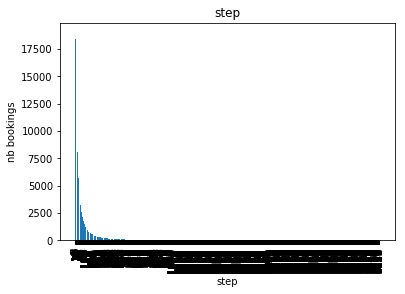

1 18936
2 18767
3 18734
4 18593
5 18373
6 17992
7 17681
8 17245
9 16792
10 16300
11 15693
12 15035
13 14283
14 13544
15 12927
16 12290
17 11716
18 11201
19 10720
20 10261
21 9843
22 9410
23 9059
24 8694
25 8374
26 8033
27 7731
28 7469
29 7190
30 6929
31 6695
32 6459
33 6251
34 6074
35 5876
36 5697
37 5511
38 5356
39 5209
40 5017
41 4881
42 4749
43 4585
44 4469
45 4380
46 4247
47 4130
48 4050
49 3938
50 3824
51 3755
52 3661
53 3562
54 3489
55 3421
56 3339
57 3270
58 3203
59 3135
60 3067
61 2989
62 2925
63 2861
64 2802
65 2729
66 2684
67 2616
68 2572
69 2522
70 2463
71 2410
72 2350
73 2283
74 2251
75 2202
76 2154
77 2111
78 2081
79 2042
80 2005
81 1957
82 1927
83 1885
84 1845
85 1824
86 1806
87 1771
88 1737
89 1710
90 1680
91 1654
92 1616
93 1576
94 1561
95 1530
96 1505
97 1472
98 1458
99 1427
100 1393
101 1371
102 1354
103 1339
104 1315
105 1299
106 1278
107 1264
108 1243
109 1229
110 1212
111 1191
112 1172
113 1156
114 1137
115 1118
116 1102
117 1093
118 1072
119 1059
120 1035
121 1025

2557 1
2558 1
2559 1
2560 1
2561 1
2562 1
2563 1
2564 1
2565 1
2566 1
2567 1
2568 1
2569 1
2570 1
2571 1
2572 1
2573 1
2574 1
2575 1
2576 1
2577 1
2578 1
2579 1
2580 1
2581 1
2582 1
2583 1
2584 1
2585 1
2586 1
2587 1
2588 1
2589 1
2590 1
2591 1
2592 1
2593 1
2594 1
2595 1
2596 1
2597 1
2598 1
2599 1
2600 1
2601 1
2602 1
2603 1
2604 1
2605 1
2606 1
2607 1
2608 1
2609 1
2610 1
2611 1
2612 1
2613 1
2614 1
2615 1
2616 1
2617 1
2618 1
2619 1
2620 1
2621 1
2622 1
2623 1
2624 1
2625 1
2626 1
2627 1
2628 1
2629 1
2630 1
2631 1
2632 1
2633 1
2634 1
2635 1
2636 1
2637 1
2638 1
2639 1
2640 1
2641 1
2642 1
2643 1
2644 1
2645 1
2646 1
2647 1
2648 1
2649 1
2650 1
2651 1
2652 1
2653 1
2654 1
2655 1
2656 1
2657 1
2658 1
2659 1
2660 1
2661 1
2662 1
2663 1
2664 1
2665 1
2666 1
2667 1
2668 1
2669 1
2670 1
2671 1
2672 1
2673 1
2674 1
2675 1
2676 1
2677 1
2678 1
2679 1
2680 1
2681 1
2682 1
2683 1
2684 1
2685 1
2686 1
2687 1
2688 1
2689 1
2690 1
2691 1
2692 1
2693 1
2694 1
2695 1
2696 1
2697 1
2698 1
2699 1

In [51]:
plot_dict(dict_feature_nb_bookings['step'], 'step', 'step', 'nb bookings')

for key, value in dict_feature_nb_bookings['step'].items():
    print('{} {}'.format(key, value))